<a href="https://colab.research.google.com/github/lmoghimi/personal-processing/blob/main/20250302_offsite_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Startup***

---



# **Run these first**

In [ ]:
#@title Imports for JupyterLite
%pip install -q ipywidgets

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import os
import glob

import numpy as np

import math
from math import log

import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

import pandas as pd

import csv

import tkinter as tk
from tkinter import filedialog

import scipy
from scipy.signal import chirp, find_peaks, peak_widths
from scipy import integrate

import re #useful for splitting strings

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 24.1 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#@title Global inputs for raw data processing: directories

userdir = '/content/drive/Shareddrives/Extraction_Subgroup_Data/NSLS-II_202403' #@param ['/content/drive/Shareddrives/Extraction_Subgroup_Data/NSLS-II_202503','/content/drive/Shareddrives/Extraction_Subgroup_Data/NSLS-II_202406','/content/drive/Shareddrives/Extraction_Subgroup_Data/NSLS-II_202403','/nsls2/data/xpd-new/legacy/processed/xpdUser'] {allow-input: false}
## scriptdir = os.path.join(userdir, 'userScripts')
refsdir = os.path.join('/content/drive/Shareddrives/Extraction_Subgroup_Data/NSLS-II_202503','ref_xrd_profiles') #@param ["os.path.join(userdir,'ref_xrd_profiles')","os.path.join(userdir,userScripts,xrd_profiles)"] {"type":"raw"}{allow-input:true}
laserdir = os.path.join(userdir, 'NSLS-II_March_2025_Experiment/25_Mar_laser_logsandprograms') #@param ["os.path.join(userdir, 'NSLS-II_March_2025_Experiment/25_Mar_laser_logsandprograms')","os.path.join(userdir, 'NSLS-II_March_2025_Experiment/25_Mar_laser_logsandprograms')"] {"type":"raw"}
pyromdir = laserdir # @param ["laserdir"] {"type":"raw"}

# timestamps = ['primary-1', ]
#ntimestamps = 2 #for comparison between t0 and tf
# ntimestamps = 125 #for all runs
#ntimestamps_depths
lw = 0.75 #linewidth

#not sure if these do anything
shift = True
get_timestamps = True

In [ ]:
#@title Plotting colors for the phases
#lincol_fe='tab:green' #iron
lincol_fe='tab:purple'

#lincol_w='tab:red' #wustite
lincol_w='tab:pink'

#lincol_m='tab:purple' #magnetite
lincol_m='tab:green'

#lincol_h='tab:orange' #hematite
lincol_h='tab:cyan'

lincol_ceo2 = 'tab:orange'

# lincol_h_ore = 'tab:purple'

lincol_magh='tab:olive' #maghemite

lincol_qz = 'tab:gray' #quartz

lincol_cem='tab:black' #cementite

#lincol_wf = 'tab:blue' #sets the line color for the waterfall series
#lincol_wf = 'navy'

# **Functions**

In [ ]:
#@title foldername
def foldername(file_name):
    '''
    returns the run folder when given a file name
    '''
    parsename = file_name.split('-')[0].split('_')
    #print('parsename =', parsename)
    #print('last element=', parsename[-1])
    parsename.remove(parsename[-1])
    #print('result is', '_'.join(parsename))

    run_folder = '_'.join(parsename)
    print('run_folder =', run_folder)
    return run_folder

In [ ]:
#@title get_rawdata
def get_rawdata(run_folder, file_name):
    '''
    Output: rawdata i.e. q and I
    '''
    run_path = os.path.join(userdir,'xpd_data', run_folder, 'integration') #run_path = os.path.join(userdir, 'tiff_base', run_folder, 'integration')
    print('run_path = ', run_path)
    file_path = os.path.join(run_path,file_name)
    print('file_path =', file_path)

    rawdata = np.loadtxt(file_path)
    print('rawdata has been loaded')
    return rawdata

In [ ]:
#@title plot_vert_refs
def plot_vert_refs(axisss,q):
    #see where the peak range should be, for given input index
    axisss.axvline(x=q[I_fe_low], linestyle='solid', linewidth = lw_fp, color=lincol_fe)
    axisss.axvline(x=q[I_fe_up], linestyle='solid', linewidth = lw_fp, color=lincol_fe)
    axisss.axvline(x=q[I_w_low], linestyle='solid', linewidth = lw_fp, color=lincol_w)
    axisss.axvline(x=q[I_w_up], linestyle='solid', linewidth = lw_fp, color=lincol_w)
    axisss.axvline(x=q[I_m_low], linestyle='solid', linewidth = lw_fp, color=lincol_m)
    axisss.axvline(x=q[I_m_up], linestyle='solid', linewidth = lw_fp, color=lincol_m)
    axisss.axvline(x=q[I_h_low], linestyle='solid', linewidth = lw_fp, color=lincol_h)
    axisss.axvline(x=q[I_h_up], linestyle='solid', linewidth = lw_fp, color=lincol_h)
    axisss.axvline(x=q[I_cem_up], linestyle='solid', linewidth = lw_fp, color=lincol_cem)
    axisss.axvline(x=q[I_ceo2_low], linestyle='solid', linewidth = lw_fp, color=lincol_ceo2)
    axisss.axvline(x=q[I_ceo2_up], linestyle='solid', linewidth = lw_fp, color=lincol_ceo2)

In [ ]:
#@title find_pk_phase
def find_pk_phase(I,lower,upper,prom):
    '''
    find the peak for a given phase
    I_phase[lower,upper] gives the signal in the range of interest. lower and upper are the indices for the lower and upper bounds, respectively
    output: set of val1 and val2 for this phase
    '''
    peaks, properties = find_peaks(I[lower:upper], prom)
    #print(peaks, properties)
    #print('Index of peak in x that satisfy all given conditions: ', peaks)
    #print('Peak height: ', properties['peak_heights'])

    if peaks.size > 0: #i.e. if the list isn't empty --> if a peak was found
        val1 = q[(lower + peaks)][0] #there should only be one peak identified by find_peaks if the proper range was selected, so selecting the first value of the array should really be the only value
        val2 = I[(lower + peaks)][0]
        #print('the phase peak is located at q = ', val1, ' with I = ', val2)
    else:
        #print('List is empty. No peaks found in the specified range')
        val1 = float('nan')
        val2 = 0 #set intensity equal to zero if no peak is found
    return val1, val2, properties, peaks


In [ ]:
#@title process_pyrom()
#NOTE: Timestamp and datetime are two formats for expressing time and have their own methods. they are not compatible
def process_pyrom(fp):
    '''
    Reads the pyrometer data for a given input file and expresses data points relative to t0
    '''
    pyrom_data = pd.read_excel(fp)
    y_axis_pyrom = pyrom_data['eurotherm_temperature']
    x_axis_pyrom = []
    for i in pyrom_data['time']: #data is natively in the Timestamp format
        if i == pyrom_data['time'][0]:
            #print('this is the pyrometer start, unformatted:',i,'-- it is in UTC')
            start = i.tz_localize('UTC') #this is the starting time
            #start = i.tz_localize('America/New_York')
            ##start = i.to_datetime64()
            start_new_york = start.tz_convert('America/New_York') #Timestamp format. converting to eastern daylight time
            start_datetime_new_york = start_new_york.strftime("%m-%d-%Y %H:%M:%S")
            dt_sec = 0
        elif i == pyrom_data['time'][1]:
            secondstart = i.tz_localize('UTC')
            secondstart_new_york = secondstart.tz_convert('America/New_York')
            secondstart_datetime_new_york = secondstart_new_york.strftime("%m-%d-%Y %H:%M:%S")
        elif i == pyrom_data['time'][len(pyrom_data['time'])-1]:
            end = i.tz_localize('UTC')
            #end = i.tz_localize('America/New_York')
            ##end = i.to_datetime64()
            end_new_york = end.tz_convert('America/New_York')
            end_datetime_new_york = end_new_york.strftime("%m-%d-%Y %H:%M:%S")
        else:
            dt2 = i.tz_localize('UTC')
            #dt2 = i.tz_localize('America/New_York')
            ##dt2 = i.to_datetime64()
            dt = dt2 - start
            dt_sec = dt / np.timedelta64(1, 's')
            #print(dt_sec)
        x_axis_pyrom.append(dt_sec)
        #print('dt =', dt)
    # print('type=', type(dt))
    # print('type=', type(dt_sec))
    print('Pyrometer start time:', start_datetime_new_york,' EDT (military)')
    #print('Pyrometer end time:', end_datetime_new_york,' EDT (military)') #NOTE: this is not always accurate, due to mis-saving in the file

    x_axis_pyrom = np.array(x_axis_pyrom)
    y_axis_pyrom = np.array(y_axis_pyrom)

    return x_axis_pyrom, y_axis_pyrom, start_datetime_new_york, secondstart_datetime_new_york

In [ ]:
#@title process_laserlog()
def process_laserlog(fp):
    '''
    Reads the laser log data for a given input file and expresses data points relative to its t0
    '''
    laser_log_data = []
    with open(fp, mode = 'r') as file:
        csvFile = csv.DictReader(file)
        for lines in csvFile:
            #print(lines)
            laser_log_data.append(lines) #extract data from the file for python treatment

    #print(laser_log_data[1])
    lt_pt1 = laser_log_data[1]['FileType:PSCS_Data_Log'].split(':')[1] #this gives the date
    lt = str(laser_log_data[1][None]) #laser log start time + year
    lt = lt.replace("['", "")
    lt_pt2 = lt.replace("']", "")
    #print('lt_pt1:', lt_pt1)
    #print('lt_pt2:', lt_pt2)
    lt = lt_pt1 + lt_pt2
    #print('lt:',lt)
    st = laser_log_data[2]['FileType:PSCS_Data_Log'].split(':')[-1]
    st = st.replace('S', '') #sampling time

    print("The log's first data point was at:",lt,'and the sampling time is',st,'sec')


    recnum = []
    volt = []
    current = []
    count = 0
    for lines in laser_log_data:
        if count >= 4:
            recnum.append(int(laser_log_data[count]['FileType:PSCS_Data_Log'].split(':')[-1]))
            volt.append(int(laser_log_data[count][None][0]) / 1000) #in V
            current.append(int(laser_log_data[count][None][1]) / 1000) #in A
        # elif count < 4:
        #     print('no its not')
        count = count + 1
    print()
    #print('recnum = ', recnum)
    #print('volt = ', volt)
    #print('current = ', current)
    power = np.multiply(volt, current)
    #print('power = ', power)

    return st, lt, recnum, power

In [ ]:
#@title plot_mult_refs()
def plot_mult_refs(axisss):
    #load multiple reference files scans

    ref_phases = ['Lab_iron_q', 'Lab_wustite_q','Lab_magnetite_q','Lab_hematite_q']
    color_ref_phases = [lincol_fe, lincol_w, lincol_m, lincol_h]

    # ref_phases = ['Iron_2300200_q', 'Wuestite_9009766_q','Lab_magnetite_q','Lab_hematite_q']
    # color_ref_phases = [lincol_fe, lincol_w, lincol_m, lincol_h]

    # ref_phases = ['Iron_2300200_q', 'Wuestite_9009766_q','Lab_magnetite_q','Lab_hematite_q', 'Fe3C_COD']
    # color_ref_phases = [lincol_fe, lincol_w, lincol_m, lincol_h, lincol_cem]

    # ref_phases = ['Iron_2300200_q', 'Wuestite_9009766_q','Lab_magnetite_q','Lab_hematite_q','67p_Fe_ore_q']
    # color_ref_phases = [lincol_fe, lincol_w, lincol_m, lincol_h, lincol_h_ore]

    # ref_phases = ['Iron_2300200_q', 'Wustite_q','Lab_magnetite_q','Lab_hematite_q','67p_Fe_ore_q','Ceria_q']
    # color_ref_phases = [lincol_fe, lincol_w, lincol_m, lincol_h, lincol_h_ore, lincol_ceo2]

    ref_shift_y = -8
    for i_phase, ref_phase in enumerate(ref_phases):
        # reffile = os.path.join(userdir, 'userScripts', 'xrd_profiles', ref_phase + '.txt') #modifying to below
        reffile = os.path.join(refsdir, ref_phase + '.txt')
        refdata = np.loadtxt(reffile)
        q_ref_raw = refdata[:, 0]
        I_ref_raw = refdata[:, 1]

        I_log = np.log(I_ref_raw+1) #we add a number here so that we can obtain the log of the dataset (which initially contains 0)
        # print('I_log:',I_log)
        I_ref = I_log-I_log.min() + ref_shift_y*i_phase

        axisss.plot(q_ref_raw, I_ref, label= ref_phase, linewidth= lw, color= color_ref_phases[i_phase])

    #OLD AND NOT INTUITIVE
    # ref_shift_y = -1
    # for i_phase, ref_phase in enumerate(ref_phases):
    #     # reffile = os.path.join(userdir, 'userScripts', 'xrd_profiles', ref_phase + '.txt') #modifying to below
    #     reffile = os.path.join(refsdir, ref_phase + '.txt')
    #     refdata = np.loadtxt(reffile)
    #     q_ref = refdata[:, 0]
    #     I_ref = refdata[:, 1]
    #     I_ref = I_ref - I_ref.min() #"baselining" the data
    #     I_ref = I_ref/(I_ref.max())  + ref_shift_y*(i_phase + 1) -5
    #     axisss.plot(q_ref, I_ref, label= ref_phase, linewidth= lw, color= color_ref_phases[i_phase])

# ***On-site analysis***

---




# **Inputs for raw_data_save_all and bkgdsub_data_save_all**

In [ ]:
#@title raw_data_save_all: Load in-situ or depth scan series, set ntimestamps, and select background

#give the waterfall plot for in-situ series or depth series? (this only affects the plot labeling)
data_series_type = ['in-situ','depth']
response = data_series_type[0] #@param ["data_series_type[0]","data_series_type[1]"] {"type":"raw"}

# in which "run" folder is the data located?
runfolder_preamble = os.path.join(userdir,'tiff_base') #@param["os.path.join(userdir,'xpd_data')","os.path.join(userdir,'tiff_base')"]{"type":"raw","allow-input":false}
run_folder ='run7_pure_hematite' #@param["'run10_H2'","'run65_ref'","'run66_ref'","'run80_bulksample'","'run126_references'"]{"type":"raw","allow-input":true}
fp = os.path.join(runfolder_preamble,run_folder,'integration')
#which files to read?
common_filename = '/run7_pure_hematite_20240326-225324_835586*' #@param ["'/run10_H2_20250303-223943_6fc50f*'","'/run80_bulksample_20240329-073328_31a7fa*'"] {"type":"raw","allow-input":true}
filelist =  glob.glob(fp + common_filename)
# print('file list:',filelist)

filedict = {}
for filename in filelist:
    file_parse = os.path.basename(filename).split('_')
    # print('file_parse:',file_parse)
    if not ('tth.chi' in file_parse):
        primary_number = file_parse[-3] #formerly file_number
        # print('primary_number:',primary_number)
        filedict[primary_number] = filename

print('\n filedict =', filedict)
print('number of files: ', len(filedict))
ntimestamps = len(filedict) # @param ["50","len(filedict)"] {"type":"raw"} #bookmark --- everything above here seems to be working as desired
print('ntimestamps (entered) =', ntimestamps)

################# create "timestamps", according to ntimestamps desired with ~equal frequency
if get_timestamps:
    #timestamps = ['primary-%d'%k for k in np.linspace(1, len(filedict)-1, ntimestamps).astype(int)] #this prepares the list of files to plot in chronological order
    timestamps = ['primary-%d'%k for k in np.linspace(1, len(filedict), ntimestamps).astype(int)] #this organizes the list in chronological order ##@Yifan, shouldn't this be the correct line?
# print('timestamps:',timestamps)


################load the selected files in chronological order, into the array raw_data_save_all
primary = []
raw_data_save_all = []
save_depth = []
#save_time_insitu = []
bkgdsub_data_save_all = []


for enum_index, timestamp in enumerate(timestamps):
    # print('enum_index:',enum_index)
    # print('timestamp:',timestamp)
    filename = filedict[timestamp]
    # print('Loading file...', os.path.basename(filename))
    timestamp_num = int(timestamp.split('-')[-1]) # convert "timestamp" string to number
    # print('Loading as scan #...', timestamp_num)

    rawdata = np.loadtxt(filename) #each rawdata is [(#data, 2)], where 2 represents q and I columns. q = rawdata[:, 0], I = rawdata[:, 1]
    raw_data_save_all.append(rawdata) #stacks the array  #makes 3D array of 125, q and I for each run --> (nstimestamps, nt, 2)
    primary.append(timestamp_num)
    if response == 'depth':
        save_depth.append([timestamp_num, os.path.basename(filename).split('_')[-4]])

##### convert raw data_save_all into numpy array ######
raw_data_save_all = np.array(raw_data_save_all)
print('shape of raw_data_save_all array is: ', raw_data_save_all.shape)

#print(save_depth)
save_depth = np.array(save_depth)
print('save_depth:',save_depth)
print('save_depth.shape:',save_depth.shape)

############################ background scan #####################################
bkgdfolder_preamble = os.path.join(userdir,'tiff_base') #@param["os.path.join(userdir,'xpd_data')","os.path.join(userdir,'tiff_base')"]{"type":"raw","allow-input":false}
bkgd_folder ='run5_50-50hematite-ceria' #@param["'run10_H2'","'run67_finalbckgd'","'run95_depthscan_background'"]{"type":"raw","allow-input":true}
bkgd_file = 'run5_50-50hematite-ceria_20240326-161010_df87d7_primary-1_mean_q.chi' #@param["'run10_H2_20250303-225730_e1f439_primary-1_mean_q.chi'","'run95_depthscan_background_20240623-161212_c682d5_ss_stg2_y_43,28mm_primary-16_mean_q.chi'"]{"type":"raw","allow-input":true}
print('bkgd_file:', bkgd_file)
fp_bkgd = os.path.join(bkgdfolder_preamble,bkgd_folder,'integration',bkgd_file)
bkgd_file = glob.glob(fp_bkgd)
print('fp_bkgd:', fp_bkgd)
rawbkgd = np.loadtxt(bkgd_file[0])
bkgd_data = np.array(rawbkgd)

background = bkgd_data
q_bkgd = bkgd_data[:,0]
I_bkgd = bkgd_data[:,1]
for iv, timestamp in enumerate(raw_data_save_all[:, 0, 0]):
    # print(iv)
    timestamp_num = iv+1
    rawdata = raw_data_save_all[iv, :, :]
    q = rawdata[:, 0]
    I = rawdata[:, 1]
    I_bkgdsub = I-I_bkgd
    bkgdsub_data_save_all.append(I_bkgdsub)
bkgdsub_data_save_all = np.array(bkgdsub_data_save_all)
print('shape of bkgdsub_data_save_all array is: ', bkgdsub_data_save_all.shape)


 filedict = {'primary-1': '/content/drive/Shareddrives/Extraction_Subgroup_Data/NSLS-II_202403/tiff_base/run7_pure_hematite/integration/run7_pure_hematite_20240326-225324_835586_primary-1_mean_q.chi'}
number of files:  1
ntimestamps (entered) = 1
shape of raw_data_save_all array is:  (1, 3000, 2)
save_depth: []
save_depth.shape: (0,)
bkgd_file: run5_50-50hematite-ceria_20240326-161010_df87d7_primary-1_mean_q.chi
fp_bkgd: /content/drive/Shareddrives/Extraction_Subgroup_Data/NSLS-II_202403/tiff_base/run5_50-50hematite-ceria/integration/run5_50-50hematite-ceria_20240326-161010_df87d7_primary-1_mean_q.chi
shape of bkgdsub_data_save_all array is:  (1, 3000)


In [ ]:
print(fp_bkgd)
print(bkgd_file)

/content/drive/Shareddrives/Extraction_Subgroup_Data/NSLS-II_202503/tiff_base/run5_50-50hematite-ceria/integration/run5_50-50hematite-ceria_20240326-161010_df87d7_primary-1_mean_q.chi
[]


# **1. Plotting diffraction data**

In [ ]:
#@title plot the detector images
### here I also want to overlay the approximate positions of each of the phase peaks that I care about

#define dictionary: radius (q) | phase that this corresponds to
q_pos_n_phase = []
q_pos_n_phase.append([])


I_plot.max() = 1742.0531616210938


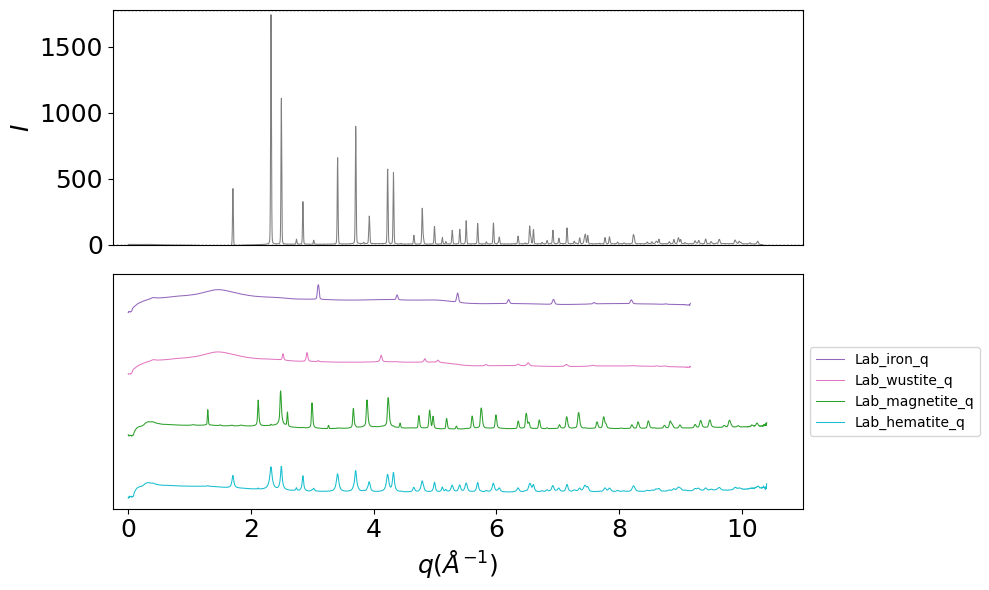

In [ ]:
#@title Load and plot one scan

#option 1 for selecting file
# file_name = 'run67_ref_20250305-081539_4ac976_primary-1_mean_q.chi' #'run10_H2_20250303-223943_6fc50f_primary-18_mean_q.chi'      #'run64_hematite_pellet_H2_IR_20240328-230456_e69f12_primary-93_mean_q.chi'
# run_folder = foldername(file_name)
# results = get_rawdata(run_folder, file_name)
# q = results[:, 0]
# I = results[:, 1]
###

#option 2 for selecting file
scan_num = 1 #@param ['1']{"type":"raw","allow-input":true}
index = scan_num - 1
rawdata = raw_data_save_all[index, :, :]
q = rawdata[:, 0]
I_bkgdsub = bkgdsub_data_save_all[index,:] #bkgdsub_data_save_all array is:  (80, 3000)
###

I_plot = I_bkgdsub #@param ['I','I_bkgdsub']{"type":"raw","allow-input":true}

## create figure object -- plotting setting ##
figsize = (10, 6) #(12, 6)
fs = 18
fig, ax = plt.subplots(2, figsize=figsize, tight_layout=True)

##################### vertical lines ################################
lw_fp=1
ax[0].axhline(y=0, linestyle='dotted', linewidth = lw_fp, color='k')
ax[0].axhline(y=I.max(), linestyle='dotted', linewidth = lw_fp, color='k')
# #plot_vert_refs()
# ax[0].axvline(x=q[200], linestyle='dotted', linewidth = lw_fp, color='k')
# ax[0].axvline(x=q[450], linestyle='dotted', linewidth = lw_fp, color='k')

# ax[0].axvline(x=q[I_fe_low], linestyle='solid', linewidth = lw_fp, color=lincol_fe)
# ax[0].axvline(x=q[I_fe_up], linestyle='solid', linewidth = lw_fp, color=lincol_fe)
# ax[0].axvline(x=q[I_w_low], linestyle='solid', linewidth = lw_fp, color=lincol_w)
# ax[0].axvline(x=q[I_w_up], linestyle='solid', linewidth = lw_fp, color=lincol_w)
# ax[0].axvline(x=q[I_m_low], linestyle='solid', linewidth = lw_fp, color=lincol_m)
# ax[0].axvline(x=q[I_m_up], linestyle='solid', linewidth = lw_fp, color=lincol_m)
# ax[0].axvline(x=q[I_h_low], linestyle='solid', linewidth = lw_fp, color=lincol_h)
# ax[0].axvline(x=q[I_h_up], linestyle='solid', linewidth = lw_fp, color=lincol_h)
# ax[0].axvline(x=q[I_ceo2_low], linestyle='solid', linewidth = lw_fp, color=lincol_ceo2)
# ax[0].axvline(x=q[I_ceo2_up], linestyle='solid', linewidth = lw_fp, color=lincol_ceo2)

#######################  other plotting settings ##############################
ax[0].plot(q, I_plot, linewidth = lw,color='tab:gray') #ax.plot(q, I/I.max(), linewidth = lw)
plot_mult_refs(ax[1])
print('I_plot.max() =',I_plot.max())

ax[1].set_xlabel(r'$q  ({\AA}^{-1})$', fontsize=fs)
ax[0].set_ylabel(r'$I$', fontsize=fs)
ax[1].set_yticks([])
ax[1].tick_params(labelsize=fs)
horiz_range = [-.25,11]
ax[1].set_xlim(horiz_range)
ax[0].set_xlim(horiz_range)
ax[0].set_xticks([])
ax[0].tick_params(labelsize=fs)
ax[0].set_ylim([-.25,I.max()]) #[-12,1]

ax[1].legend(loc='center left', bbox_to_anchor=[1, 0.5])

#ax[0].set_title(run_folder, fontsize=fs)
# ax[0].set_title(file_name, fontsize=fs)

I.max() = 1.4076515


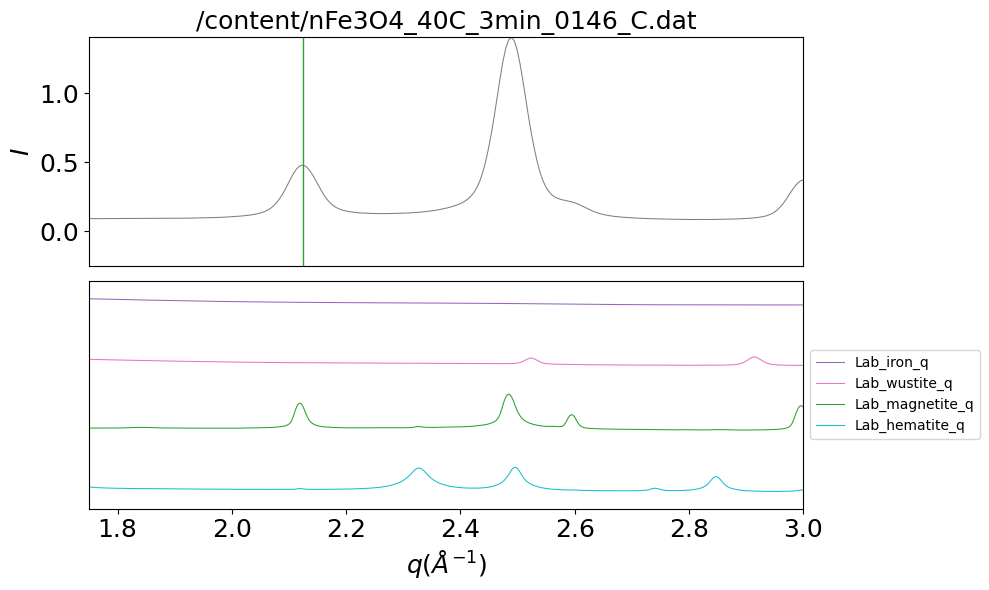

In [ ]:
#@title plot one diffraction scan (APS experiment)
#reading diffraction data in the .dat format from APS experiments
rawdata = []
file_name = '/content/nFe3O4_40C_3min_0146_C.dat'
with open('/content/nFe3O4_40C_3min_0146_C.dat', 'r') as f:
    for line in f:
        # Process each line (e.g., split by delimiter)
        data = line.strip().split('\t') #line.strip().split(' ')
        # print(data[0], data[1])
        rawdata.append([data[0], data[1]])
rawdata = np.array(rawdata)
d = rawdata[1:, 0]
d_float_list = [float(s) for s in d]
d = np.array(d_float_list)

q =  [2*np.pi/iv for iv in d]
q = np.array(q)

I = rawdata[1:, 1]
I_float_list = [float(s) for s in I]
I = np.array(I_float_list)

## create figure object -- plotting setting ##
figsize = (10, 6) #(12, 6)
fs = 18
fig, ax = plt.subplots(2, figsize=figsize, tight_layout=True)

#######################  other plotting settings ##############################
ax[0].plot(q, I, linewidth = lw,color='tab:gray') #ax.plot(q, I/I.max(), linewidth = lw)
plot_mult_refs(ax[1])
print('I.max() =',I.max())

ax[1].set_xlabel(r'$q  ({\AA}^{-1})$', fontsize=fs)
ax[0].set_ylabel(r'$I$', fontsize=fs)
ax[1].set_yticks([])
ax[1].tick_params(labelsize=fs)
horiz_range = [1.75,3] #[-.25,11]
ax[1].set_xlim(horiz_range)
ax[0].set_xlim(horiz_range)
ax[0].set_xticks([])
ax[0].tick_params(labelsize=fs)
ax[0].set_ylim([-.25,I.max()]) #[-12,1]

ax[1].legend(loc='center left', bbox_to_anchor=[1, 0.5])

#ax[0].set_title(run_folder, fontsize=fs)
ax[0].set_title(file_name, fontsize=fs)

ax[0].axvline(x=2.125, linestyle='solid', linewidth = lw_fp, color=lincol_m)

remember to run "load in situ" first to get raw_data_save_all!!!
ref_phases: ['Lab_iron_q', 'Lab_wustite_q', 'Lab_magnetite_q', 'Lab_hematite_q']
shape of I_data: (80, 3000)
plotting background
plotting from bkgdsub_data_save_all


(-0.5, 10.0)

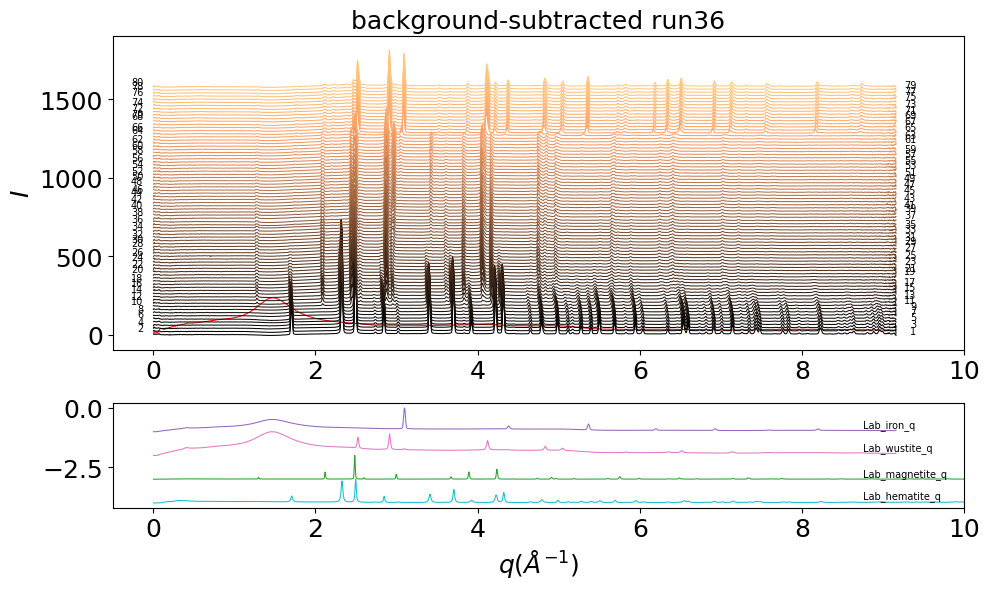

In [ ]:
# @title Plotting waterfall with background subtraction
#modified from NSLS-II_202406 > userScripts > beamline_analysis.ipynb

print('remember to run "load in situ" first to get raw_data_save_all!!!')
wf_shift_coefficient = 20 #2

################# create figure object -- plotting settings ####################
#figsize = (12, 6)
figsize = (10, 6)
fs = 18
line_label_fs = 7
fig, ax = plt.subplots(2,1,figsize=figsize, gridspec_kw={'height_ratios': [3,1]}, tight_layout=True)

ax[1].set_xlabel(r'$q  ({\AA}^{-1})$', fontsize=fs)
ax[0].set_ylabel(r'$I$', fontsize=fs)
ax[0].set_title('background-subtracted run36', fontsize=fs)
ax[0].tick_params(labelsize=fs)
ax[1].tick_params(labelsize=fs)

#plot display for markers and reference lines
lw_fp = 0.025 #linewidth for find_peaks range
markersz = .5 #define marker size for results of find_peaks
#markersh = 'x' #define marker shape
markersh = 'o'
marcol_fe = 'b'
marcol_h = 'b'
marcol_w = 'b'
marcol_m = 'b'
mark_dist = 0 #marker vertical distance from peak

######################## load multiple reference files #########################
ref_phases = ['Lab_iron_q', 'Lab_wustite_q','Lab_magnetite_q','Lab_hematite_q']
color_ref_phases = [lincol_fe, lincol_w, lincol_m, lincol_h]
# ref_phases = ['Iron_2300200_q', 'Wuestite_9009766_q','Lab_magnetite_q','Lab_hematite_q','Lab_CeO2_q']
# color_ref_phases = [lincol_fe, lincol_w, lincol_m, lincol_h,lincol_ceo2]
# ref_phases = ['Iron_2300200_q', 'Wuestite_9009766_q','Lab_magnetite_q','Lab_hematite_q','67p_Fe_ore_q']
# color_ref_phases = [lincol_fe, lincol_w, lincol_m, lincol_h, lincol_h_ore]
# ref_phases = ['Iron_2300200_q', 'Wuestite_9009766_q','Lab_magnetite_q','Lab_hematite_q','67p_Fe_ore_q','Ceria_1562989_q']
# color_ref_phases = [lincol_fe, lincol_w, lincol_m, lincol_h, lincol_h_ore, lincol_ceo2]
print('ref_phases:',ref_phases)


################# plotting setting #####################################################################################
# figsize = (10, 6)
# fs = 18
# fig, ax = plt.subplots(figsize=figsize, tight_layout=True) #this is key for "hold on"!!!!
# ax.clear()

################ plotting selected timestamps ########################################################
#raw_data_save_all
#shape of raw_data_save_all array is:  (80, 3000, 2)
q_values = np.array([raw_data_save_all[i, :, 0] for i in range(len(timestamps))]) #raw_data_save_all[0, :, 0]  # Assuming q is in the first column and I is in the 2nd column
I_data = np.array([raw_data_save_all[i, :, 1] for i in range(len(timestamps))])  # Extract intensity data
print('shape of I_data:',np.shape(I_data))
a, b = np.shape(I_data)
num_of_lines = a #number of timestamps that will be plotted
lincol_gradient = iter(cm.copper(np.linspace(0,1,num_of_lines))) #Wistia, copper, and autumn are nice gradients
counting = 0
find_peak_outputs = []

print('plotting background')
#defining in an earlier cell
# background = bkgd_data
# q_bkgd = bkgd_data[:,0]
# I_bkgd = bkgd_data[:,1]
ax[0].plot(q_bkgd, I_bkgd-(0.05*wf_shift_coefficient), color = 'r', linewidth = lw) #plot background

print('plotting from bkgdsub_data_save_all')
for iv, timestamp in enumerate(raw_data_save_all[:, 0, 0]):
    # print(iv)
    timestamp_num = iv+1
    rawdata = raw_data_save_all[iv, :, :]
    q = rawdata[:, 0]
    #defining in an earlier cell
    # I = rawdata[:, 1]
    # I_bkgdsub = I-I_bkgd
    I_plot = bkgdsub_data_save_all[iv,:] #bkgdsub_data_save_all array is:  (80, 3000)

    # if iv == 0: #if first timestamp in series
    #     # print('first, iv=',iv)
    #     plot_save_min_I = I_plot.min()
    #     plot_save_min_q = q.min()
    #     plot_save_max_q = q.max()
    # elif iv == a-1:
    #     # print('last, iv=',iv)
    #     plot_save_max_I = I_plot.max()


    ############## plot waterfall data ######################
    c=next(lincol_gradient)
    #ax[0].plot(q, I, color = c, linewidth = lw)
    wf_shift = iv*wf_shift_coefficient
    '''
    if iv == laser[0] or iv == laser[1] or iv == laser[2]: #condition for whether this is a scan when something important happens with the laser
        ax[0].plot(q, I_plot, color = 'r', linewidth = lw)
    else:
        ax[0].plot(q, I_plot, color = c, linewidth = lw) #here, Lauren!
    '''
    ax[0].plot(q, I_plot+ wf_shift, color = c, linewidth = lw)
    if iv % 2 != 0:
        # print("The number is odd")
        ax[0].text(q[0]-.125, I_plot[-1]+ wf_shift, timestamp_num, ha='right', va='bottom', fontsize = line_label_fs)
    else:
        ax[0].text(q[-1]+.25, I_plot[-1]+ wf_shift, timestamp_num, ha='right', va='bottom', fontsize = line_label_fs)

    counting = counting + 1


#### plotting the reference phases ####
# vert_range = plot_save_max_I - plot_save_min_I #vertical range of the waterfall plot

ref_shift_y = -1
for i_phase, ref_phase in enumerate(ref_phases):
    reffile = os.path.join(refsdir, ref_phase + '.txt')
    refdata = np.loadtxt(reffile)
    q_ref = refdata[:, 0]
    I_ref = refdata[:, 1]
    I_ref = I_ref - I_ref.min() #"baselining" the data
    I_ref = I_ref/(I_ref.max())  + ref_shift_y*(i_phase + 1) #-50
    ax[1].plot(q_ref, I_ref, linewidth= lw, color= color_ref_phases[i_phase]) #label= ref_phase
    ax[1].text(8.75, I_ref[-1], ref_phase, ha='left', va='bottom', fontsize = line_label_fs)
ax[0].set_xlim(-0.5,10) #(-0.5,plot_save_max_q+1)
ax[1].set_xlim(-0.5,10)

remember to run "load in situ" first to get raw_data_save_all!!!
shape of I_data: (65, 3000)
plotting from raw_data_save_all


([], [])

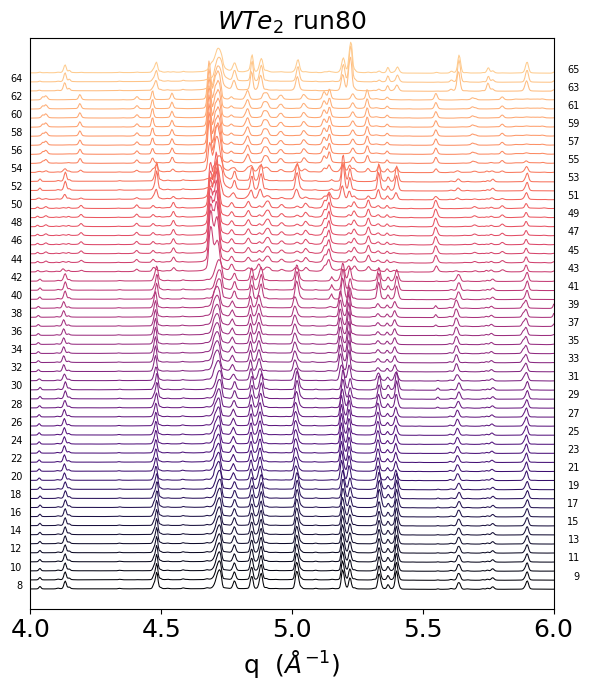

In [ ]:
# @title WTe2 waterfall for (methods manuscript)
print('remember to run "load in situ" first to get raw_data_save_all!!!')
wf_shift_coefficient = 100 #2

################# create figure object -- plotting settings ####################
#figsize = (12, 6)
figsize = (6, 7)
fs = 18
line_label_fs = 7
fig, ax = plt.subplots(1,1,figsize=figsize, tight_layout=True) #gridspec_kw={'height_ratios': [3,1]}

ax.set_xlabel(r'q  (${\AA}^{-1}$)', fontsize=fs)
# ax.set_ylabel(r'$I$', fontsize=fs)
ax.set_title('$WTe_2$ run80', fontsize=fs)
ax.tick_params(labelsize=fs)
ax.tick_params(labelsize=fs)

#plot display for markers and reference lines
lw_fp = 0.025 #linewidth for find_peaks range
markersz = .5 #define marker size for results of find_peaks


################ plotting selected timestamps ########################################################
#raw_data_save_all
#shape of raw_data_save_all array is:  (80, 3000, 2)
q_values = np.array([raw_data_save_all[i, :, 0] for i in range(len(timestamps))]) #raw_data_save_all[0, :, 0]  # Assuming q is in the first column and I is in the 2nd column
I_data = np.array([raw_data_save_all[i, :, 1] for i in range(len(timestamps))])  # Extract intensity data
print('shape of I_data:',np.shape(I_data))
a, b = np.shape(I_data)
num_of_lines = a #number of timestamps that will be plotted
lincol_gradient = iter(cm.magma(np.linspace(0,1,num_of_lines))) #Wistia, copper, and autumn are nice gradients
counting = 0
find_peak_outputs = []

# print('plotting background')
# #defining in an earlier cell
# # background = bkgd_data
# # q_bkgd = bkgd_data[:,0]
# # I_bkgd = bkgd_data[:,1]
# ax.plot(q_bkgd, I_bkgd-(0.05*wf_shift_coefficient), color = 'r', linewidth = lw) #plot background

print('plotting from raw_data_save_all')
for iv, timestamp in enumerate(raw_data_save_all[:, 0, 0]):
    # print(iv)
    if iv > 6:
        timestamp_num = iv+1
        rawdata = raw_data_save_all[iv, :, :]
        q = rawdata[:, 0]
        #defining in an earlier cell
        # I = rawdata[:, 1]
        # I_bkgdsub = I-I_bkgd
        I_plot = rawdata[:, 1] #bkgdsub_data_save_all[iv,:] #bkgdsub_data_save_all array is:  (80, 3000)

        # if iv == 0: #if first timestamp in series
        #     # print('first, iv=',iv)
        #     plot_save_min_I = I_plot.min()
        #     plot_save_min_q = q.min()
        #     plot_save_max_q = q.max()
        # elif iv == a-1:
        #     # print('last, iv=',iv)
        #     plot_save_max_I = I_plot.max()


        ############## plot waterfall data ######################
        c=next(lincol_gradient)
        #ax[0].plot(q, I, color = c, linewidth = lw)
        wf_shift = iv*wf_shift_coefficient
        ax.plot(q, I_plot+ wf_shift, color = c, linewidth = lw)
        if iv % 2 != 0:
            # print("The number is odd")
            ax.text(4-.03, I_plot[-1]+ wf_shift, timestamp_num, ha='right', va='bottom', fontsize = line_label_fs)
        else:
            ax.text(6+.1, I_plot[-1]+ wf_shift, timestamp_num, ha='right', va='bottom', fontsize = line_label_fs)

        counting = counting + 1


ax.set_xlim(4,6) #(-0.5,plot_save_max_q+1)
ax.set_ylim(500,6800)
plt.yticks([])

In [ ]:
#@title (outdated) Load in-situ or depth scan series and set ntimestamps

#give the waterfall plot for in-situ series or depth series?
data_series_type = ['in-situ','depth'] #0 or 1
response = data_series_type[0] #!#!#!#!#!#!#!#!#!# (this only affects the plot labeling)
print('response =', response)

run_folder = 'run49_AR_IR_Tcalib' #!#!#!#!#!#!#!#!#!# in which "run" folder is the data located?
run_path = os.path.join(userdir, 'tiff_base', run_folder, 'integration')
print('run_path = ', run_path)

#which files to read?
###################### parsing the filename
#filelist = glob.glob(run_path + '/run106_hematite_H2_blue_lowPower_20240623-205741_85c755_ss_stg2_y_*') #the common file name amongst all the "before" depth scans
#filelist = glob.glob(run_path + '/run105_Ar_blue_Tcalib_20240623-200639_fc2f22_*') #!#!#!#!#!#!#!#!#!# the common file name amongst all the in-situ scans
filelist = glob.glob(run_path + '/run49_AR_IR_Tcalib_20240622-184215_*')
print('filelist:',filelist)
filedict = {}

for filename in filelist:
    file_parse = os.path.basename(filename).split('_')
    if not ('tth' in file_parse):
        if ('ss' in file_parse or 'stg2' in file_parse): ###
            file_number = file_parse[-3]
            filedict[file_number] = filename
        elif not ('ss' in file_parse or 'stg2' in file_parse):
            file_number = file_parse[-3]
            filedict[file_number] = filename

#print('\n filedict =')
#print(filedict)
print('number of files: ', len(filedict))
ntimestamps = 50 #!#!#!#!#!#!#!#!#!# change as needed
#ntimestamps = len(filedict)

################# grab ntimestamps curves (equally spacing in time)
if get_timestamps:
    #timestamps = ['primary-%d'%k for k in np.linspace(1, len(filedict)-1, ntimestamps).astype(int)] #this prepares the list of files to plot in chronological order
    timestamps = ['primary-%d'%k for k in np.linspace(1, len(filedict), ntimestamps).astype(int)] #this organizes the list in chronological order ##@Yifan, shouldn't this be the correct line?
#print(timestamps)

raw_data_save_all = []
save_depth = []
#save_time_insitu = []

print('ntimestamps (entered) =', ntimestamps)
for iv, timestamp in enumerate(timestamps): #this section loads the selected files in chronological order, into the array raw_data_save_all
    timestamp_num = int(timestamp.split('-')[-1]) # convert timestamp string to number
    filename = filedict[timestamp]
    # print()
    #print('Loading file...', os.path.basename(filename))
    #print('Scan # ', timestamp_num)
    rawdata = np.loadtxt(filename) #each rawdata is [(#data, 2)], where 2 represents q and I columns. q = rawdata[:, 0], I = rawdata[:, 1]
    raw_data_save_all.append(rawdata) #stacks the array  #makes 3D array of 125, q and I for each run --> (nstimestamps, nt, 2)
    if response == 'depth':
        save_depth.append([timestamp_num, os.path.basename(filename).split('_')[-4]])

##### convert raw data_save_all into numpy array ######
raw_data_save_all = np.array(raw_data_save_all)
print('shape of raw_data_save_all array is: ', raw_data_save_all.shape)

#print(save_depth)
save_depth = np.array(save_depth)
print(save_depth)
print(save_depth.shape)

In [ ]:
#@title Waterfall plot
print('run "load in situ first!!!"')
################### create figure object -- plotting settings ##########################################
#figsize = (12, 6)
figsize = (10, 6)
fs = 18
thisfs = 10
# fig, ax = plt.subplots(figsize=figsize, tight_layout=True)
fig, ax = plt.subplots(2, figsize=figsize, tight_layout=True, gridspec_kw={'height_ratios': [9, 1]})
ax[0].set_title(os.path.basename(run_folder) + ' ' + response + ' series', fontsize=fs)

ax[0].set_xlim([-.5,11])
ax[1].set_xlim([-.5,11])
# ax[1].set_ylim([-40,5])
ax[0].tick_params(labelsize=fs)
ax[1].tick_params(labelsize=fs)
ax[0].set_yticklabels('')
ax[1].set_yticklabels('')
ax[0].set_xticklabels('')

#### remove graph borders and unneeded ticks ####
ax[0].spines['top'].set_visible(False)
ax[0].spines['left'].set_visible(False)
ax[0].get_yaxis().set_ticks([])
ax[0].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].spines['left'].set_visible(False)
ax[1].get_yaxis().set_ticks([])
ax[1].spines['right'].set_visible(False)

#### plot reference phases ####
plot_mult_refs(ax[1])


############################## plotting selected timestamps  #######################################
num_of_lines = len(timestamps)
lincol_gradient = iter(cm.copper(np.linspace(0,1,num_of_lines))) #Wistia, copper, and autumn are nice gradients
counting = 0
for enum_index, timestamp in enumerate(timestamps):
    #print(enum_index)
    timestamp_num = int(timestamp.split('-')[-1]) # convert timestamp string to number
    filename = filedict[timestamp]
    rawdata = raw_data_save_all[enum_index, :, :]
    q = rawdata[:, 0]
    I = rawdata[:, 1]
    # print('length of I:', len(I))

    if timestamp == 'primary-1':
      print('This is the first file')
      I0 = I.copy() #fix I0!!!!!!!!!!!!!!!!!!!!!!!!!

    ######################### plot waterfall data ################################
    c=next(lincol_gradient)

    # I_baselined = I-I.min()
    # I0_baselined = I0-I0.min()
    # I_baselined = I-I0.min()

    wf_shift = enum_index*2 #*100
    # I_plot = I_baselined/I0_baselined.max() + wf_shift
    # I_plot = np.log(I_baselined/I0_baselined.max()) + wf_shift
    # I_plot = np.log(I_baselined/I_baselined.max()) + wf_shift
    I_plot = np.log(I) + wf_shift
    ax[0].plot(q, I_plot, color = c, linewidth = lw)


    prim_num = int(timestamp.split('-')[1]) #return the # in the "primary-#" for this scan
    # print('prim_num:',prim_num)
    #### lineout label options ####
    if response == 'in-situ':
        # line_label = timestamp
        line_label = str(prim_num)
    elif response == 'depth':
        #print(save_depth[prim_num -1,1])
        line_label = str(save_depth[prim_num -1,1]) #return the corresponding depth for this scan
        line_label = line_label.split('mm')[0] #remove mm from the label
    else:
        print('something weird is going on')
    # ax[0].text(q[0]-.2, I_plot[0], line_label, ha='right', va='center', fontsize='8')
    ax[0].text(q[2999]+.1, I_plot[2700], line_label, ha='left', va='center', fontsize='8')
    # print(q[2700])

    counting = counting + 1

#### add legend and axes titles to the figure ####
ax[1].legend(loc='center left', bbox_to_anchor=[1, 0.5])
ax[1].set_xlabel(r'$q  ({\AA}^{-1})$', fontsize=fs)
str_ylabel = "$raw$ (a.u.)" # @param ["$raw$ (a.u.)", "$log({I - I.min()})$ (a.u.)", "$log(I)$ (a.u.)", "$I$"] {"type":"raw"}
ax[0].set_ylabel(str_ylabel, fontsize=fs)


# **2. Plotting refinement results**

In [ ]:
# @title read .lst files, organize results into csv
from time import localtime, strftime
#make a folder in the left tab folder here in colab to hold all the .lst files
#select all the .lst files in file viewer (search '.lst'),
#and drag and drop them all into the folder you just made here in colab

folderPath = '/content/run10lsts' #paste the folder path here
# output_filepath = '/content/june_run105_1-17_lst_results.csv'
# output_filepath = '/content/test.csv'

################# output filename, Lauren 9/11/24 ######################
now = strftime("%Y%m%d_%H%M%S", localtime()) #note: this is expressed in UTC time
# output_folder = os.path.join(userdir, 'userAnalysis', 'refinement_results')
output_folder = '/content/'
output_filename = 'refinementresults' + '_' + now #dsa = depth series after #impurity_first_last_lst_results
output_filepath = os.path.join(output_folder, output_filename +'.csv')
print('output_filepath:',output_filepath)
########################################################################

identifierHeader = 'primary' #this is whatever unique part of the file name you want to sort by, this will be the column header

lstList = glob.glob(folderPath + '/*') #this makes a list of all the file paths in the folder
#print(lstList)

# UNIT=NM
# A=0.5493090+-0.0000028
# B1=0.001939+-0.000023

df = pd.DataFrame() #a data frame to hold the info in and eventually become a csv file

for lstFile in lstList: #go through each file path in the list of file paths from the folder
  # print('\n##################################################################################')
  # print(f'starting {lstFile}')
  # print('##################################################################################')
  prefix = '' #initialize the prefix to an empty string
  #paste the filepath to one of the lst files below
  #delete the identifier and replace it with the '|' character
  #this will cause the below code to extract the string segment between each side of the '|' character - that is, the identifier
  identifier = float(re.split('primary-|_mean_tth.lst', lstFile)[1]) #extract the identifier from the file name
  df.at[lstFile, identifierHeader] = identifier #places value into the associated column, at a row associated with the filepath (lstFile)
  #print(f'tempC = {tempC}')
  # A = 0
  # Ce_TDS = 0 #this will hold the Debye Waller factor for Ce
  # O_TDS = 0 #this will hold the Debye Waller factor for O
  previousLine = '' #this will hold the previous line for reference later

  #the below 'with' loop opens and reads the file
  #the encoding term is necessary to read this file type
  with open(lstFile, 'r', encoding='cp1252') as file:
    #the below 'for' loop grabs each line from the file individually
    for line in file:
      if line.startswith('Local parameters and GOALs for phase'):
        prefix = re.split('phase |\n', line)[-2] + '_' #this prefix will be used to organize ourputs by phase
        #print(prefix)

      if '=' in line:
        if ('Rp' in line
            or 'Durbin' in line
            or 'rho' in line
            or 'SpacegroupNo' in line
            or 'HermannMauguin' in line
            or 'XrayDensity' in line
            or 'Rphase' in line
            or 'GEWICHT' in line):
                #print('skipping line')
                continue
        if 'E=(' in line:
          #print(line)
          splitLine = re.split('\(', line)
          splitPrefix =re.split('_', prefix)
          if len(splitPrefix) > 2 and splitPrefix[0] != 'Fe':
            #print('prefix too long')
            #print(f'split prefix = {splitPrefix}')
            #print(f'current prefix = {prefix}')
            prefix = splitPrefix[0] + '_'
            #print(f'new prefix = {prefix}')
          prefix += splitLine[1] + '_'
          #print(prefix)
          #print('################\n')
          continue

        splitLine = re.split('=|\+', line) #splits the string using these deliminators - note '\' before '+', otherwise has error
        #print(f'splitLine= {splitLine}')
        if 'UNDEF' in line or 'ERROR' in line or 'NM' in line or 'B1' in line or 'k2' in line:
          #print(line)
          #print('encountered UNDEF or ERROR, skipping and continuing')
          continue
        # if 'Fe' in prefix and 'k2' in line:
        #   print(line)
        value = float(splitLine[1]) #grab the value in position 1, convert to float, and save
        suffix = splitLine[0] #the value before the '='
        df.at[lstFile, prefix + suffix] = value #places value into the associated column, at a row associated with the filepath (lstFile)

df = df.sort_values(by=identifierHeader) #sort the data frame by the identifier
#the below saves the organized dataframe as a csv, it can now be downloaded from the folder in the left tab
df.to_csv(output_filepath)
#df.to_csv('/content/impurity_first_last_lst_results.CSV') #redefining this above - Lauren
df


      # if line.startswith('B1='):
      #   splitLine = re.split('=|\+', line) #splits the string using these deliminators - note '\' before '+', otherwise has error
      #   #print(f'splitLine= {splitLine}')
      #   if splitLine[1] == 'UNDEF\n':
      #     print('encountered UNDEF, skipping and continuing')
      #     continue
      #   B1 = float(splitLine[1]) #grab the value in position 1, convert to float, and save
      #   df.at[lstFile, prefix + 'B1'] = B1 #places value into the associated column, at a row associated with the filepath (lstFile)

#       if line.startswith('TDS=') and 'CE' in previousLine:
#         splitLine = re.split('=|\+', line) #splits the string using these deliminators - note '\' before '+', otherwise has error
#         #print(f'splitLine= {splitLine}')
#         Ce_TDS = float(splitLine[1]) #grab the value in position 1, convert to float, and save in Ce_TDS
#         df.at[lstFile, 'Ce_TDS'] = Ce_TDS #places value into the associated column, at a row associated with the filepath (lstFile)

#       if line.startswith('TDS=') and 'O-2' in previousLine:
#         splitLine = re.split('=|\+', line)
#         #print(f'splitLine= {splitLine}')
#         O_TDS = float(splitLine[1])
#         df.at[lstFile, 'O_TDS'] = O_TDS #places value into the associated column, at a row associated with the filepath (lstFile)

#       previousLine = line #store the line for reference later

# df = df.sort_values(by=identifierHeader) #sort the data frame by the identifier
# df
# df.to_csv('/content/CeO2_refinement_results_fixed_instrument01.CSV') #save the organized dataframe as a csv, it can now be downloaded from the folder in the left tab

output_filepath: /content/refinementresults_20250513_003524.csv


,primary,Qhematite,Qmagnetite,QWustite,Qironalpha,EPS2,Hematite_A,Hematite_C,Magnetite_A,Wustite_A,amorphous_A,Iron_alpha_A,Iron_alpha_k1
/content/run10lsts/run10_H2_20250303-223943_6fc50f_primary-1_mean_tth.lst,1.0,0.9899,0.0056,0.0032,0.0012,-0.000007,0.506383,1.38219,0.83686,0.431930,0.4324,0.289500,1.0
/content/run10lsts/run10_H2_20250303-223943_6fc50f_primary-2_mean_tth.lst,2.0,0.9897,0.0057,0.0033,0.0013,-0.000008,0.506378,1.38219,0.83685,0.431890,0.4323,0.289500,1.0
/content/run10lsts/run10_H2_20250303-223943_6fc50f_primary-3_mean_tth.lst,3.0,0.9894,0.0058,0.0034,0.0014,-0.000007,0.506376,1.38218,0.83684,0.431880,0.4322,0.289500,1.0
/content/run10lsts/run10_H2_20250303-223943_6fc50f_primary-4_mean_tth.lst,4.0,0.9896,0.0057,0.0033,0.0014,-0.000007,0.506384,1.38220,0.83684,0.431840,0.4327,0.289500,1.0
/content/run10lsts/run10_H2_20250303-223943_6fc50f_primary-5_mean_tth.lst,5.0,0.9892,0.0058,0.0036,0.0013,-0.000006,0.506533,1.38260,0.83697,0.431980,0.4317,0.289500,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
/content/run10lsts/run10_H2_20250303-223943_6fc50f_primary-76_mean_tth.lst,76.0,0.0220,0.1120,0.6390,0.2264,0.000002,0.505500,1.37410,0.84586,0.433464,0.4336,0.288455,1.0
/content/run10lsts/run10_H2_20250303-223943_6fc50f_primary-77_mean_tth.lst,77.0,0.0230,0.1120,0.6400,0.2259,0.000002,0.505600,1.37420,0.84585,0.433448,0.4332,0.288437,1.0
/content/run10lsts/run10_H2_20250303-223943_6fc50f_primary-78_mean_tth.lst,78.0,0.0200,0.1110,0.6430,0.2262,0.000002,0.504400,1.38300,0.84580,0.433438,0.4330,0.288428,1.0
/content/run10lsts/run10_H2_20250303-223943_6fc50f_primary-79_mean_tth.lst,79.0,0.0210,0.1100,0.6410,0.2275,0.000002,0.505500,1.37420,0.84578,0.433420,0.4327,0.288420,1.0


response = in-situ
len(phase_series): 4
plotting the phase_series... Fe
plotting the phase_series... W
plotting the phase_series... M
plotting the phase_series... H
number of scans: 80
saving file to: /content/refinementresults_20250513_003524.png


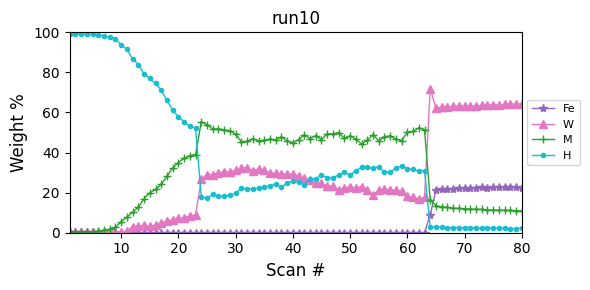

In [ ]:
# @title in-situ weight % vs. time

from time import localtime, strftime
folderPath = '/content/refinementresults_20250513_003524.csv' #paste the folder path here
give_title = 'run10'
data_series_type = ['in-situ','depth'] #0 or 1
response = data_series_type[0] #!#!#!#!#!#!#!#!#!#
print('response =', response)
# define_surface = float('41.78')
# print('define_surface:',define_surface)
scale = 100 #either 1 or 100, depending on whether you're plotting weight fraction or percent
independent_scale = 1 #for depth scans, either 1 or 1000 (um or mm)
lw = 1 #3 #linewidth for the plotting

lst_data = []
with open(folderPath, mode = 'r') as file:
    csvFile = csv.DictReader(file)
    for lines in csvFile:
        #print(lines)
        lst_data.append(lines) #extract data from the file for python treatment

primary = []
stage_height = []
Q_wt_fe = []
Q_wt_w = []
Q_wt_m = []
Q_wt_h = []
# Q_wt_c = []
###
count = 0
text = 'primary'
# extr_depth = lst_data[count+1][''].split('_')[-4].replace('mm','')
# depth = extr_depth.replace(',','.')
# print('whats this say:',float(depth))
# print(lst_data[count][text])
# print(type(lst_data[count][text]))
# print(float(lst_data[count][text]))
# print(type(float(lst_data[count][text])))
for lines in lst_data:
    primary.append(int(float((lst_data[count]['primary']))))
    if response == 'depth':
        extr_stage_height = lst_data[count][''].split('_')[-4].replace('mm','')
        stage_height.append(float(extr_stage_height.replace(',','.')))
    Q_wt_fe.append(float(lst_data[count]['Qironalpha']))
    Q_wt_m.append(float(lst_data[count]['Qmagnetite']))
    Q_wt_w.append(float(lst_data[count]['QWustite'])) #case-sensitive
    Q_wt_h.append(float(lst_data[count]['Qhematite']))
    # Q_wt_c.append(float(lst_data[count]['QFeCementite']))
    ###
    count = count + 1

primary = np.array(primary)
if response == 'depth':
    stage_height = np.array(stage_height)
Q_wt_fe = np.array(Q_wt_fe)
Q_wt_w = np.array(Q_wt_w)
Q_wt_m = np.array(Q_wt_m)
Q_wt_h = np.array(Q_wt_h)
# Q_wt_c = np.array(Q_wt_c)
###

# print('primary:',primary)
#print('stage_height:',stage_height)
# print(Q_wt_fe)
# print(Q_wt_w)
# print(Q_wt_m)
# print(Q_wt_h)

depth = []
ind = 0

if response == 'depth':
    for lines in lst_data:
        #print('count:',count)
        if stage_height[ind] == define_surface:
            depth.append(0)
        elif stage_height[ind] > define_surface:
            depth.append(stage_height[ind] - define_surface)
        else:
            depth.append(stage_height[ind] - define_surface) #depth.append(float('nan'))
        ind = ind + 1
    #print('depth:',depth)
    depth = np.array(depth)
####################### figure ########################
fs = 12
markersz = 5 #20
if response == 'depth':
    figsize = (2.5,5) #(3,5) #width with legend and ticks
else:
    figsize = (6,3)
fig, ax = plt.subplots(figsize=figsize, tight_layout=True)

phase_series = ['Fe', 'W', 'M', 'H']
phase_colors = ['tab:purple', 'tab:pink','tab:green','tab:cyan'] #lincol_ceo2 = 'tab:orange'
phaser_markers = ['*','^','+','.'] #['.','3','+','_']
###
n_phases = len(phase_series)
print('len(phase_series):',n_phases)

for i, phase_series in enumerate(phase_series):
    # print('i:',i)
    print('plotting the phase_series...',phase_series)
    if i == 0:
        y = Q_wt_fe
    elif i == 1:
        y = Q_wt_w
    elif i == 2:
        y = Q_wt_m
    elif i == 3:
        y = Q_wt_h
    # elif i == 4:
    #     y = Q_wt_c
    ###
    else:
        print('phase missing from plotting')

    if response == 'depth':
        independent_axis = depth #primary
        plt.scatter(y*scale,independent_axis*independent_scale, marker = '.', s = markersz, c = phase_colors[i])
        plt.plot(y*scale,independent_axis*independent_scale, marker = '.', c = phase_colors[i], linewidth = lw,label = phase_series)
        plt.xlabel("Weight %", fontsize=fs, color='k')
        ax.set_xlim(0, 1*scale)
        ax.invert_xaxis()
        plt.ylabel('Depth (um)', fontsize=fs) #"Scan #"
        ax.set_ylim(min(independent_axis*independent_scale), 1.1*np.nanmax(independent_axis*independent_scale)) #0
        #ax.set_yticklabels([])
        ax.invert_yaxis()

        print('step size:',1000*(independent_axis[1]-independent_axis[0]),'um')

        #plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1),ncol=n_phases,fontsize=6)
        plt.legend(loc='center left', bbox_to_anchor=(1, 1),fontsize=8)
    else:
        independent_axis = primary
        plt.ylabel('Scan #', fontsize=fs)
        plt.scatter(independent_axis*independent_scale,y*scale, marker = '.', s = markersz, c = phase_colors[i])
        plt.plot(independent_axis*independent_scale,y*scale, marker = phaser_markers[i], c = phase_colors[i], linewidth = lw,label = phase_series)

        # plt.scatter(independent_axis*independent_scale,y*scale, marker = phaser_markers[i], s = 50, c = phase_colors[i],label = phase_series)

        plt.ylabel("Weight %", fontsize=fs, color='k')
        ax.set_ylim(0, 1*scale)
        # ax.invert_xaxis()
        plt.xlabel('Scan #', fontsize=fs)
        # ax.set_xlim(min(independent_axis*independent_scale), 1.1*np.nanmax(independent_axis*independent_scale)) #0
        ax.set_xlim(min(independent_axis*independent_scale), np.nanmax(independent_axis*independent_scale))
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=8) #loc indicates the position of the box that you will provide the coordinates for with bbox_oto_anchor. 0 is the figure's left border, 1 is the right border

print('number of scans:',max(primary))




plt.title(give_title,fontsize=fs)
now = strftime("%Y%m%d_%H%M%S", localtime())
save_path = folderPath.replace('csv', 'png')
print('saving file to:',save_path)
plt.savefig(save_path)

if response == 'depth':
    txt_ypos = -.005 #0.85
    txt_xpos = .625 #1.15
    txt = 'surface @ y_stage=' + str(define_surface)
    plt.figtext(txt_xpos, txt_ypos, txt, wrap=True, horizontalalignment='center', fontsize=8)

response = in-situ
len(phase_series): 4
i: 0
plotting the phase_series... Fe
do nothing
i: 1
plotting the phase_series... W
do nothing
i: 2
plotting the phase_series... M
do nothing
i: 3
plotting the phase_series... H
number of scans: 80
saving file to: /content/refinementresults_20250513_003524.png


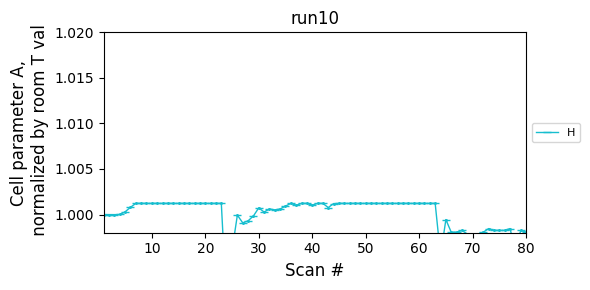

In [ ]:
# @title in-situ lattice parameter % change vs. time

from time import localtime, strftime
folderPath = '/content/refinementresults_20250513_003524.csv' #paste the folder path here
# give_title = 'run'
data_series_type = ['in-situ','depth'] #0 or 1
response = data_series_type[0] #!#!#!#!#!#!#!#!#!#
print('response =', response)
# define_surface = float('41.78')
# print('define_surface:',define_surface)
scale = 100 #either 1 or 100, depending on whether you're plotting weight fraction or percent
independent_scale = 1 #for depth scans, either 1 or 1000 (um or mm)
lw = 1 #3 #linewidth for the plotting

lst_data = []
with open(folderPath, mode = 'r') as file:
    csvFile = csv.DictReader(file)
    for lines in csvFile:
        #print(lines)
        lst_data.append(lines) #extract data from the file for python treatment

primary = []
# stage_height = []
hem_A = []
hem_C = []
###
count = 0
text = 'primary'
# extr_depth = lst_data[count+1][''].split('_')[-4].replace('mm','')
# depth = extr_depth.replace(',','.')
# print('whats this say:',float(depth))
# print(lst_data[count][text])
# print(type(lst_data[count][text]))
# print(float(lst_data[count][text]))
# print(type(float(lst_data[count][text])))
for lines in lst_data:
    primary.append(int(float((lst_data[count]['primary']))))
    if response == 'depth':
        extr_stage_height = lst_data[count][''].split('_')[-4].replace('mm','')
        stage_height.append(float(extr_stage_height.replace(',','.')))
    hem_A.append(float(lst_data[count]['Hematite_A'])) #case-sensitive
    hem_C.append(float(lst_data[count]['Hematite_C']))
    ###
    count = count + 1

primary = np.array(primary)
if response == 'depth':
    stage_height = np.array(stage_height)
hem_A = np.array(hem_A)
hem_C = np.array(hem_C)
###

# print('primary:',primary)
#print('stage_height:',stage_height)
# print(Q_wt_fe)
# print(Q_wt_w)
# print(Q_wt_m)
# print(Q_wt_h)

depth = []
ind = 0

if response == 'depth':
    for lines in lst_data:
        #print('count:',count)
        if stage_height[ind] == define_surface:
            depth.append(0)
        elif stage_height[ind] > define_surface:
            depth.append(stage_height[ind] - define_surface)
        else:
            depth.append(stage_height[ind] - define_surface) #depth.append(float('nan'))
        ind = ind + 1
    #print('depth:',depth)
    depth = np.array(depth)
####################### figure ########################
fs = 12
markersz = 5 #20
if response == 'depth':
    figsize = (2.5,5) #(3,5) #width with legend and ticks
else:
    figsize = (6,3)
fig, ax = plt.subplots(figsize=figsize, tight_layout=True)

phase_series = ['Fe', 'W', 'M', 'H']
phase_colors = ['tab:purple', 'tab:pink','tab:green','tab:cyan'] #lincol_ceo2 = 'tab:orange'
phaser_markers = ['.','3','+','_']
###
n_phases = len(phase_series)
print('len(phase_series):',n_phases)

for i, phase_series in enumerate(phase_series):
    print('i:',i)
    print('plotting the phase_series...',phase_series)
    if i == 0:
        print('do nothing')
    elif i == 1:
        print('do nothing')
    elif i == 2:
        print('do nothing')
    elif i == 3:
        y_A = hem_A
        y_C = hem_C
    ###
    else:
        print('phase missing from plotting')
if 1 == 1: #dummy if statement to separate these two sections
    if response == 'depth':
        independent_axis = depth #primary
    #     plt.scatter(y*scale,independent_axis*independent_scale, marker = '.', s = markersz, c = phase_colors[i])
    #     plt.plot(y*scale,independent_axis*independent_scale, marker = '.', c = phase_colors[i], linewidth = lw,label = phase_series)
    #     plt.xlabel("Weight %", fontsize=fs, color='k')
    #     ax.set_xlim(0, 1*scale)
    #     ax.invert_xaxis()
    #     plt.ylabel('Depth (um)', fontsize=fs) #"Scan #"
    #     ax.set_ylim(min(independent_axis*independent_scale), 1.1*np.nanmax(independent_axis*independent_scale)) #0
    #     #ax.set_yticklabels([])
    #     ax.invert_yaxis()

    #     print('step size:',1000*(independent_axis[1]-independent_axis[0]),'um')

    #     #plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1),ncol=n_phases,fontsize=6)
    #     plt.legend(loc='center left', bbox_to_anchor=(1, 1),fontsize=8)
    else:
        independent_axis = primary
        plt.ylabel('Scan #', fontsize=fs)
        plt.scatter(independent_axis*independent_scale,y_A/y_A[0], marker = '.', s = markersz, c = phase_colors[i])
        plt.plot(independent_axis*independent_scale,y_A/y_A[0], marker = phaser_markers[i], c = phase_colors[i], linewidth = lw,label = phase_series)

        # plt.scatter(independent_axis*independent_scale,y_C/y_C[0], marker = '.', s = markersz, c = phase_colors[i])
        # plt.plot(independent_axis*independent_scale,y_C/y_C[0], marker = phaser_markers[i], c = phase_colors[i], linewidth = lw,label = phase_series)

        # plt.scatter(independent_axis*independent_scale,y*scale, marker = phaser_markers[i], s = 50, c = phase_colors[i],label = phase_series)

        plt.ylabel("Cell parameter A,\n normalized by room T val", fontsize=fs, color='k')
        # ax.set_ylim(0, 1) #1*scale
        ax.set_ylim(0.998, 1.02)
        # ax.invert_xaxis()
        plt.xlabel('Scan #', fontsize=fs)
        # ax.set_xlim(min(independent_axis*independent_scale), 1.1*np.nanmax(independent_axis*independent_scale)) #0
        ax.set_xlim(min(independent_axis*independent_scale), np.nanmax(independent_axis*independent_scale))
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=8) #loc indicates the position of the box that you will provide the coordinates for with bbox_oto_anchor. 0 is the figure's left border, 1 is the right border

print('number of scans:',max(primary))



plt.title(give_title,fontsize=fs)
now = strftime("%Y%m%d_%H%M%S", localtime())
save_path = folderPath.replace('csv', 'png')
print('saving file to:',save_path)
plt.savefig(save_path)

if response == 'depth':
    txt_ypos = -.005 #0.85
    txt_xpos = .625 #1.15
    txt = 'surface @ y_stage=' + str(define_surface)
    plt.figtext(txt_xpos, txt_ypos, txt, wrap=True, horizontalalignment='center', fontsize=8)

# **3. Plotting laser and pyrometer plots**

Pyrometer start time: 03-03-2025 22:39:45  EDT (military)
x_max = 157.354


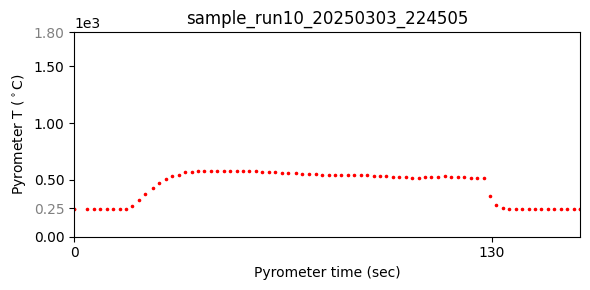

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/Shareddrives/Extraction_Subgroup_Data/NSLS-II_202503/NSLS-II_March_2025_Experiment/25_Mar_laser_logsandprograms/LOG-Mar.03-2025-10.43.56-run10.csv'

In [ ]:
#@title Load laser and pyrometer data
# wte2_laser_fp = '/content/run80_bulksample_repeat.csv'
# wte2_pyrom_fp = '/content/run80_bulksample_20240329-073328_31a7fa_primary.csv'
fn_pyrom = 'sample_run10_20250303_224505' #@param ["sample_run10_20250303_224505.xlsx","sample_run48_20250305_024949.xlsx","os.path.join(pyromdir, fn_pyrom + '.xlsx')","sample_52_20240622_184548"] {"type":"raw","allow-input":true}
fp_pyrom = os.path.join(pyromdir, fn_pyrom + '.xlsx')
# fn_pyrom = 'run80_bulksample_20240329-073328_31a7fa_primary' #'sample_run36_20250304_181215'
# fp_pyrom = fp_pyrom #os.path.join(pyromdir, fn_pyrom + '.xlsx')
fn_laser = 'LOG-Mar.03-2025-10.43.56-run10' #@param["LOG-Mar.03-2025-10.43.56-run10.csv","LOG-Mar.05.2025-02.46.100-run48.csv","os.path.join(laserdir, fn_laser + '.csv')", "LOG-Jun.22.2024-06.45.37-run49"] {"type":"raw","allow-input":true}
fp_laser= os.path.join(laserdir, fn_laser + '.csv')
# fn_laser = 'run80_bulksample_repeat' #LOG-Mar.04.2025-06.07.36-run36'
# fp_laser= wte2_laser_fp #os.path.join(laserdir, fn_laser + '.csv')



markersz = 10 #marker size for the figures

#################### pyrometer #####################################
result = process_pyrom(fp_pyrom)

figsize = (6, 3)
fs = 18
fig, ax = plt.subplots(figsize=figsize, tight_layout=True)
ax.set_ylim(0, 1800)
ax.set_yticks([0, 250, 500, 1000, 1500, 1800])
ax.set_xticks([0, 130, 161])
ax.get_yticklabels()[1].set_color("gray") #changing the color for 248C
ax.get_yticklabels()[5].set_color("gray") #changing the color for 1800C

plt.scatter(result[0], result[1], marker = '.', s = markersz, c = 'r')
x_max = np.array(result[0], dtype='float32').max()
print('x_max =', x_max)
ax.set_xlim(0, x_max)

plt.ylabel("Pyrometer T ($^\circ$C)")
plt.xlabel("Pyrometer time (sec)")
plt.title(fn_pyrom)
# plt.title(fp_pyrom)

plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.show()


###################### laser log ###################################
result = process_laserlog(fp_laser)

st = result[0]
lt = result[1]
recnum = result[2]
power = result[3]

x_axis_laser = [i * int(st) for i in recnum]
y_axis_laser = power
x_lim = max(np.array(x_axis_laser))
print('x_axis = ', x_axis_laser)


figsize = (6, 3)
fs = 18
fig, ax = plt.subplots(figsize=figsize, tight_layout=True)

#txt = 'The log began recording at ' + lt + ' with ' + st +' sec sampling \n t = 0 in the plot above is '+ t_xrd_start
plt.scatter(x_axis_laser, y_axis_laser, marker = '.', s = markersz, c = 'b')
plt.ylabel("Power supply input (W)")
plt.xlabel("Laser time (sec)")
plt.title(fn_laser)
# plt.title(fp_laser)
#plt.figtext(0.5, -.125, txt, wrap=True, horizontalalignment='center', fontsize=10)
ax.set_xlim(0, x_lim)
ax.set_yticks([0, 10, 20, 30, 40, 50])

Pyrometer start time: 03-04-2025 17:57:50  EDT (military)
The log's first data point was at: Mar 29 2024 4:25:56 AM and the sampling time is 1 sec

t_laser_sampling 1
Start times as pd.Timestamp. laser: 04:25:56 pyrom: 17:57:50
timestamp difference: start_laser - start_pyrom = -341 days +09:28:06
abs(deltat0_sec): 29428314 seconds
The laser log started recording first
index_offset_rounded: 29428314


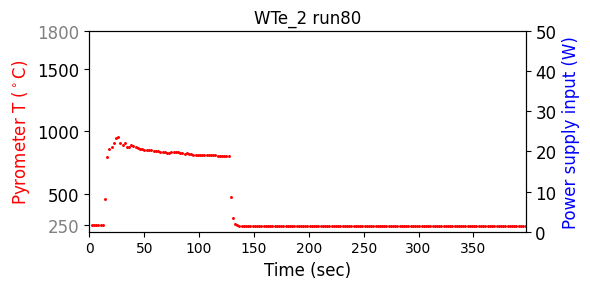

In [ ]:
#@title Combined plot: pyrometer/laser PS

#!#!#!#!#!#!#!#!#!# inputs #!#!#!#!#!#!#!#!#!#
#use fn_pyrom and fn_laser from the previous section
#in-situ XRD file: run58_realhematite_vac_IR
#plot title
title = "WTe_2 run80" # @param ["T_calib for IR/Ar, run 49","IR/H2, run 10"] {"allow-input":true}

import math
from datetime import datetime
#Timestamp is the pandas equivalent of python’s Datetime and is interchangeable with it in most cases. https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Timestamp.html

######################## plotting the combined figure #######################
figsize = (6, 3)
fs = 12
markersz = 5
col_pyrom = 'r'
col_laser = 'blue' #'navy'
fig, ax1 = plt.subplots(figsize=figsize, tight_layout=True)

plt.title(title)
ax1.set_xlabel("Time (sec)", fontsize=fs)

#### pyrometer axis ####
ax1.set_ylabel("Pyrometer T ($^\circ$C)", fontsize=fs, color=col_pyrom)
ax1.set_ylim(200, 1800)
ax1.set_yticks([250, 500, 1000, 1500, 1800])
ax1.get_yticklabels()[0].set_color("gray") #changing the color for 248C
ax1.get_yticklabels()[-1].set_color("gray") #changing the color for 1800C
ax1.tick_params(axis='y', labelsize=fs)

#### laser axis ****
ax2 = ax1.twinx()
ax2.set_ylabel('Power supply input (W)', fontsize=fs, color=col_laser)
ax2.set_yticks([0, 10, 20, 30, 40, 50])
ax2.tick_params(axis='y', labelsize=fs)

#plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

############ pyrometer ###################
result_pyrom = process_pyrom(fp_pyrom)
start_pyrom = result_pyrom[2] #pyrometer's t0
# start_pyrom_run36 = result_pyrom[3]
# start_pyrom = start_pyrom_run36
# print("I'm using run 36's defn of start time")
timestamp_start_pyrom = pd.Timestamp(start_pyrom, tz='America/New_York') #setting the format to Timestamp, from a string
x_max = np.array(result_pyrom[0], dtype='float32').max()
x_axis_pyrom = result_pyrom[0]
y_axis_pyrom = result_pyrom[1]
# y_axis_pyrom = result_pyrom['eurotherm_temperature']

############ laser log ###################
result_laser = process_laserlog(fp_laser)
string_start_laser = result_laser[1] #this is good now
# print('string_start_laser:',string_start_laser)
timestamp_start_laser = pd.Timestamp(string_start_laser, tz='America/New_York') #laser log's t0 (military time, matching the timezone we recorded in)
t_laser_sampling = int(result_laser[0]) #seconds per rec:index
print('t_laser_sampling', t_laser_sampling)
recnum = result_laser[2]
power = result_laser[3]

#convert to date time to avoid operation errors
print('Start times as pd.Timestamp. laser:', pd.Timestamp.timetz(timestamp_start_laser),'pyrom:',pd.Timestamp.timetz(timestamp_start_pyrom))
print('timestamp difference: start_laser - start_pyrom =',timestamp_start_laser - timestamp_start_pyrom)

deltat0_sec = np.timedelta64(timestamp_start_pyrom - timestamp_start_laser, 's')
print('abs(deltat0_sec):',abs(deltat0_sec))
if timestamp_start_laser < timestamp_start_pyrom:
    print('The laser log started recording first')
    index_offset_t0 = deltat0_sec / t_laser_sampling #finds the laser rec:index that corresponds to the pyrometer's t0.
    index_offset_t0_rounded = math.ceil(index_offset_t0.astype('timedelta64[s]').astype(float)) #if the index is a non-integer, then plot the first index AFTER the pyrometer's t0
    print('index_offset_rounded:',index_offset_t0_rounded)

    #don't need to find the index that corresponds to t_final_x_ray, since we'll just cut the plotting off at the pyrometer's x_max
    y_laser = power[index_offset_t0_rounded : recnum[-1]] #1+index_offset_t0_rounded:len(recnum)-1

    start = 0
    step = t_laser_sampling
    end = len(y_laser)
    x_laser = np.arange(start, end, step) #index_offset_t0 + #expressing laser data points in time, where t0 is set by the pyrometer


elif timestamp_start_pyrom <= timestamp_start_laser:
    print('The pyrometer started recording first')
    # t_pyrom_sampling = x_axis_pyrom[4]-x_axis_pyrom[3]
    # index_offset_t0 = deltat0_sec / t_pyrom_sampling #finds the pyrometer index that corresponds to the pyrometer's t0

    y_laser = power
    start = 0
    step = t_laser_sampling
    end = len(y_laser)
    x_laser = np.arange(start, end) * step - deltat0_sec.astype('timedelta64[s]').astype(float)

    # print('Scratch that. I've tested it now. I have yet to test that this cell works as intended. But it should work. Need to find an experiment that fits this though.')


# ax1.scatter(x_axis_pyrom, y_axis_pyrom, marker = '.', s = markersz, c = col_pyrom) #pyrometer
# ax1.set_xlim(0, x_max)
# ax2.scatter(x_laser, y_laser, marker = '.', s = markersz, c = col_laser) #laser log

x_axis_pyrom_run36 = x_axis_pyrom-356 #x_axis_pyrom[1]
x_max_run36 = x_max-356 #x_axis_pyrom[1]
x_laser_run36 = x_laser-356 #x_axis_pyrom[1]

ax1.scatter(x_axis_pyrom_run36, y_axis_pyrom, marker = '.', s = markersz, c = col_pyrom) #pyrometer
ax1.set_xlim(0, x_max_run36)
ax2.scatter(x_laser_run36, y_laser, marker = '.', s = markersz, c = col_laser) #laser log

plt.show()

In [ ]:
############ extracting data from the file ############
#@title process_pyrom_laser() (for methods manuscript)
#NOTE: Timestamp and datetime are two formats for expressing time and have their own methods. they are not compatible
def process_pyrom_laser(fp):
    '''
    Reads the pyrometer data for a given input file and expresses data points relative to t0
    '''
    # pyrom_data = pd.read_excel(fp)
    pyrom_data = pd.ExcelFile(fp)
    # for i in pyrom_data['pyrometer_sec']:
    #     x_axis_pyrom.append(dt_sec)
    #     #print('dt =', dt)
    # print('type=', type(dt))
    # print('type=', type(dt_sec))
    try:
        y_axis_pyrom = pyrom_data.parse('Sheet1')['eurotherm_T']
        x_axis_pyrom = pyrom_data.parse('Sheet1')['pyrometer_sec']
    except KeyError:
        print(f"Error: Column not found.")
        exit()

    # laser_data = pd.read_excel(fp)
    laser_data = pd.ExcelFile(fp)
    try:
        y_axis_laser = laser_data.parse('Sheet1')['Power_W']
        x_axis_laser = laser_data.parse('Sheet1')['laser_sec']
    except KeyError:
        print(f"Error: Column not found.")
        exit()

    # return x_axis_pyrom, y_axis_pyrom, start_datetime_new_york
    return x_axis_pyrom, y_axis_pyrom, x_axis_laser, y_axis_laser

x_max_pyrom: 161.0
x_max_laser: 134.0
x_max: 161.0


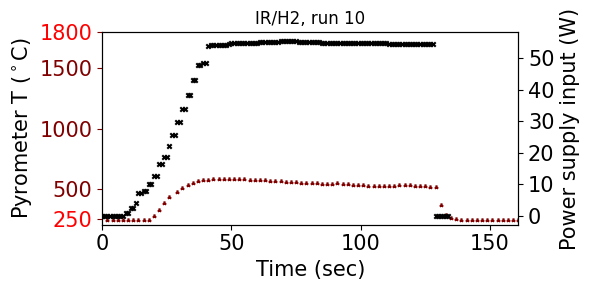

In [ ]:
#@title Combined plot: pyrometer/laser PS (for technique manuscript only)

title = "IR/H2, run 10" # @param ["T_calib for IR/Ar, run 49"] {"allow-input":true}

######################## plotting the combined figure #######################
figsize = (6, 3)
fs = 15 #12
markersz = 10 #20, 5
col_pyrom = 'maroon' #'r'
col_pyrom_lim = 'r' #'lightcoral'
col_laser = 'k' #'blue' #'navy'
fig, ax1 = plt.subplots(figsize=figsize, tight_layout=True)

plt.title(title)
ax1.set_xlabel("Time (sec)", fontsize=fs)
ax1.tick_params(axis='x', labelsize=fs)

#### pyrometer axis ####
ax1.set_ylabel("Pyrometer T ($^\circ$C)", fontsize=fs) #color=col_pyrom
ax1.set_ylim(200, 1800)
ax1.set_yticks([250, 500, 1000, 1500, 1800])
ax1.tick_params(axis='y', labelsize=fs, colors=col_pyrom)
ax1.get_yticklabels()[0].set_color(col_pyrom_lim) #changing the color for 248C
ax1.get_yticklabels()[-1].set_color(col_pyrom_lim) #changing the color for 1800C


#### laser axis ****
ax2 = ax1.twinx()
ax2.set_ylabel('Power supply input (W)', fontsize=fs) #color=col_laser
ax2.set_yticks([0, 10, 20, 30, 40, 50])
ax2.tick_params(axis='y', labelsize=fs, colors=col_laser)

#plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))


fp_combined_data = '/content/run10manualsyncvalues.xlsx'
result = process_pyrom_laser(fp_combined_data)
# for i in [0,1,2,3]:
#   print('i:', i)
#   print('result:',result[i])

############ pyrometer ###################
x_axis_pyrom = np.array(result[0], dtype='float32')
y_axis_pyrom = np.array(result[1], dtype='float32')
x_max_pyrom = np.nanmax(x_axis_pyrom)


############ laser log ###################
x_axis_laser = np.array(result[2], dtype='float32')
y_axis_laser = np.array(result[3], dtype='float32')
x_max_laser = np.nanmax(x_axis_laser)

if x_max_laser > x_max_pyrom:
    x_max = x_max_laser
else:
    x_max = x_max_pyrom
print('x_max_pyrom:',x_max_pyrom)
print('x_max_laser:',x_max_laser)
print('x_max:',x_max)

ax1.scatter(x_axis_pyrom, y_axis_pyrom, marker = '2', s = markersz, c = col_pyrom) #pyrometer
ax1.set_xlim(0, x_max)

ax2.scatter(x_axis_laser, y_axis_laser, marker = 'x', s = markersz, c = col_laser) #laser log

plt.show()

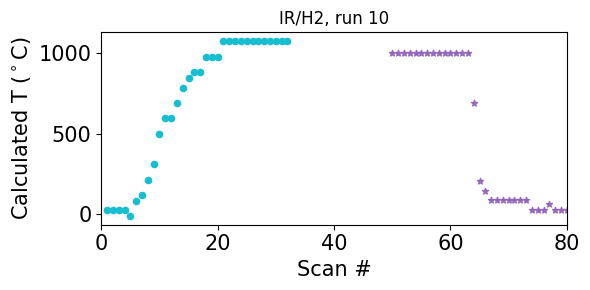

In [ ]:
#@title T from XRD (for technique manuscript only)

title = "IR/H2, run 10" # @param ["T_calib for IR/Ar, run 49"] {"allow-input":true}

######################## plotting the combined figure #######################
figsize = (6, 3)
fs = 15 #12
markersz = 20 #50, 20, 5
col_pyrom = 'maroon' #'r'
col_pyrom_lim = 'r' #'lightcoral'
col_laser = 'k' #'blue' #'navy'
fig, ax1 = plt.subplots(figsize=figsize, tight_layout=True)

plt.title(title)
ax1.set_xlabel("Scan #", fontsize=fs)
ax1.tick_params(axis='x', labelsize=fs)
ax1.set_ylabel("Calculated T ($^\circ$C)", fontsize=fs) #color=col_pyrom
ax1.tick_params(axis='y', labelsize=fs)



#plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))



ax1.scatter(primary, fe_T_calc, marker = '*', s = markersz, c = lincol_fe, label = 'Fe (110)') #pyrometer
ax1.set_xlim(0, primary[-1])

ax1.scatter(primary, new_array, marker = 'o', s = markersz, c = lincol_h, label = 'H (104)') #laser log
# plt.legend(bbox_to_anchor=(1, 0.5), loc='center left', fontsize=15)
plt.show()

In [ ]:
print(new_array)

[  25.           25.           25.           25.          -11.9107672
   82.11091133  119.13557067  213.51973064  308.15346572  498.17363059
  593.56205824  593.56205824  689.2040568   785.10063852  843.29977842
  881.25282106  881.25282106  977.6616275   977.6616275   977.6616275
 1074.3280864  1074.3280864  1074.3280864  1074.3280864  1074.3280864
 1074.3280864  1074.3280864  1074.3280864  1074.3280864  1074.3280864
 1074.3280864  1074.3280864            nan           nan           nan
           nan           nan           nan           nan           nan
           nan           nan           nan           nan           nan
           nan           nan           nan           nan           nan
           nan           nan           nan           nan           nan
           nan           nan           nan           nan           nan
           nan           nan           nan           nan           nan
           nan           nan           nan           nan           nan
          

In [ ]:
# # Initial array
# original_array = h_T_calc

# # Number of NaNs to add
# num_nans_to_add = 45

# # Create an array of NaNs
# nans_array = np.full(num_nans_to_add, np.nan)

# # Append the NaNs to the original array
# new_array = np.append(original_array, nans_array)

# print(new_array)

[  25.           25.           25.           25.          -11.9107672
   82.11091133  119.13557067  213.51973064  308.15346572  498.17363059
  593.56205824  593.56205824  689.2040568   785.10063852  843.29977842
  881.25282106  881.25282106  977.6616275   977.6616275   977.6616275
 1074.3280864  1074.3280864  1074.3280864  1074.3280864  1074.3280864
 1074.3280864  1074.3280864  1074.3280864  1074.3280864  1074.3280864
 1074.3280864  1074.3280864            nan           nan           nan
           nan           nan           nan           nan           nan
           nan           nan           nan           nan           nan
           nan           nan           nan           nan           nan
           nan           nan           nan           nan           nan
           nan           nan           nan           nan           nan
           nan           nan           nan           nan           nan
           nan           nan           nan           nan           nan
          

In [ ]:
#@title (ignore) Combined plot: calibrated T / incident laser power --- input the T and P offsets from the validated calibration
title = 'T_calib for IR/Ar, run 49' #plot title

figsize = (6, 3)
fs = 12
markersz = 5
col_pyrom = 'r'
col_laser = 'blue' #'navy'
fig, ax1 = plt.subplots(figsize=figsize, tight_layout=True)

plt.title(title)
ax1.set_xlabel("Time (sec)", fontsize=fs)

#### pyrometer axis ####
# ax1.set_ylabel("Pyrometer T ($^\circ$C)", fontsize=fs, color=col_pyrom)
# ax1.set_ylim(200, 1800)
# ax1.set_yticks([250, 500, 1000, 1500, 1800])
# ax1.get_yticklabels()[0].set_color("gray") #changing the color for 248C
# ax1.get_yticklabels()[-1].set_color("gray") #changing the color for 1800C
ax1.tick_params(axis='y', labelsize=fs)

#### laser axis ****
ax2 = ax1.twinx()
# ax2.set_ylabel('Power supply input (W)', fontsize=fs, color=col_laser)
# ax2.set_yticks([0, 10, 20, 30, 40, 50])
ax2.tick_params(axis='y', labelsize=fs)

#### calibrated values ####
# Toffset =
# Poffset =
# y_axis_pyrom_calib = _axis_pyrom + Toffset
# y_laser_calib = y_laser + Poffset

# ax1.scatter(x_axis_pyrom, y_axis_pyrom_calib, marker = '.', s = markersz, c = col_pyrom) #pyrometer
# ax1.set_xlim(0, x_max)

# ax2.scatter(x_laser, y_laser_calib, marker = '.', s = markersz, c = col_laser) #laser log

plt.show()

In [ ]:
#@title (ignore) Calibrated T --- will want to make this a comparison of the ceria-mix pellet: peak shift and the refinement methods


# ***Off-site analysis***

---




# **1. Diffraction pattern movies**

In [ ]:
#@title Movie of raw data: save frames
from time import localtime, strftime
print('remember to run "load in situ" first!!!')
#### inputs #####
print('number of files = ', raw_data_save_all.shape[0])
now = strftime("%Y-%m-%d_%H%M%S", localtime()) #note: this is expressed in UTC time
frame_folder = os.path.basename(run_folder) + '_mov_' + now # desired folder name for the frames
#save location for all of the frames
save_loc = os.path.join(userdir, 'user_analysis', 'xrd_movies', frame_folder) #@param ["os.path.join(userdir, 'user_analysis', 'xrd_movies', frame_folder)"]{"type":"raw"}


#### plot inputs  ####
figsize = (10, 6)
fs = 18
fig, ax = plt.subplots(2, figsize=figsize, tight_layout=True)
ax[1].set_xlabel(r'$q  ({\AA}^{-1})$', fontsize=fs)
ax[1].set_yticks([])
ax[1].tick_params(labelsize=fs)
ax[1].set_xlim([-.25,11])

#### generating frames ####
#print(timestamps) #timestamps and raw_data_save_all.shape should be equivalent ways of defining the number of frames for the movie!
# print(timestamps[0], timestamps[174])
frames = np.linspace(1, raw_data_save_all.shape[0], raw_data_save_all.shape[0]) #generate vector of n values from 1 to n
frames = [int(x) for x in frames]
print('frames=',frames)

Imax = raw_data_save_all[:,:,1].max() #finding the max intensity for the dataset. this is a reasonable since the number of scans (usually <250) is relatively small to the highest intensity observed throughout the full experiment
print('Imax =',Imax)

# ref_phases = ['Iron_2300200_q', 'Wustite_q','Lab_magnetite_q','Lab_hematite_q','67p_Fe_ore_q','Ceria_q','Chamber_background_450af9_q'] #add fayalite
# color_ref_phases = [lincol_fe, lincol_w, lincol_m, lincol_h, lincol_h_ore, lincol_ceo2,'tab:gray']
ref_phases = ['Iron_2300200_q', 'Wuestite_9009766_q','Lab_magnetite_q','Lab_hematite_q','bckgd_run10_ec721d_q.chi'] #add Wustite_q and ceria back and fayalite
color_ref_phases = [lincol_fe, lincol_w, lincol_m, lincol_h, 'tab:gray'] # lincol_ceo2

ref_shift_y = -1
for i_phase, ref_phase in enumerate(ref_phases):
    reffile = os.path.join(refsdir, ref_phase + '.txt')
    refdata = np.loadtxt(reffile)
    q_ref = refdata[:, 0]
    I_ref = refdata[:, 1]
    #here I will write background-subtracted raw data, then baseline after

    I_ref = I_ref - I_ref.min() #"baselining" the data
    I_ref = I_ref/(I_ref.max())  + ref_shift_y*(i_phase + 1) -5
    ax[1].plot(q_ref, I_ref, label= ref_phase, linewidth= lw, color= color_ref_phases[i_phase])
plt.legend(loc='upper right')

for frame in frames:
    rawdata = raw_data_save_all[frame-1, :, :]
    q = rawdata[:, 0]
    I = rawdata[:, 1]

    #print('Saving frame...!',frame,'/',raw_data_save_all.shape[0])
    fname_typ = frame_folder + '_' + str(frame) +'.png'

    #fig, ax = plt.subplots(figsize=figsize, tight_layout=True)
    ax[0].set_title(os.path.basename(run_folder) +'_frame#' + str(frame), fontsize=fs)
    ax[0].set_xlim([-.25,11])
    ax[0].set_xticks([])
    ax[0].set_ylim([-.25,Imax])
    ax[0].set_ylabel(r'$I$', fontsize=fs)
    ax[0].tick_params(labelsize=fs)
    my_data = ax[0].plot(q, I, linewidth = lw,color='tab:gray')
    os.makedirs(save_loc, exist_ok=True)

    plt.savefig(os.path.join(save_loc, fname_typ))
    ax[0].clear() #my_data.remove() # del my_data

print('Saved all frames to ',save_loc)

remember to run "load in situ" first!!!
number of files =  200
frames= [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200]
Imax = 509.6553421020508
Saved all f

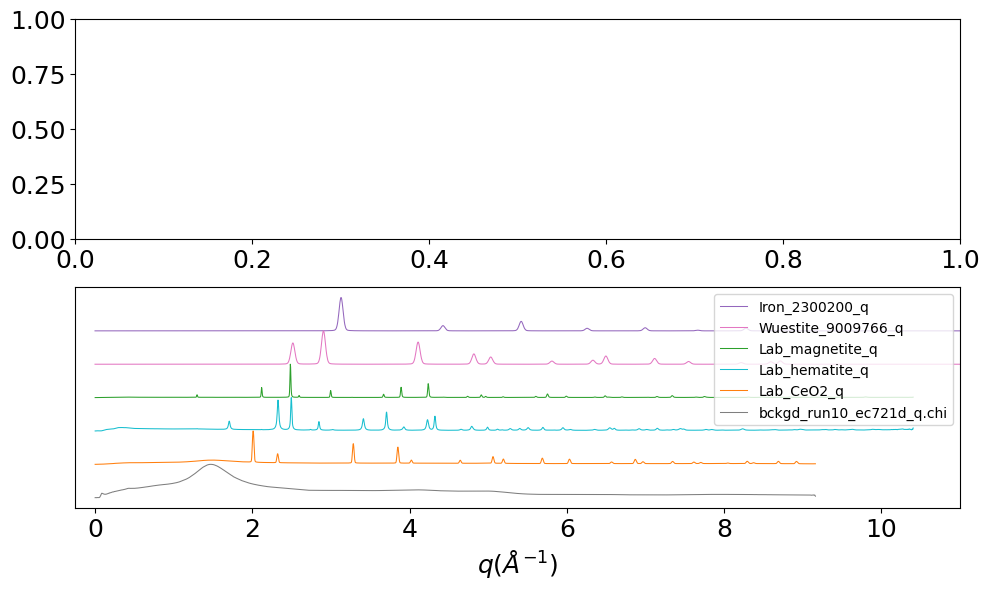

In [ ]:
#@title Movie of background-subtracted data: save frames
from time import localtime, strftime
print('remember to run "load in situ" first!!!')
#### inputs #####
print('number of files = ', raw_data_save_all.shape[0])
now = strftime("%Y-%m-%d_%H%M%S", localtime()) #note: this is expressed in UTC time
frame_folder = os.path.basename(run_folder) + '_mov_' + now # desired folder name for the frames
#save location for all of the frames
save_loc = os.path.join(userdir, 'user_analysis', 'xrd_movies', frame_folder) #@param ["os.path.join(userdir, 'user_analysis', 'xrd_movies', frame_folder)"]{"type":"raw"}


#### plot inputs  ####
figsize = (10, 6)
fs = 18
fig, ax = plt.subplots(2, figsize=figsize, tight_layout=True)
ax[1].set_xlabel(r'$q  ({\AA}^{-1})$', fontsize=fs)
ax[1].set_yticks([])
ax[1].tick_params(labelsize=fs)
ax[1].set_xlim([-.25,11])

#### generating frames ####
#print(timestamps) #timestamps and raw_data_save_all.shape should be equivalent ways of defining the number of frames for the movie!
# print(timestamps[0], timestamps[174])
frames = np.linspace(1, bkgdsub_data_save_all.shape[0], bkgdsub_data_save_all.shape[0]) #generate vector of n values from 1 to n
frames = [int(x) for x in frames]
print('frames=',frames)

Imax = bkgdsub_data_save_all[:,:].max() #finding the max intensity for the dataset. this is a reasonable since the number of scans (usually <250) is relatively small to the highest intensity observed throughout the full experiment
print('Imax =',Imax)

# ref_phases = ['Iron_2300200_q', 'Wustite_q','Lab_magnetite_q','Lab_hematite_q','67p_Fe_ore_q','Ceria_q','Chamber_background_450af9_q'] #add fayalite
# color_ref_phases = [lincol_fe, lincol_w, lincol_m, lincol_h, lincol_h_ore, lincol_ceo2,'tab:gray']
ref_phases = ['Iron_2300200_q', 'Wuestite_9009766_q','Lab_magnetite_q','Lab_hematite_q','Lab_CeO2_q','bckgd_run10_ec721d_q.chi'] #add Wustite_q and ceria back and fayalite
color_ref_phases = [lincol_fe, lincol_w, lincol_m, lincol_h, lincol_ceo2, 'tab:gray'] # lincol_ceo2

ref_shift_y = -1
for i_phase, ref_phase in enumerate(ref_phases):
    reffile = os.path.join(refsdir, ref_phase + '.txt')
    refdata = np.loadtxt(reffile)
    q_ref = refdata[:, 0]
    I_ref = refdata[:, 1]
    #here I will write background-subtracted raw data, then baseline after

    I_ref = I_ref - I_ref.min() #"baselining" the data
    I_ref = I_ref/(I_ref.max())  + ref_shift_y*(i_phase + 1) -5
    ax[1].plot(q_ref, I_ref, label= ref_phase, linewidth= lw, color= color_ref_phases[i_phase])
plt.legend(loc='upper right')

for frame in frames:
    rawdata = raw_data_save_all[frame-1, :, :]
    bkgdsubdata = bkgdsub_data_save_all[frame-1, :]
    q = rawdata[:, 0]
    I = bkgdsubdata #questionable

    #print('Saving frame...!',frame,'/',raw_data_save_all.shape[0])
    fname_typ = frame_folder + '_' + str(frame) +'.png'

    #fig, ax = plt.subplots(figsize=figsize, tight_layout=True)
    ax[0].set_title(os.path.basename(run_folder) +'_frame#' + str(frame), fontsize=fs)
    ax[0].set_xlim([-.25,11])
    ax[0].set_xticks([])
    ax[0].set_ylim([-.25,Imax])
    ax[0].set_ylabel(r'$I$', fontsize=fs)
    ax[0].tick_params(labelsize=fs)
    my_data = ax[0].plot(q, I, linewidth = lw,color='tab:gray')
    os.makedirs(save_loc, exist_ok=True)

    plt.savefig(os.path.join(save_loc, fname_typ))
    ax[0].clear() #my_data.remove() # del my_data

print('Saved all frames to ',save_loc)

video_name: run36_H2pyrom_mov_2025-07-24_005856.mp4
# of images: 200
Done generating movie! Remember to download from Colab!


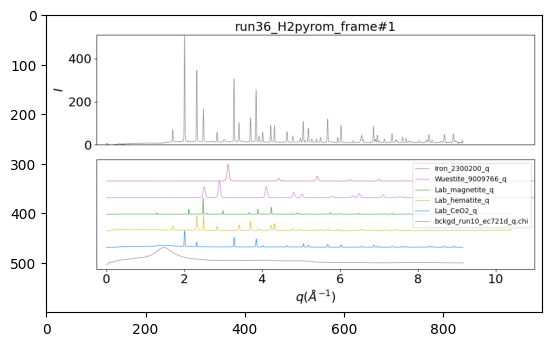

In [ ]:
#@title Generate movie
#reference: https://stackoverflow.com/questions/44947505/how-to-make-a-movie-out-of-images-in-python
#https://stackoverflow.com/questions/73609006/how-to-create-a-video-out-of-frames-without-saving-it-to-disk-using-python

import cv2
import os
image_folder = save_loc
video_name = frame_folder + '.mp4'
print('video_name:',video_name)

images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
# print('images:',images)
print('# of images:',len(images))

frame1 = cv2.imread(os.path.join(image_folder, images[0]))
plt.imshow(frame1)
#print('frame1 read from file located here:',os.path.join(image_folder, images[0]))
height, width, layers = frame1.shape
#print('h, w, l =',frame1.shape)

#video = cv2.VideoWriter(video_name, 0, 1, (width,height))
fourcc = cv2.VideoWriter_fourcc(*'mp4v') #*'XVID'
video = cv2.VideoWriter(video_name, fourcc, 3, (width, height),1) #(width, height)

for image in images:
    #video.write(cv2.imread(os.path.join(image_folder, image)))
    #temp = cv2.imread(os.path.join('/content/drive/Shareddrives/leoradm_group/NSLS-II_202406/userAnalysis/movies_insitu', image))
    temp = cv2.imread(os.path.join(image_folder, image))
    if temp is not None:  #check if the image was read correctly
        video.write(temp)

video.release()
# cv2.destroyAllWindows() this doesn't seem to be necessary within jupyter

#print('image_folder (where we want to write the video):',image_folder)
print('Done generating movie! Remember to download from Colab!')

# **2. Color map for waterfall**

In [ ]:
#@title Color map for waterfall, for manuscript (no refs plotted and will be background subtracted)
print('remember to run "load in situ" first!!!')
#if dataset needs to magnify very small differences
def log_base_10000(x):
    return np.log10(x) / np.log10(10000)
    #if x > 0 else np.nan

# Assuming raw_data_save_all contains q and intensity in the last dimension
print('remember to run "load in situ first!!!')
q_values = raw_data_save_all[0, :, 0]  # Assuming q is in the first column
I_data = np.array([raw_data_save_all[i, :, 1] for i in range(len(timestamps))])  # Extract intensity data
# print('I_data:',I_data)


# Transform intensity data into log scale
# print('most negative intensity in dataset:',I_data.min())
# I_data_mod = np.array([x+2 for x in I_data])
# print('I_data_mod:',I_data_mod)
# # print('test:',[math.log(x) for x in [1,2,3,4]])
# log_values = np.array([log_base_10000(x) for x in I_data_mod])
# I_data_log = log_values
I_data_log = np.log(I_data)
# I_data_plot = I_data_log
I_data_plot = np.sqrt(I_data)

#transform into supported array shape for image

### adding the ref phases ###
ref_phases = ['Iron_2300200_q', 'Wuestite_9009766_q','Lab_magnetite_q','Lab_hematite_q']
color_ref_phases = [lincol_fe, lincol_w, lincol_m, lincol_h]

# Create the intensity map

########################## set up the subplots ##########################
mainplot_ratio = 1
fs = (6,8) #set figsize

# f, (a0, a1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [3, 1]})
f, axes = plt.subplots(1, 1)
# axes[0].set_xticks([])
# plt.subplots(1+num_ref_subplots, 1, gridspec_kw={'height_ratios': defn_height_ratios}, figsize=fs) #'width_ratios' #axes=(a0, a_fe, a_feo)

######################### plot the data series as an intensity color map, excluding the references
extent_for_series = [q_values.min(), q_values.max(), 0, len(timestamps)]
im = axes.imshow(I_data_plot, cmap='magma', aspect='auto', extent=extent_for_series,
                    origin='lower') #origin='lower'
# customize the plot
y_ticks = np.arange(len(timestamps))
n = 2 #for every nth tick
axes.set_yticks(y_ticks[::n])  # Adjust '5' to 'n' for every nth tick    #ax.set_yticks(np.arange(len(timestamps)))
axes.set_yticklabels([str(int(ts.split('-')[-1])) for ts in timestamps[::n]])  # Label with scan numbers. use only corresponding labels #reversed(timestamps[::n])

axes.set_title(os.path.basename(run_folder) + ' ' + response + ' series', fontsize=18)
axes.set_xlabel(r'$q  ({\AA}^{-1})$', fontsize=18)
axes.set_ylabel("Scan Number", fontsize=18)


# Add a colorbar at the end of plotting all of the data
cbar = plt.colorbar(im, label="Intensity (a.u.)", orientation="vertical") # fontsize=16,
# cbar.set_label('Intensity (log scale)', fontsize=16)


remember to run "load in situ" first!!!
number of reference phases to plot: 4
[0 1 2 3 4]


/tmp/ipython-input-3197388925.py:11: RuntimeWarning: invalid value encountered in log
  I_data_log = np.log(I_data)
/tmp/ipython-input-3197388925.py:12: RuntimeWarning: invalid value encountered in sqrt
  I_data_sqrt = np.sqrt(I_data)


'\n########## plot the reference data\nfor i_phase, item in enumerate(ref_phases):\n    print(\'i_phase, item \n\')\n    print(i_phase, item)\n    reffile = os.path.join(refsdir, item + \'.txt\')\n    print(\'reffile:\',reffile)\n    refdata = np.loadtxt(reffile)\n    q_ref_raw = refdata[:, 0]\n    I_ref_raw = refdata[:, 1]\n    I_log = np.log(I_ref_raw+1) #we add a number here so that we can obtain the log of the dataset (which initially contains 0)\n    # # print(\'I_log:\',I_log)\n    I_ref = I_log-I_log.min()\n    I_plot = I_ref\n    ############# axes[i_phase].plot(x,y)\n    #the first dataset is the waterfall series, so skip this plot\n    ##### we\'re cool down to here\n    print(\'max:\',max(I_ref))\n    print(\'min:\',min(I_ref))\n\n    #transforming the ref phase data into a grid-like structure\n    # I_plot = np.expand_dims(I_ref, axis=0) #expand the dimension so that imshow doesn\'t give an error for the linear array\n    ref_img_array = np.zeros((2, len(q_ref_raw)))\n    f

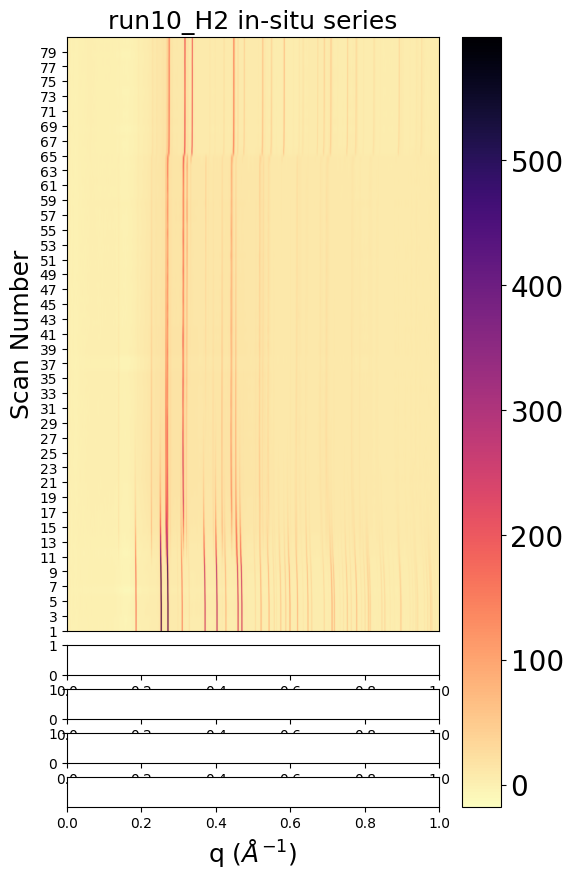

In [ ]:
#@title Color map for waterfall (in progress)
# Assuming raw_data_save_all contains q and intensity in the last dimension
print('remember to run "load in situ" first!!!')
q_values = raw_data_save_all[0, :, 0]  # Assuming q is in the first column
# I_data = np.array([raw_data_save_all[i, :, 1] for i in range(len(timestamps))])  # Extract intensity data
# print('shape of I_data:',np.shape(I_data))
I_data = np.array([bkgdsub_data_save_all[i,:] for i in range(len(timestamps))])


# Transform intensity data into log scale
I_data_log = np.log(I_data)
I_data_sqrt = np.sqrt(I_data)

#transform into supported array shape for image

### adding the ref phases ###
# ref_phases = ['Lab_hematite_q']
# color_ref_phases = [lincol_h]
ref_phases = ['Iron_2300200_q', 'Wuestite_9009766_q','Lab_magnetite_q','Lab_hematite_q']
color_ref_phases = [lincol_fe, lincol_w, lincol_m, lincol_h]

# Create the intensity map

########################## set up the subplots ##########################
mainplot_ratio = 1
refs_factor = 5
fs = (6,10) #set figsize
sbplt_spacing = 0.1
num_ref_subplots = len(ref_phases) #ie number of reference phases
print('number of reference phases to plot:', num_ref_subplots)
#### inputs are above this line ####

a_refs_ratio = mainplot_ratio/(refs_factor*num_ref_subplots)
my_list = [mainplot_ratio] #initiate and set the ratio for the first plot
for i in range(num_ref_subplots): #automatically changes "height_ratios" according to the number of reference phases
    # print('i:',i)
    my_list.append(a_refs_ratio)
defn_height_ratios = my_list
# defn_height_ratios = [3, a_refs_ratio, a_refs_ratio] #for 2 reference phases

# f, (a0, a1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [3, 1]})
f, axes = plt.subplots(1+num_ref_subplots, 1, gridspec_kw={'height_ratios': defn_height_ratios}, figsize=fs) #'width_ratios' #axes=(a0, a_fe, a_feo)
plt.subplots_adjust(hspace=sbplt_spacing) #wspace=0.4,
arr = np.linspace(0,num_ref_subplots,num_ref_subplots+1,dtype=int)
print(arr)
# print('arr type:', type(arr))
list_arr = arr.tolist()

for ind in arr: #create the subplots and only give y-axis for the first dataset (the waterfall series) and x-axis for last dataset
    # print(ind)
    ############# axes[ind].plot(x,y)
    if ind != 0 and ind != list_arr[-1]:
        # axes[ind].set_xticks([]) ##reset once done playing
        # axes[ind].set_yticks([]) # axes[ind].set_ylabel(None) #reset once done playing
        ay = 1
    elif ind == 0:
        axes[ind].set_xticks([])
    elif ind == list_arr[-1]:
        axes[ind].set_yticks([])

######################### plot the data series as an intensity color map, excluding the references
extent_for_series = [q_values.min(), q_values.max(), 0, len(timestamps)]
im = axes[0].imshow(I_data, extent=extent_for_series, cmap='magma_r', aspect='auto',
                    origin='lower') #origin='lower'
                    #I_data_log, magma_r, plasma_r
cbar = f.colorbar(im, ax=axes, location='right')
cbar.ax.tick_params(labelsize=20)

# customize the plot
y_ticks = np.arange(len(timestamps))
n = 2 #for every nth tick
axes[0].set_yticks(y_ticks[::n])  # Adjust '5' to 'n' for every nth tick    #ax.set_yticks(np.arange(len(timestamps)))
axes[0].set_yticklabels([str(int(ts.split('-')[-1])) for ts in timestamps[::n]])  # Label with scan numbers. use only corresponding labels #reversed(timestamps[::n])

axes[0].set_title(os.path.basename(run_folder) + ' ' + response + ' series', fontsize=18)
axes[list_arr[-1]].set_xlabel(r'q (${\AA}^{-1}$)', fontsize=18)
axes[0].set_ylabel("Scan Number", fontsize=18)

'''
########## plot the reference data
for i_phase, item in enumerate(ref_phases):
    print('i_phase, item \n')
    print(i_phase, item)
    reffile = os.path.join(refsdir, item + '.txt')
    print('reffile:',reffile)
    refdata = np.loadtxt(reffile)
    q_ref_raw = refdata[:, 0]
    I_ref_raw = refdata[:, 1]
    I_log = np.log(I_ref_raw+1) #we add a number here so that we can obtain the log of the dataset (which initially contains 0)
    # # print('I_log:',I_log)
    I_ref = I_log-I_log.min()
    I_plot = I_ref
    ############# axes[i_phase].plot(x,y)
    #the first dataset is the waterfall series, so skip this plot
    ##### we're cool down to here
    print('max:',max(I_ref))
    print('min:',min(I_ref))

    #transforming the ref phase data into a grid-like structure
    # I_plot = np.expand_dims(I_ref, axis=0) #expand the dimension so that imshow doesn't give an error for the linear array
    ref_img_array = np.zeros((2, len(q_ref_raw)))
    for i in range(len(q_ref_raw)):
        # print('i:',i)
        ref_img_array[0,i] = I_plot[i]
    # print('ref_img_array:',ref_img_array)
    print('its shape:',np.shape(ref_img_array))
    print('len q:',len(q_ref_raw))
    print('len I_plot:',len(I_plot))
    print('len y:',len(timestamps))
    extent_for_ref = [q_ref_raw[0], q_ref_raw[-1], 0, 2] # [x_mesh[0], x_mesh[-1], y_mesh[0], y_mesh[-1]]#[0.1, 9, 0, 1]
    im = axes[i_phase+1].imshow(ref_img_array, extent = 'extent_for_ref', cmap='magma_r', aspect='auto') #[q_values.min(), q_values.max(), 0, max(I_ref)] #origin='lower'
    # plt.plot(q_ref_raw,I_ref, label=f'Ref {i_phase +1}', alpha=0.7)


# Add a colorbar at the end of plotting all of the data
cbar = plt.colorbar(im, label="Intensity (log scale)", orientation="horizontal") # fontsize=16,
# cbar.set_label('Intensity (log scale)', fontsize=16)
'''

In [ ]:
#@title playing around to set up subplots
# generate some data
x = np.arange(0, 10, 0.2)
y = np.sin(x)

fs = (10,6) # figsize
mainplot_ratio = 1
refs_factor = 5
num_ref_subplots = 4 #ie number of reference phases
print('number of reference phases to plot:', num_ref_subplots)

a_refs_ratio = mainplot_ratio/(refs_factor*num_ref_subplots)
my_list = [mainplot_ratio] #initiate and set the ratio for the first plot
for i in range(num_ref_subplots): #automatically changes "height_ratios" according to the number of reference phases
    # print('i:',i)
    my_list.append(a_refs_ratio)
defn_height_ratios = my_list
# defn_height_ratios = [3, a_refs_ratio, a_refs_ratio] #for 2 reference phases

# f, (a0, a1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [3, 1]})
f, axes = plt.subplots(1+num_ref_subplots, 1, gridspec_kw={'height_ratios': defn_height_ratios}, figsize=fs) #'width_ratios' #axes=(a0, a_fe, a_feo)
plt.subplots_adjust(hspace=0.1) #wspace=0.4,
arr = np.linspace(0,num_ref_subplots,num_ref_subplots+1,dtype=int)
print(arr)
# print('arr type:', type(arr))
list_arr = arr.tolist()
# print(list_arr[-1]) #last item in the array

for ind in arr: #plot the data and only give y-axis for the first dataset and x-axis for last dataset
    # print(ind)
    axes[ind].plot(x,y)
    if ind != 0 and ind != list_arr[-1]:
        axes[ind].set_xticks([])
        axes[ind].set_yticks([]) # axes[ind].set_ylabel(None)
    elif ind == 0:
        axes[ind].set_xticks([])
    elif ind == list_arr[-1]:
        axes[ind].set_yticks([])


# f.tight_layout()
# f.savefig('grid_figure.pdf')
# ############################################################
# # Customize the skinny subplot
# # ax_ref.set_xlim(q_values.min(), q_values.max())
# ax_ref.set_ylabel('Reference Data', fontsize=12)
# ax_ref.set_xticklabels([])  # Optionally hide x-axis labels

# # Optional: Customize y-axis ticks for clarity
# ax_ref.set_yticks([])  # Adjust as necessary
# ax_ref.legend(loc='upper right')



# # Show plot
# plt.tight_layout()
# plt.show()

# **3. Peak-finding for phase-representative peaks**

In [ ]:
#@title Peak-finding inputs: target peak positions and range
#may need to tune the idx_shiftlower/upper and prominence values for each experiment
wavelength = 0.1819 #angstrom
wf_shift_coefficient = 20 #2
# wf_shift = iv*wf_shift_coefficient

#ref_q_fe = [3.128, 5.419, 4.424, 6.995, 8.277, 6.257, 7.663]
#ref_q_fe = [3.128, 5.419, 4.424]
ref_q_fe = [3.128] #prominent isolated phase peak
fe_idx_shiftlower = 35 #xx indices below the index at the room temperature peak
fe_idx_shiftupper = 5 #xx indices above
prominence_fe = 18


#ref_q_w = [2.905, 4.108, 2.516, 4.817, 6.495, 5.031, 7.115, 6.331, 8.715, 8.593, 7.547, 8.216, 5.810]
#ref_q_w = [2.905, 4.108, 2.516]
ref_q_w = [4.108] #prominent isolated phase peak
w_idx_shiftlower = 30
w_idx_shiftupper = 15 #12 #20 still caught the right neighboring peak #8 range not broad enough
prominence_w = 30


#ref_q_m = [2.4783, 2.5973, 4.2458, 3.8889, 2.1214, 2.9982, 5.7584, 3.6680, 1.2887, 4.9086]
#ref_q_m = [2.4783, 2.5973, 4.2458]
ref_q_m = [2.1214] #prominent isolated phase peak
m_idx_shiftlower = 25
m_idx_shiftupper = 5
prominence_m = 15

#ref_q_h = [2.4985, 2.3135, 3.7118, 4.3288, 3.41365, 4.2259, 1.6965, 2.8481, 4.8017, 3.92775, 4.9868, 5.6860, 5.5009, 5.9533, 6.5394]
#ref_q_h = [2.4985, 2.3135, 3.7118]
ref_q_h = [2.3135] #prominent isolated phase peak
h_idx_shiftlower = 15
h_idx_shiftupper = 15
prominence_h = 20

#ref_q_ceo2 = [2.013, 2.324, 3.287, 3.854, 4.025, 4.648, 5.065, 5.197, 5.693, 6.038]
ref_q_ceo2 = [2.013]
prominence_ceo2 = 30

ref_q_cem=[3.37, 3.38, 3.028 ] #cementite peaks

print('\n remember to make note of the starting peak position, the lower/upper shifts, and the prominence values that you land on!')


 remember to make note of the starting peak position, the lower/upper shifts, and the prominence values that you land on!


In [ ]:
# @title (outdated, singular inputs) Peak-finding and writing results to table
#modified from NSLS-II_202406 > userScripts > beamline_analysis.ipynb
#here, we perform the find peaks function on the background-subtracted data
print('remember to run "load in situ" first to get raw_data_save_all and bkgdsub_data_save_all!!!')

### inputs ###
phasepks = ['fe'] #@param ["['fe']","['w']","['m']","['h']","['fe', 'w', 'm', 'h', 'ceo2']"]{"type":"raw"}
# targetpk = ref_q_fe #@param [ref_q_fe]
targetpk = ref_q_fe #ref_q_fe, ref_q_w, ref_q_m, ref_q_h
pk_idx_shiftlower = fe_idx_shiftlower #fe_idx_shiftlower, w_idx_shiftlower, m_idx_shiftlower, h_idx_shiftlower
pk_idx_shiftupper = fe_idx_shiftupper #fe_idx_shiftupper, w_idx_shiftupper, m_idx_shiftupper, h_idx_shiftupper
pk_prom = prominence_fe #prominence_fe, prominence_w, prominence_m, prominence_h
###        ###

find_peak_write_table = []

################ finding peaks ######################################
q_values = np.array([raw_data_save_all[i, :, 0] for i in range(len(timestamps))]) #raw_data_save_all[0, :, 0]  # Assuming q is in the first column and I is in the 2nd column
I_bkgdsubdata = np.array([bkgdsub_data_save_all[i, :] for i in range(len(timestamps))])  # Extract intensity data
# print('shape of I_data', np.shape(I_data))
counting = 0
# find_peak_outputs = []

print('reading from bkgdsub_data_save_all')
for iv, timestamp in enumerate(raw_data_save_all[:, 0, 0]):
    # print(iv)
    timestamp_num = iv+1
    q = q_values[iv]
    I = I_bkgdsubdata[iv,:] #bkgdsub_data_save_all array is:  (80, 3000)

    counting = counting + 1
    ################################### find peaks ############################################
    #defining the range for find peaks
    ### iron or some other phase peak ###
    idx = np.argmin(np.abs(q - targetpk)) #index of nearest value to the input value
    pk_idx_lower = idx-pk_idx_shiftlower
    pk_idx_upper = idx+pk_idx_shiftupper

    for iii in phasepks: #repeat this process for each phase
        #print('iii = ', iii)
        ############ for peak iii ####################
        if iii == phasepks[0]:
            val1_pk, val2_pk, properties, peaks = find_pk_phase(I,pk_idx_lower,pk_idx_upper, pk_prom)
            # print(properties)
            if not val2_pk == 0:
                pk_idx = peaks #the index of the identified peak #equivalently, pk_idx = np.argmin(np.abs(q[pk_idx_lower:pk_idx_upper] - val1_pk))
                q_miniarray = q[pk_idx_lower:pk_idx_upper]
                I_miniarray = I[pk_idx_lower:pk_idx_upper]
                # print('pk_idx:',pk_idx)
                # print('I_miniarray:',I_miniarray)

                fwhms_in_samples, fwhm_heights, leftfwhm_ips_samples, rightfwhm_ips_samples = peak_widths(I_miniarray,pk_idx, rel_height=0.5)
                left_q_coords = np.interp(leftfwhm_ips_samples, np.arange(len(q_miniarray)), q_miniarray)
                right_q_coords = np.interp(rightfwhm_ips_samples, np.arange(len(q_miniarray)), q_miniarray)
                fwhm_in_q_units = right_q_coords - left_q_coords
                # print('left_q_coords:',left_q_coords)
                # print('right_q_coords:',right_q_coords)

                fw_in_samples, fw_heights, leftfw_ips_samples, rightfw_ips_samples = peak_widths(I_miniarray,pk_idx, rel_height=1.0)
                leftfw_q_coords = np.interp(leftfw_ips_samples, np.arange(len(q_miniarray)), q_miniarray)
                rightfw_q_coords = np.interp(rightfw_ips_samples, np.arange(len(q_miniarray)), q_miniarray)
                fw_in_q_units = rightfw_q_coords - leftfw_q_coords

                if len(fwhm_in_q_units) >1:
                    print('assuming unimodal distribution for simplicity (assuming this only in the code development mode)')
                    print('take the higher intensity peak (default), or manually set the integral bounds later on')
                    idx_maxheight = np.argmax(fw_heights)

                    left_q_coords = left_q_coords[idx_maxheight]
                    right_q_coords = right_q_coords[idx_maxheight]
                    fwhm_in_q_units = fwhm_in_q_units[idx_maxheight]
                    fwhm_heights = fwhm_heights[idx_maxheight]

                    leftfw_q_coords = leftfw_q_coords[idx_maxheight]
                    rightfw_q_coords = rightfw_q_coords[idx_maxheight]
                    fw_in_q_units = fw_in_q_units[idx_maxheight]
                    fw_heights = fw_heights[idx_maxheight]
                # print('pk_wid:',fwhm_in_q_units)
                # print('fwhm_heights:',fwhm_heights)

            if val2_pk == 0:
                left_q_coords = right_q_coords = fwhm_in_q_units = fwhm_heights = float('nan')
                leftfw_q_coords = rightfw_q_coords = fw_in_q_units = fw_heights = float('nan')

            if iv == 63: #uncomment this when you want to get a sense for the peak prominence at a specific time point
                print('the intensity of this peak is at this time is:', val2_pk)

        #set the values here for this one timestamp
        # find_peak_write_table_row = {''}

        # item = {'Scan#': timestamp_num,
        #     'Fe': [val1_fe, val2_fe]
        #         }
        item = {'Scan #': timestamp_num,
                'pk1: idxs, qs, prom, outputs':[[int(pk_idx_lower),int(pk_idx_upper)], [float(q[pk_idx_lower]),float(q[pk_idx_upper])], pk_prom, [float(val1_pk), float(val2_pk),float(left_q_coords),float(right_q_coords),float(fwhm_in_q_units), float(fwhm_heights), float(leftfw_q_coords), float(rightfw_q_coords), float(fw_heights)]]
                } #remember to format the data as floats/integers in your table
        find_peak_write_table.append(item)

df = pd.DataFrame(find_peak_write_table) #find_peak_outputs
df.to_csv("findpeaks_output.csv", index=False)
print('\n remember to save findpeaks_output.csv from Colab!')

remember to run "load in situ" first to get raw_data_save_all!!!
ref_phases: ['Iron_2300200_q', 'Wuestite_9009766_q', 'Lab_magnetite_q', 'Lab_hematite_q']
shape of bkgdsub_data_save_all: (80, 3000)
plotting from bkgdsub_data_save_all
at this time point...

the lower bound is at q= 4.017546140658195 I= 14.24554443359375
the intensity of the identified peak is: 147.01581573486328


(-0.5, 9.5)

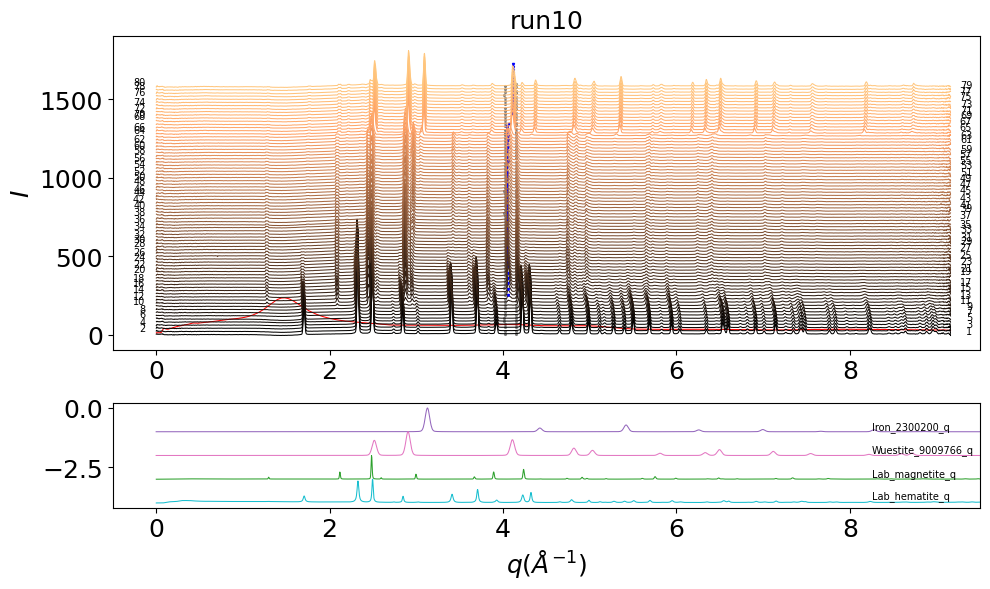

In [ ]:
# @title Plotting waterfall: with background subtraction and findpeaks result
#modified from NSLS-II_202406 > userScripts > beamline_analysis.ipynb
print('remember to run "load in situ" first to get raw_data_save_all!!!')

################# create figure object -- plotting settings ####################
#figsize = (12, 6)
figsize = (10, 6)
fs = 18
line_label_fs = 7
fig, ax = plt.subplots(2,1,figsize=figsize, gridspec_kw={'height_ratios': [3,1]}, tight_layout=True)

ax[1].set_xlabel(r'$q  ({\AA}^{-1})$', fontsize=fs)
ax[0].set_ylabel(r'$I$', fontsize=fs)
ax[0].set_title('run10', fontsize=fs)
ax[0].tick_params(labelsize=fs)
ax[1].tick_params(labelsize=fs)

mark_dist = 0
markersz = 1.5
markersh = 'v'


######################## load multiple reference files #########################
# ref_phases = ['Iron_2300200_q']
# color_ref_phases = [lincol_fe]
ref_phases = ['Iron_2300200_q', 'Wuestite_9009766_q','Lab_magnetite_q','Lab_hematite_q']
color_ref_phases = [lincol_fe, lincol_w, lincol_m, lincol_h]
# ref_phases = ['Iron_2300200_q', 'Wuestite_9009766_q','Lab_magnetite_q','Lab_hematite_q','67p_Fe_ore_q']
# color_ref_phases = [lincol_fe, lincol_w, lincol_m, lincol_h, lincol_h_ore]
# ref_phases = ['Iron_2300200_q', 'Wuestite_9009766_q','Lab_magnetite_q','Lab_hematite_q','67p_Fe_ore_q','Ceria_1562989_q']
# color_ref_phases = [lincol_fe, lincol_w, lincol_m, lincol_h, lincol_h_ore, lincol_ceo2]
print('ref_phases:',ref_phases)

################ plotting ########################################################
a, b = np.shape(bkgdsub_data_save_all)
print('shape of bkgdsub_data_save_all:',np.shape(bkgdsub_data_save_all))
num_of_lines = a #number of timestamps that will be plotted
lincol_gradient = iter(cm.copper(np.linspace(0,1,num_of_lines))) #Wistia, copper, and autumn are nice gradients
counting = 0

background = bkgd_data
q_bkgd = bkgd_data[:,0]
I_bkgd = bkgd_data[:,1]
ax[0].plot(q_bkgd, I_bkgd-(0.05*wf_shift_coefficient), color = 'r', linewidth = lw) #plot background


print('plotting from bkgdsub_data_save_all')
for iv, timestamp in enumerate(raw_data_save_all[:, 0, 0]):
    # print(iv)
    timestamp_num = iv+1
    q = raw_data_save_all[iv,:,0]
    I_plot = bkgdsub_data_save_all[iv,:] #bkgdsub_data_save_all array is:  (80, 3000)


    ############## plot waterfall data ######################
    c=next(lincol_gradient)
    wf_shift = iv*wf_shift_coefficient
    '''
    if iv == laser[0] or iv == laser[1] or iv == laser[2]: #condition for whether this is a scan when something important happens with the laser
        ax[0].plot(q, I_plot, color = 'r', linewidth = lw)
    else:
        ax[0].plot(q, I_plot, color = c, linewidth = lw) #here, Lauren!
    '''
    ax[0].plot(q, I_plot + wf_shift, color = c, linewidth = lw)
    if iv % 2 != 0: #placing the label on either the left or right of the data
        # print("The number is odd")
        ax[0].text(q[0]-.125, I_plot[-1]+wf_shift, timestamp_num, ha='right', va='bottom', fontsize = line_label_fs)
    else:
        ax[0].text(q[-1]+.25, I_plot[-1]+wf_shift, timestamp_num, ha='right', va='bottom', fontsize = line_label_fs)

    counting = counting + 1
    ################################### plotting find peaks inputs/outputs #########################################
    for iii in phasepks: #repeat this process for each phase
        #print('iii = ', iii)

        ############for iron#############################
        if iii == phasepks[0]:
            pk_idx_lower = int(pk1_idxs[iv,0]) #int(array[0])
            pk_idx_upper = int(pk1_idxs[iv,1]) #int(array[1])
            # print('type of idx:',type(pk_idx_lower))
            ax[0].scatter(q[pk_idx_lower], I_plot[pk_idx_lower]+wf_shift, color='tab:gray', s = markersz) #iron lincol_fe, lincol_h
            ax[0].scatter(q[pk_idx_upper], I_plot[pk_idx_upper]+wf_shift, color='tab:gray', s = markersz)
            ax[0].plot(pk1_outputs[iv,0],pk1_outputs[iv,1] + wf_shift + mark_dist, color = 'b', marker=markersh, markersize = markersz) #array[-2], array[-1]

            if iv == 63: #uncomment this when you want to get a sense for the peak prominence at a specific time point
                print('at this time point...\n')
                print('the lower bound is at q=', q[pk_idx_lower],'I=',I_plot[pk_idx_lower])
                print('the intensity of the identified peak is:', val2_pk)

# # ax[0].legend(loc='center left', bbox_to_anchor=[1, 0.5])
# df = pd.DataFrame(find_peak_write_table) #find_peak_outputs
# df.to_csv("output.csv", index=False)

######################### plotting the reference phases #########################
# vert_range = plot_save_max_I - plot_save_min_I #vertical range of the waterfall plot

ref_shift_y = -1
for i_phase, ref_phase in enumerate(ref_phases):
    reffile = os.path.join(refsdir, ref_phase + '.txt')
    refdata = np.loadtxt(reffile)
    q_ref = refdata[:, 0]
    I_ref = refdata[:, 1]
    I_ref = I_ref - I_ref.min() #"baselining" the data
    I_ref = I_ref/(I_ref.max())  + ref_shift_y*(i_phase + 1) #-50
    ax[1].plot(q_ref, I_ref, linewidth= lw, color= color_ref_phases[i_phase]) #label= ref_phase
    ax[1].text(8.25, I_ref[-1], ref_phase, ha='left', va='bottom', fontsize = line_label_fs)
# ax[0].set_xlim(-0.5,plot_save_max_q+1)
# ax[1].set_xlim(-0.5,plot_save_max_q+1)
ax[0].set_xlim(-0.5,9.5)
ax[1].set_xlim(-0.5,9.5)

remember to run "load in situ" first!!!
number of files =  80
Imax = 598.8611755371094
Saved all frames to  /content/drive/Shareddrives/Extraction_Subgroup_Data/NSLS-II_202503/user_analysis/xrd_movies/run10_H2_mov_2025-07-28_235252


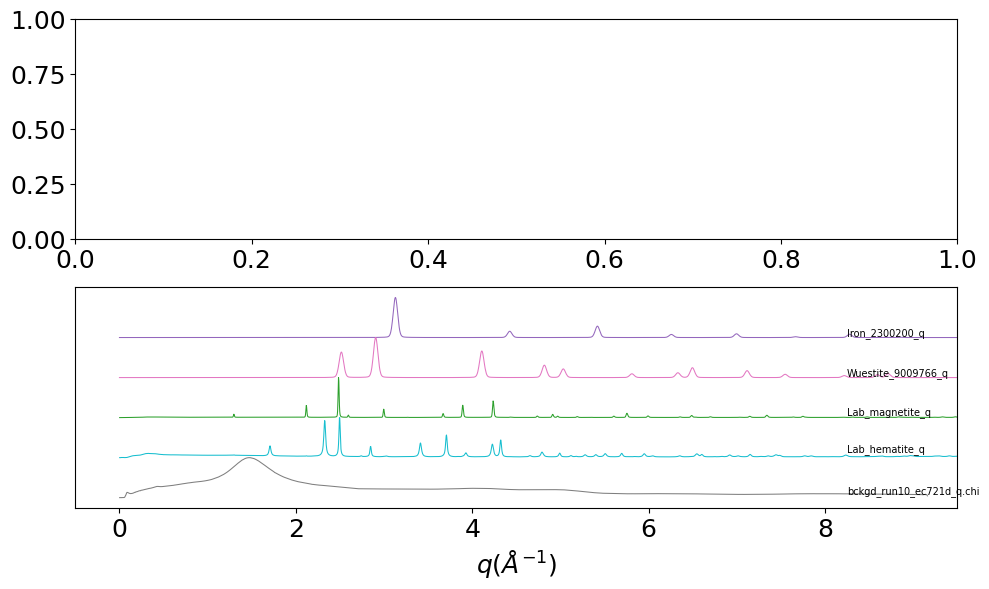

In [ ]:
#@title Movie of findpeaks inputs: save frames
from time import localtime, strftime
print('remember to run "load in situ" first!!!')

#### inputs #####
print('number of files = ', raw_data_save_all.shape[0])
now = strftime("%Y-%m-%d_%H%M%S", localtime()) #note: this is expressed in UTC time
frame_folder = os.path.basename(run_folder) + '_mov_' + now # desired folder name for the frames
#save location for all of the frames
save_loc = os.path.join(userdir, 'user_analysis', 'xrd_movies', frame_folder) #@param ["os.path.join(userdir, 'user_analysis', 'xrd_movies', frame_folder)"]{"type":"raw"}
markersz = 1.5
mark_dist = .5
markersh = 'v'
line_label_fs = 7


#### plot inputs  ####
figsize = (10, 6)
fs = 18
fig, ax = plt.subplots(2, figsize=figsize, tight_layout=True)
ax[1].set_xlabel(r'$q  ({\AA}^{-1})$', fontsize=fs)
ax[1].set_yticks([])
ax[1].tick_params(labelsize=fs)
ax[1].set_xlim([-.25,11])

#### generating frames ####
#print(timestamps) #timestamps and raw_data_save_all.shape should be equivalent ways of defining the number of frames for the movie!
# print(timestamps[0], timestamps[174])

Imax = bkgdsub_data_save_all[:,:].max() #finding the max intensity for the dataset. this is a reasonable since the number of scans (usually <250) is relatively small to the highest intensity observed throughout the full experiment
print('Imax =',Imax)

# ref_phases = ['Iron_2300200_q', 'Wustite_q','Lab_magnetite_q','Lab_hematite_q','67p_Fe_ore_q','Ceria_q','Chamber_background_450af9_q'] #add fayalite
# color_ref_phases = [lincol_fe, lincol_w, lincol_m, lincol_h, lincol_h_ore, lincol_ceo2,'tab:gray']
ref_phases = ['Iron_2300200_q', 'Wuestite_9009766_q','Lab_magnetite_q','Lab_hematite_q','bckgd_run10_ec721d_q.chi'] #add Wustite_q and ceria back and fayalite
color_ref_phases = [lincol_fe, lincol_w, lincol_m, lincol_h, 'tab:gray'] # lincol_ceo2

ref_shift_y = -1
for i_phase, ref_phase in enumerate(ref_phases):
    reffile = os.path.join(refsdir, ref_phase + '.txt')
    refdata = np.loadtxt(reffile)
    q_ref = refdata[:, 0]
    I_ref = refdata[:, 1]
    #here I will write background-subtracted raw data, then baseline after

    I_ref = I_ref - I_ref.min() #"baselining" the data
    I_ref = I_ref/(I_ref.max())  + ref_shift_y*(i_phase + 1) -5
    ax[1].plot(q_ref, I_ref, linewidth= lw, color= color_ref_phases[i_phase]) #label= ref_phase
    ax[1].text(8.25, I_ref[-1], ref_phase, ha='left', va='bottom', fontsize = line_label_fs)
# plt.legend(loc='upper right')

for iv, timestamp in enumerate(raw_data_save_all[:, 0, 0]):
    frame = iv+1
    # print('frame:',frame)
    rawdata = raw_data_save_all[iv, :, :]
    bkgdsubdata = bkgdsub_data_save_all[iv, :]
    q = rawdata[:, 0]
    I = bkgdsubdata


    #print('Saving frame...!',frame,'/',raw_data_save_all.shape[0])
    fname_typ = frame_folder + '_' + str(frame) +'.png'

    #fig, ax = plt.subplots(figsize=figsize, tight_layout=True)
    ax[0].set_title('findpeaks for ' + os.path.basename(run_folder) +'_frame#' + str(frame), fontsize=fs)
    ax[0].set_xlim(-0.5,9.5) #ax[0].set_xlim([-.25,11])
    ax[1].set_xlim(-0.5,9.5)
    ax[0].set_xticks([])
    ax[0].set_ylim([-.25,Imax])
    ax[0].set_ylabel(r'$I$', fontsize=fs)
    ax[0].tick_params(labelsize=fs)
    my_data = ax[0].plot(q, I, linewidth = lw,color='tab:gray')


    #accessing the findpks data on a by-scan# basis
    if not math.isnan(pk1_outputs[iv,0]):
        fe_idx_lower = int(pk1_idxs[iv,0]) #int(array[0])
        fe_idx_upper = int(pk1_idxs[iv,1]) #int(array[1])
        # print('type of idx:',type(fe_idx_lower))
        ax[0].scatter(q[fe_idx_lower], I[fe_idx_lower], color='r', s = markersz)
        ax[0].scatter(q[fe_idx_upper], I[fe_idx_upper], color='r', s = markersz)
        ax[0].plot(pk1_outputs[iv,0], pk1_outputs[iv,1] + mark_dist, color ='b', marker=markersh, markersize = markersz)
        ax[0].hlines(pk1_outputs[iv,5], pk1_outputs[iv,2], pk1_outputs[iv,3], colors='g', linestyles='--') #linestyles='solid'

    os.makedirs(save_loc, exist_ok=True)

    plt.savefig(os.path.join(save_loc, fname_typ))
    ax[0].clear() #my_data.remove() # del my_data

print('Saved all frames to ',save_loc)

video_name: run10_H2_mov_2025-07-28_235252.mp4
# of images: 80
Done generating movie! Remember to download from Colab!


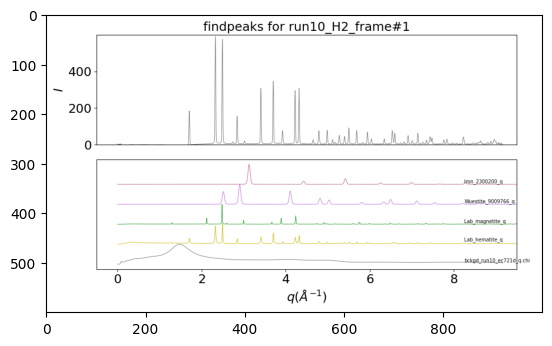

In [ ]:
#@title Generate movie
#reference: https://stackoverflow.com/questions/44947505/how-to-make-a-movie-out-of-images-in-python
#https://stackoverflow.com/questions/73609006/how-to-create-a-video-out-of-frames-without-saving-it-to-disk-using-python

import cv2
import os
image_folder = save_loc
video_name = frame_folder + '.mp4'
print('video_name:',video_name)

images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
# print('images:',images)
print('# of images:',len(images))

frame1 = cv2.imread(os.path.join(image_folder, images[0]))
plt.imshow(frame1)
#print('frame1 read from file located here:',os.path.join(image_folder, images[0]))
height, width, layers = frame1.shape
#print('h, w, l =',frame1.shape)

#video = cv2.VideoWriter(video_name, 0, 1, (width,height))
fourcc = cv2.VideoWriter_fourcc(*'mp4v') #*'XVID'
video = cv2.VideoWriter(video_name, fourcc, 3, (width, height),1) #(width, height)

for image in images:
    #video.write(cv2.imread(os.path.join(image_folder, image)))
    #temp = cv2.imread(os.path.join('/content/drive/Shareddrives/leoradm_group/NSLS-II_202406/userAnalysis/movies_insitu', image))
    temp = cv2.imread(os.path.join(image_folder, image))
    if temp is not None:  #check if the image was read correctly
        video.write(temp)

video.release()
# cv2.destroyAllWindows() this doesn't seem to be necessary within jupyter

#print('image_folder (where we want to write the video):',image_folder)
print('Done generating movie! Remember to download from Colab!')

In [ ]:
#@title global inputs for peak fitting AND trap integration and integration plotting

# which_phase_peak = 'ce' #@param ['h','m','w','fe']{allow-input: true}
a1 = 3.02 #@param ['2.28','2.05','4.005','3.02']{allow-input: true}
b1 = 3.14 #@param ['2.38','2.13','4.12','3.14']{allow-input: true}
# a2 = 2.25 #@param ['2.25','2.08','4.05','3.02']{allow-input: true}
# b2 = 2.38 #@param ['2.38','2.15','4.17','3.14']{allow-input: true}
# a3 = 2.26
# b3 = 2.335

left_bound_for_plot = 2.9 #@param ['2.0','1.8','3.8','2.9']{allow-input: true}
right_bound_for_plot = 3.3 #@param ['2.5','2.35','4.4','3.3']{allow-input: true}
ylim_for_plot = 100 #@param ['500','70','120','200','100']{allow-input: true}

prominence_fe = 18
prominence_w = 30
prominence_m = 15
prominence_h = 20

#defining a, b for each frame
a = []
b = []

for iv, timestamp in enumerate(raw_data_save_all[:, 0, 0]):
    frame = iv + 1
    # print('frame:',frame)
    if frame > 49: #< 10
        a.append(a1)
        b.append(b1)
        # print(a1)
    # elif frame > 9 and frame < 20:
    #     a.append(a2)
    #     b.append(b2)
    #     # print(a2)
    # elif frame > 19 and frame < 33:
    #     a.append(a3)
    #     b.append(b3)
    #     # print(a3)
    # elif frame > 64:
    #     a.append(a4)
    #     b.append(b4)
    #     # print(a4)
    else:
        a.append(float('nan'))
        b.append(float('nan'))

a = np.array(a)
b = np.array(b)

# print('a:',a)
# print('b:',b)

In [ ]:
# @title Peak-finding and writing results to table (defining changing bounds with time)
#modified from NSLS-II_202406 > userScripts > beamline_analysis.ipynb
#here, we perform the find peaks function on the background-subtracted data
print('remember to run "load in situ" first to get raw_data_save_all and bkgdsub_data_save_all!!!')

### inputs ###
# targetpk = ref_q_w #ref_q_fe, ref_q_w, ref_q_m, ref_q_h
pk_prom = prominence_fe  #@param['prominence_fe', 'prominence_w', 'prominence_m', 'prominence_h','prominence_ceo2']{allow-input: true}
###        ###

find_peak_write_table = []

################ finding peaks ######################################
q_values = np.array([raw_data_save_all[i, :, 0] for i in range(len(timestamps))]) #raw_data_save_all[0, :, 0]  # Assuming q is in the first column and I is in the 2nd column
I_bkgdsubdata = np.array([bkgdsub_data_save_all[i, :] for i in range(len(timestamps))])  # Extract intensity data
# print('shape of I_data', np.shape(I_data))
counting = 0
# find_peak_outputs = []

print('reading from bkgdsub_data_save_all')
for iv, timestamp in enumerate(raw_data_save_all[:, 0, 0]):
    timestamp_num = iv+1
    frame = timestamp_num
    print('frame:',frame)
    q = q_values[iv]
    I = I_bkgdsubdata[iv,:] #bkgdsub_data_save_all array is:  (80, 3000)

    ################################### find peaks ############################################
    ###defining the range for find peaks###
    if not math.isnan(a[iv]):
        # print('a:',a,'b:',b)
        pk_idx_lower = int(np.argmin(np.abs(q - a[iv])))
        pk_idx_upper = int(np.argmin(np.abs(q - b[iv])))
        val1_pk, val2_pk, properties, peaks = find_pk_phase(I,pk_idx_lower,pk_idx_upper, pk_prom)
        qs = [float(q[pk_idx_lower]),float(q[pk_idx_upper])]
    else:
        print('no a,b for frame',frame)
        val1_pk = float('nan')
        val2_pk = 0
        pk_idx_lower = float('nan')
        pk_idx_upper = float('nan')
        qs = [float('nan'),float('nan')]
    ###                                 ###

    # print(properties)
    if not val2_pk == 0:
        pk_idx = peaks #the index of the identified peak #equivalently, pk_idx = np.argmin(np.abs(q[pk_idx_lower:pk_idx_upper] - val1_pk))
        q_miniarray = q[pk_idx_lower:pk_idx_upper]
        I_miniarray = I[pk_idx_lower:pk_idx_upper]
        # print('pk_idx:',pk_idx)
        # print('I_miniarray:',I_miniarray)

        fwhms_in_samples, fwhm_heights, leftfwhm_ips_samples, rightfwhm_ips_samples = peak_widths(I_miniarray,pk_idx, rel_height=0.5)
        left_q_coords = np.interp(leftfwhm_ips_samples, np.arange(len(q_miniarray)), q_miniarray)
        right_q_coords = np.interp(rightfwhm_ips_samples, np.arange(len(q_miniarray)), q_miniarray)
        fwhm_in_q_units = right_q_coords - left_q_coords
        # print('left_q_coords:',left_q_coords)
        # print('right_q_coords:',right_q_coords)

        fw_in_samples, fw_heights, leftfw_ips_samples, rightfw_ips_samples = peak_widths(I_miniarray,pk_idx, rel_height=1.0)
        leftfw_q_coords = np.interp(leftfw_ips_samples, np.arange(len(q_miniarray)), q_miniarray)
        rightfw_q_coords = np.interp(rightfw_ips_samples, np.arange(len(q_miniarray)), q_miniarray)
        fw_in_q_units = rightfw_q_coords - leftfw_q_coords

        if len(fwhm_in_q_units) >1:
            print('assuming unimodal distribution for simplicity (assuming this only in the code development mode)')
            print('take the higher intensity peak (default), or manually set the integral bounds later on')
            idx_maxheight = np.argmax(fw_heights)

            left_q_coords = left_q_coords[idx_maxheight]
            right_q_coords = right_q_coords[idx_maxheight]
            fwhm_in_q_units = fwhm_in_q_units[idx_maxheight]
            fwhm_heights = fwhm_heights[idx_maxheight]

            leftfw_q_coords = leftfw_q_coords[idx_maxheight]
            rightfw_q_coords = rightfw_q_coords[idx_maxheight]
            fw_in_q_units = fw_in_q_units[idx_maxheight]
            fw_heights = fw_heights[idx_maxheight]
        # print('pk_wid:',fwhm_in_q_units)
        # print('fwhm_heights:',fwhm_heights)

    if val2_pk == 0:
        left_q_coords = right_q_coords = fwhm_in_q_units = fwhm_heights = float('nan')
        leftfw_q_coords = rightfw_q_coords = fw_in_q_units = fw_heights = float('nan')

    if iv == 63: #uncomment this when you want to get a sense for the peak prominence at a specific time point
        print('the intensity of this peak is at this time is:', val2_pk)

    #set the values here for this one timestamp
    # find_peak_write_table_row = {''}

    # item = {'Scan#': timestamp_num,
    #     'Fe': [val1_fe, val2_fe]
    #         }
    item = {'Scan #': timestamp_num,
            'pk1: idxs, qs, prom, outputs':[[pk_idx_lower,pk_idx_upper], qs, pk_prom, [float(val1_pk), float(val2_pk),float(left_q_coords),float(right_q_coords),float(fwhm_in_q_units), float(fwhm_heights), float(leftfw_q_coords), float(rightfw_q_coords), float(fw_heights)]]
            } #remember to format the data as floats/integers in your table
    find_peak_write_table.append(item)

df = pd.DataFrame(find_peak_write_table) #find_peak_outputs
df.to_csv("findpeaks_output.csv", index=False)
print('\n remember to save findpeaks_output.csv from Colab!')

remember to run "load in situ" first to get raw_data_save_all and bkgdsub_data_save_all!!!
reading from bkgdsub_data_save_all
frame: 1
no a,b for frame 1
frame: 2
no a,b for frame 2
frame: 3
no a,b for frame 3
frame: 4
no a,b for frame 4
frame: 5
no a,b for frame 5
frame: 6
no a,b for frame 6
frame: 7
no a,b for frame 7
frame: 8
no a,b for frame 8
frame: 9
no a,b for frame 9
frame: 10
no a,b for frame 10
frame: 11
no a,b for frame 11
frame: 12
no a,b for frame 12
frame: 13
no a,b for frame 13
frame: 14
no a,b for frame 14
frame: 15
no a,b for frame 15
frame: 16
no a,b for frame 16
frame: 17
no a,b for frame 17
frame: 18
no a,b for frame 18
frame: 19
no a,b for frame 19
frame: 20
no a,b for frame 20
frame: 21
no a,b for frame 21
frame: 22
no a,b for frame 22
frame: 23
no a,b for frame 23
frame: 24
no a,b for frame 24
frame: 25
no a,b for frame 25
frame: 26
no a,b for frame 26
frame: 27
no a,b for frame 27
frame: 28
no a,b for frame 28
frame: 29
no a,b for frame 29
frame: 30
no a,b for f

/tmp/ipython-input-162-839176828.py:96: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'pk1: idxs, qs, prom, outputs':[[pk_idx_lower,pk_idx_upper], qs, pk_prom, [float(val1_pk), float(val2_pk),float(left_q_coords),float(right_q_coords),float(fwhm_in_q_units), float(fwhm_heights), float(leftfw_q_coords), float(rightfw_q_coords), float(fw_heights)]]


In [ ]:
#@title Loading table results into variables
################### reading the find peaks data from the table #####################
folderPath = '/content/findpeaks_output.csv' #paste the folder path here
print('saving data from ',folderPath,'...')
table_data = []
with open(folderPath, mode = 'r') as file:
    csvFile = csv.DictReader(file)
    for lines in csvFile:
        #print(lines)
        table_data.append(lines) #extract data from the file for python treatment

primary = []
pk1 = []
pk1_idxs = []
pk1_prom = []
pk1_outputs = []


count = 0
text = 'primary'
for lines in table_data:
    primary.append(int(float((table_data[count]['Scan #']))))
    pk1.append(str(table_data[count]['pk1: idxs, qs, prom, outputs']))
    count = count + 1
primary = np.array(primary)
pk1 = np.array(pk1)

#accessing the data on a by-scan# basis
for iv, timestamp in enumerate(raw_data_save_all[:, 0, 0]):
    # print(iv)
    timestamp_num = iv+1

    pk1_for_this_primary = pk1[iv]
    tempval = pk1_for_this_primary.replace('[','')
    tempval = tempval.replace(']','')
    pk1_list = tempval.split(",")
    # print('string list for this primary:',pk1_list)
    float_list = [float(item) for item in pk1_list]
    # print('as a float_list:',float_list)
    array = np.array(float_list)
    # print('list as array:',array)
    # print('array[-1]:',array[-1])

    pk1_idxs.append([array[0],array[1]])
    pk1_prom.append(array[4])
    pk1_outputs.append([array[5],array[6],array[7],array[8],array[9],array[10],array[11],array[12],array[13]])

pk1_idxs = np.array(pk1_idxs)
pk1_prom = np.array(pk1_prom)
pk1_outputs = np.array(pk1_outputs)

# print('pk1_idxs:',np.shape(pk1_idxs))
# print('pk1_prom:',np.shape(pk1_prom))
# print('pk1_outputs:',np.shape(pk1_outputs))

saving data from  /content/findpeaks_output.csv ...


/tmp/ipython-input-165-2496498424.py:31: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper right')


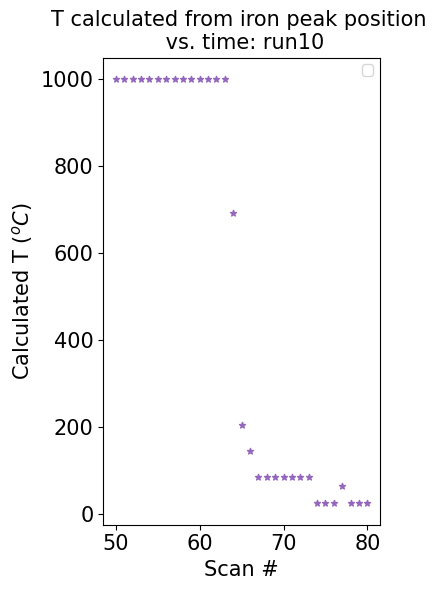

In [ ]:
#@title Plotting phase peak vs time

fig, ax = plt.subplots(figsize=(4,6), tight_layout=True) #(6,6), (7,4), (4,6)
thisfs = 15
markersz1 = 20
markersh = 'o'

# y_fe1 = pk1_outputs[:,1] #intensity
# y_fe2 = pk1_integ_area
pk1_pos = pk1_outputs[:,0] #peak position in q
# first_non_nan = next((x for x in pk1_pos if not math.isnan(x)), None)
q_0 = pk1_pos[-1] #pk1_pos[0] for hematite, pk1_pos[-1] for iron (assumption)
T_calculated = 25 + (10**6/16.48)*((q_0/pk1_pos)-1) #CTE = 16.48x10-6 for iron, 14x10-6 /C for hematite

# ax.scatter(primary, y_fe1, color='tab:gray', marker=markersh, s = markersz1) #lincol_fe
# ax.scatter(primary, y_fe2, color='tab:brown', marker='*', s = markersz1)
# ax.scatter(primary, pk1_pos, color='tab:purple', marker='*', s = markersz1)
ax.scatter(primary, T_calculated, color='tab:purple', marker='*', s = markersz1)

'''
print("find_peak_outputs = ", find_peak_outputs)
print('timestamps = ', timestamps)
print('ntimestamps = ', ntimestamps)
print()
'''

####plotting peak intensity in terms of time, not scan #:
# x_new = [i * frame_length for i in x]


plt.legend(loc='upper right')
ax.set_xlabel('Scan #', fontsize=thisfs)
# axx.set_xlabel('Time (sec)', fontsize=thisfs)

ax.set_ylabel(r'Calculated T (${}^oC$)', fontsize=thisfs) #'Intensity or Area (a.u.)', r'Peak position ($\AA{}^{-1}$)', r'Calculated T ($C^o$)'

ax.tick_params(axis='x', labelsize=thisfs)
ax.tick_params(axis='y', labelsize=thisfs)

# plottit = 'Peak intensity vs. time: ' + expname.split('_')[0]
# plottit = 'Hematite peak intensity (o) or area (*) \n vs. time: run10'
# plottit = 'Iron peak position vs. time: run10'
plottit = 'T calculated from iron peak position \n vs. time: run10'
ax.set_title(plottit, fontsize=thisfs)
plt.show()
#be sure to check that the range, prominence, etc still work with a larger dataset of 125 timestamps

In [ ]:
#@title Save T_calculated array to file
array_to_save = T_calculated
df = pd.DataFrame(array_to_save) #find_peak_outputs
df.to_csv("T_calculated.csv", index=False)
print('\n remember to save integrated_area.csv from Colab!')


 remember to save integrated_area.csv from Colab!


# **4. Integrating peaks**

In [ ]:
#global inputs for this are defined in the previous section

In [ ]:
#@title trapinteg
def trapinteg(q,I,a,b):
    #q, I is the dataset (x, y) and a, b are the left and right bounds for the integration
    idx_a = np.argmin(np.abs(q - a))
    idx_a = int(idx_a)
    # print('idx_a:',idx_a)
    idx_b = np.argmin(np.abs(q - b))
    idx_b = int(idx_b)
    # print('idx_b:',idx_b)

    q_tinyarray = q[idx_a:idx_b+1]
    I_tinyarray = I[idx_a:idx_b+1]

    n_intv = len(q_tinyarray) - 1 #number of intervals for the integration
    dq = (b - a)/n_intv
    # print('n_intv:',n_intv)
    # print('dq:',dq)

    integarea = scipy.integrate.trapezoid(I_tinyarray, q_tinyarray, dx=dq)

    return integarea, idx_a, idx_b

In [ ]:
#@title area_beneath_peak
def area_beneath_peak(q,I,a,b):
    #q, I is the dataset (x, y) and a, b are the left and right bounds for the integration
    idx_a = np.argmin(np.abs(q - a))
    idx_b = np.argmin(np.abs(q - b))

    q_tinyarray = q[idx_a:idx_b+1]
    I_tinyarray = I[idx_a:idx_b+1]

    # Perform linear interpolation
    baseline_interpolated = np.interp([q_tinyarray[0], q_tinyarray[-1]], [q_tinyarray[0], q_tinyarray[-1]], [I_tinyarray[0], I_tinyarray[-1]])
    # this is super not what I thought it was: baseline_interpolated = np.interp(q_tinyarray, q_tinyarray, I_tinyarray) #y_interpolated = np.interp(x_new, x_known, y_known)

    output = scipy.integrate.trapezoid(baseline_interpolated, q_tinyarray)

    return output

Saved all frames to  /content/drive/Shareddrives/Extraction_Subgroup_Data/NSLS-II_202503/user_analysis/xrd_movies/run10_H2_mov_2025-07-30_015138
[]


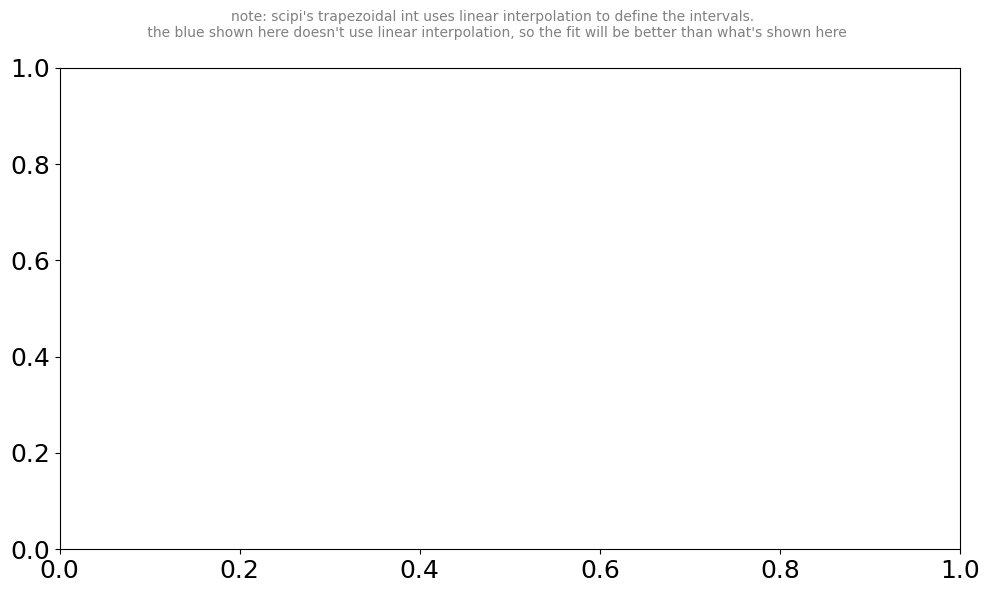

In [ ]:
#@title Plotting the quality of integration (trapezoidal with manual inputs)

from time import localtime, strftime
now = strftime("%Y-%m-%d_%H%M%S", localtime()) #note: this is expressed in UTC time
frame_folder = os.path.basename(run_folder) + '_mov_' + now # desired folder name for the frames
save_loc = os.path.join(userdir, 'user_analysis', 'xrd_movies', frame_folder) #@param ["os.path.join(userdir, 'user_analysis', 'xrd_movies', frame_folder)"]{"type":"raw"}
#### plot inputs  ####
figsize = (10, 6)
fs = 18
fig, ax = plt.subplots(figsize=figsize, tight_layout=True)
ax.set_xlabel(r'$q  ({\AA}^{-1})$', fontsize=fs)
ax.set_yticks([])
ax.tick_params(labelsize=fs)
ax.set_xlim([left_bound_for_plot,right_bound_for_plot])
ax.set_ylim([-.25,ylim_for_plot])
ax.set_ylabel(r'$I$', fontsize=fs)

pk1_integ_area = []
q_values = np.array([raw_data_save_all[i, :, 0] for i in range(len(timestamps))]) #raw_data_save_all[0, :, 0]  # Assuming q is in the first column and I is in the 2nd column
I_bkgdsubdata = np.array([bkgdsub_data_save_all[i, :] for i in range(len(timestamps))])  # Extract intensity data
frames = np.linspace(1, bkgdsub_data_save_all.shape[0], bkgdsub_data_save_all.shape[0]) #generate vector of n values from 1 to n
frames = [int(x) for x in frames]

#fitting peak for every time step
for iv, timestamp in enumerate(raw_data_save_all[:, 0, 0]):
    frame = frames[iv]
    fname_typ = frame_folder + '_' + str(frame) +'.png'
    ax.set_title('Fit for ' + os.path.basename(run_folder) +'_frame#' + str(frame), fontsize=fs)

    ### defining values ###
    q = q_values[iv]
    # print('q:',q)
    I = I_bkgdsubdata[iv]

    # val1 = pk1_outputs[iv,0]
    # left_fwhm_q_coords = pk1_outputs[iv,2]
    # right_fwhm_q_coords = pk1_outputs[iv,3]
    # fwhm_height = pk1_outputs[iv,5]

    # left_fw_q_coords = pk1_outputs[iv,6]
    # right_fw_q_coords = pk1_outputs[iv,7]
    # fw_height = pk1_outputs[iv,8]

    #plot the raw data
    ax.plot(q, I, linewidth = lw,color='tab:gray')
    # print('plotted our data')
    # integral_trapz = scipy.integrate.trapezoid(I_miniarray, q_miniarray, dx=dq)

    if not math.isnan(a[iv]):
        idx_a = np.argmin(np.abs(q - a[iv]))
        # print('idx_a:',idx_a)
        idx_b = np.argmin(np.abs(q - b[iv]))
        # print('idx_b:',idx_b)
        q_tinyarray = q[idx_a:idx_b+1]
        I_tinyarray = I[idx_a:idx_b+1]

        n_intv = len(q_tinyarray) - 1 #number of intervals for the integration
        # print('n_intv:',n_intv)
        dq = (b[iv] - a[iv])/n_intv
        integ_x_points = np.linspace(a[iv], b[iv], n_intv+1) # Generates n+1 points for n intervals
        baseline_interpolated = np.interp([q_tinyarray[0], q_tinyarray[-1]], [q_tinyarray[0], q_tinyarray[-1]], [I_tinyarray[0], I_tinyarray[-1]])

        #plot the integration bounds
        ax.scatter([a[iv],b[iv]],[I_tinyarray[0],I_tinyarray[-1]],color='tab:purple')
        # print('plotted int bounds')
        #plot the interpolated baseline
        ax.plot([q_tinyarray[0], q_tinyarray[-1]],baseline_interpolated,color='r')
        # print('plotted interpolated baseline')
        # #plot the FWHM
        # ax.scatter([left_fwhm_q_coords,right_fwhm_q_coords],[fwhm_height,fwhm_height],color='g')
        # #plot the full width
        # ax.scatter([left_fw_q_coords,right_fw_q_coords],[fw_height,fw_height],color='y')
        for i in range(n_intv):
            x_i = integ_x_points[i]
            y_i = I_tinyarray[i]
            x_iplus1 = integ_x_points[i+1]
            y_iplus1 = I_tinyarray[i+1]
            trap_x = np.array([x_i, x_iplus1])
            trap_y = np.array([y_i, y_iplus1])
            ax.plot(trap_x, trap_y, '-', color = 'b')
            # print('plotted trap')
        # print('finished full trap')

    subtit = "note: scipi's trapezoidal int uses linear interpolation to define the intervals. \n the blue shown here doesn't use linear interpolation, so the fit will be better than what's shown here"
    fig.suptitle(subtit, fontsize=10, color='gray')
    plt.ylim([-1, ylim_for_plot])
    plt.xlim([left_bound_for_plot, right_bound_for_plot])

    os.makedirs(save_loc, exist_ok=True)
    plt.savefig(os.path.join(save_loc, fname_typ))
    # plt.show() #this is effectively "plot hold off"
    ax.clear() #my_data.remove() # del my_data
print('Saved all frames to ',save_loc)
# pk1_integ_area = np.array(pk1_integ_area) #################
print(pk1_integ_area)

video_name: run10_H2_mov_2025-07-30_015138.mp4
# of images: 80
Done generating movie! Remember to download from Colab!


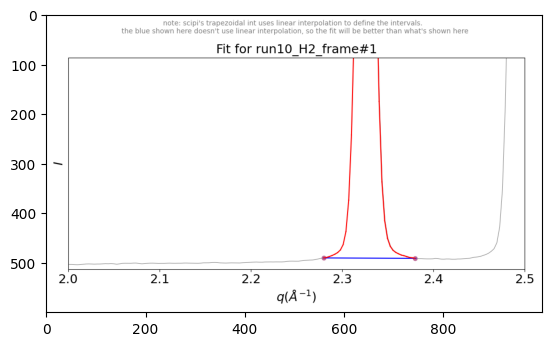

In [ ]:
#@title Generate movie
#reference: https://stackoverflow.com/questions/44947505/how-to-make-a-movie-out-of-images-in-python
#https://stackoverflow.com/questions/73609006/how-to-create-a-video-out-of-frames-without-saving-it-to-disk-using-python

import cv2
import os
image_folder = save_loc
video_name = frame_folder + '.mp4'
print('video_name:',video_name)

images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
# print('images:',images)
print('# of images:',len(images))

frame1 = cv2.imread(os.path.join(image_folder, images[0]))
plt.imshow(frame1)
#print('frame1 read from file located here:',os.path.join(image_folder, images[0]))
height, width, layers = frame1.shape
#print('h, w, l =',frame1.shape)

#video = cv2.VideoWriter(video_name, 0, 1, (width,height))
fourcc = cv2.VideoWriter_fourcc(*'mp4v') #*'XVID'
video = cv2.VideoWriter(video_name, fourcc, 3, (width, height),1) #(width, height)

for image in images:
    #video.write(cv2.imread(os.path.join(image_folder, image)))
    #temp = cv2.imread(os.path.join('/content/drive/Shareddrives/leoradm_group/NSLS-II_202406/userAnalysis/movies_insitu', image))
    temp = cv2.imread(os.path.join(image_folder, image))
    if temp is not None:  #check if the image was read correctly
        video.write(temp)

video.release()
# cv2.destroyAllWindows() this doesn't seem to be necessary within jupyter

#print('image_folder (where we want to write the video):',image_folder)
print('Done generating movie! Remember to download from Colab!')

In [ ]:
#@title Integrating peaks (version: manually setting the integration inputs)

pk1_integ_area = []
q_values = np.array([raw_data_save_all[i, :, 0] for i in range(len(timestamps))]) #raw_data_save_all[0, :, 0]  # Assuming q is in the first column and I is in the 2nd column
I_bkgdsubdata = np.array([bkgdsub_data_save_all[i, :] for i in range(len(timestamps))])  # Extract intensity data



#fitting peak for every time step
for iv, timestamp in enumerate(raw_data_save_all[:, 0, 0]):
    frame = iv + 1
    # print('frame:',frame)
    q = q_values[iv]
    I = I_bkgdsubdata[iv]

    ######## numeric integration method #######
    if not math.isnan(a[iv]):
        tot_integarea, idx_a, idx_b = trapinteg(q,I,a[iv],b[iv])
        net_area = tot_integarea - area_beneath_peak(q,I,a[iv],b[iv])
    else:
        # print('Im neither!')
        net_area = 0

    # print('net_area=',net_area)
    pk1_integ_area.append(net_area)

pk1_integ_area = np.array(pk1_integ_area)
print('len(pk1_integ_area) =',len(pk1_integ_area),' \n pk1_integ_area = \n',pk1_integ_area)
# for index, value in enumerate(pk1_integ_area):
#     print(f"Scan#: {index+1}, pk1_integ_area: {value}")

len(pk1_integ_area) = 80  
 pk1_integ_area = 
 [13.58909971 13.67122161 13.749393   13.70458772 13.62926155 13.28219977
 13.54032162 13.39755628 13.24949894 12.59897098 11.14549714  9.7978959
  8.30737818  6.48251838  5.17344191  4.16506094  3.35764903  2.73230608
  2.216639    1.70174644  1.41082934  1.16561315  0.96804938  0.77960175
  0.61069834  0.48704688  0.37819845  0.27055736  0.19087128  0.13795229
  0.10649273  0.0721183   0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]


In [ ]:
#@title Integrating peaks (version: setting integration inputs automatically with find_peaks outputs)

pk1_integ_area = []
q_values = np.array([raw_data_save_all[i, :, 0] for i in range(len(timestamps))]) #raw_data_save_all[0, :, 0]  # Assuming q is in the first column and I is in the 2nd column
I_bkgdsubdata = np.array([bkgdsub_data_save_all[i, :] for i in range(len(timestamps))])  # Extract intensity data

#fitting peak for every time step
for iv, timestamp in enumerate(raw_data_save_all[:, 0, 0]):

    ### defining values ###
    idx_lower=int(pk1_idxs[iv,0])
    idx_upper=int(pk1_idxs[iv,1])

    q = q_values[iv]
    I = I_bkgdsubdata[iv]

    val1 = pk1_outputs[iv,0]
    left_fwhm_q_coords = pk1_outputs[iv,2]
    right_fwhm_q_coords = pk1_outputs[iv,3]
    calc_fwhm = pk1_outputs[iv,4]
    fwhm_height = pk1_outputs[iv,5]

    left_fw_q_coords = pk1_outputs[iv,6]
    right_fw_q_coords = pk1_outputs[iv,7]
    fw_height = pk1_outputs[iv,8]
    ###      ###        ###

    if math.isnan(val1):
        # print("Value is NaN")
        pk1_integ_area.append(0)
    else:
        q_miniarray = q[idx_lower:idx_upper+1] #the upper limit on the array truncation is exclusive, so add 1 to make the indices for truncation inclusive
        I_miniarray = I[idx_lower:idx_upper+1]

        ######## numeric integration method #######
        a = left_fw_q_coords
        b = right_fw_q_coords
        idx_a = np.argmin(np.abs(q_miniarray - left_fw_q_coords))
        idx_b = np.argmin(np.abs(q_miniarray - right_fw_q_coords))
        q_tinyarray = q_miniarray[idx_a:idx_b+1]
        I_tinyarray = I_miniarray[idx_a:idx_b+1]

        n_intv = len(q_tinyarray) - 1 #number of intervals for the integration
        # print('iv=',iv,' n_intv=',n_intv)
        if n_intv < 10:
            print('iv=',iv,' n_intv=',n_intv)
        dq = (b - a)/n_intv
        # integ_x_points = np.linspace(a, b, n_intv+1) # Generates n+1 points for n intervals
        # for i in range(n_intv):
        #     x_i = integ_x_points[i]
        #     y_i = I_tinyarray[i]
        #     x_iplus1 = integ_x_points[i+1]
        #     y_iplus1 = I_tinyarray[i+1]
        #     trap_x = np.array([x_i, x_iplus1])
        #     trap_y = np.array([y_i, y_iplus1])
        #     ax.plot(trap_x, trap_y, '-', color = 'b')
        # my_data = ax.plot(q_miniarray, I_miniarray, linewidth = lw,color='tab:gray')
        integral_trapz = scipy.integrate.trapezoid(I_tinyarray, q_tinyarray, dx=dq)
        pk1_integ_area.append(integral_trapz)

pk1_integ_area = np.array(pk1_integ_area)
print('len(pk1_integ_area) =',len(pk1_integ_area),' \n pk1_integ_area = \n',pk1_integ_area)
# for index, value in enumerate(pk1_integ_area):
#     print(f"Scan#: {index+1}, pk1_integ_area: {value}")

In [ ]:
#@title Save pk1_integ_area array to file
array_to_save = pk1_integ_area
df = pd.DataFrame(array_to_save) #find_peak_outputs
df.to_csv("pk1_integrated_area.csv", index=False)
print('\n remember to save integrated_area.csv from Colab!')


 remember to save integrated_area.csv from Colab!


In [ ]:
#@title Read file and load into table_data
################### reading the find peaks data from the table #####################
folderPath = '/content/h_integrated_area.csv' #@param ['h_integrated_area.csv','T_calculated']{allow-input: true}
print('saving data from ',folderPath,'...')
table_data = []
with open(folderPath, mode = 'r') as file:
    csvFile = csv.DictReader(file)
    for lines in csvFile:
        # print(lines)
        # print(lines['0'])
        if len(lines['0']) > 0:
            # print("The string is not empty.")
            item = float(lines['0'])
        else:
            item = float('nan')
        table_data.append(item) #extract data from the file for python treatment

table_data = np.array(table_data)
print('table_data:',table_data)

saving data from  /content/h_integrated_area.csv ...
table_data: [13.58909971 13.67122161 13.749393   13.70458772 13.62926155 13.28219977
 13.54032162 13.39755628 13.24949894 12.59897098 11.14549714  9.7978959
  8.30737818  6.48251838  5.17344191  4.16506094  3.35764903  2.73230608
  2.216639    1.70174644  1.41082934  1.16561315  0.96804938  0.77960175
  0.61069834  0.48704688  0.37819845  0.27055736  0.19087128  0.13795229
  0.10649273  0.0721183   0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]


In [ ]:
# fe_integ_area = pk1_integ_area #fe_integ_area, w_integ_area, m_integ_area, h_integ_area

h_integ_area = table_data #fe_integ_area, w_integ_area, m_integ_area, h_integ_area

# fe_integ_area[fe_integ_area < 0] = 0
# print(fe_integ_area)

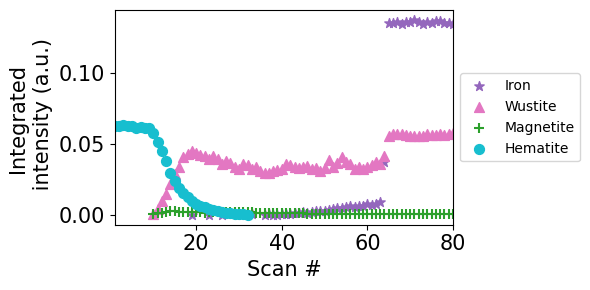

In [ ]:
#@title Plotting integrated itensity of phase peak vs time

fig, ax = plt.subplots(figsize=(6,3), tight_layout=True) #(7,4), (6,6), (6,3)
thisfs = 15
markersz1 = 20 #20, 50
markersh = 'o'

F_fe_110 = 35.3789
# F_h_024 = 165.3
F_h_104 = 217.4 #66.5125
F_m_q2pt5 = 515 #(220) #472.1 #weighted avg #273.4 (avg Fhkl for planes at q=2.5) #754
F_w_220 = 78.674
F_c_111 = 192.45

array1 = fe_integ_area
array2 = w_integ_area
array3 = m_integ_area
array4 = h_integ_area
# array5 = c_integ_area
# array1 = molpct_fe
# array2 = molpct_w
# array3 = molpct_m
# array4 = molpct_h

### replacing zeros with nans ###
value_to_replace = 0
array1[array1 == value_to_replace] = np.nan
array2[array2 == value_to_replace] = np.nan
array3[array3 <= value_to_replace] = np.nan
array4[array4 <= value_to_replace] = np.nan
# array5[array5 == value_to_replace] = np.nan
###                           ###

# ### replacing nans with zeros ###
# value_to_replace = np.nan
# array1[array1 == value_to_replace] = 0
# array2[array2 == value_to_replace] = 0
# array3[array3 == value_to_replace] = 0
# array4[array4 == value_to_replace] = 0
# ###                           ###

y1 = array1 / F_fe_110
y2 = array2 / F_w_220
y3 = array3 / F_m_q2pt5
y4 = array4 / F_h_104 #F_h_024
# y5 = array5 / F_c_111
ytot = y1 + y2 + y3 + y4

ax.scatter(primary, y1, color=lincol_fe, marker='*', s = markersz1, label='Iron') #lincol_fe, 'tab:gray', 'tab:brown'
ax.scatter(primary, y2, color=lincol_w, marker='^', s = markersz1, label='Wustite')
ax.scatter(primary, y3, color=lincol_m, marker='+', s = markersz1, label='Magnetite')
ax.scatter(primary, y4, color=lincol_h, marker='o', s = markersz1, label='Hematite')
# ax.scatter(primary, y5, color=lincol_ceo2, marker='x', s = markersz1, label='CeO2')


'''
print("find_peak_outputs = ", find_peak_outputs)
print('timestamps = ', timestamps)
print('ntimestamps = ', ntimestamps)
print()
'''

####plotting peak intensity in terms of time, not scan #:
# x_new = [i * frame_length for i in x]


# plt.legend(loc='upper right') #'upper right'
plt.legend(bbox_to_anchor=(1, 0.5), loc='center left', fontsize=10)
# plt.tight_layout() #to make sure the legend doesn't overlap with the data
plt.xlim([primary[0],primary[-1]])
# plt.ylim([0,1.5])
ax.set_xlabel('Scan #', fontsize=thisfs)
# axx.set_xlabel('Time (sec)', fontsize=thisfs)
ax.set_ylabel('Integrated \n intensity (a.u.)', fontsize=thisfs) #'Integrated intensity (a.u.)','mol%'
ax.tick_params(axis='x', labelsize=thisfs)
ax.tick_params(axis='y', labelsize=thisfs)
plottit = 'Integrated intensity vs. time: run36 \n normalized by F_hkl' #'run10'
# plottit = 'Peak intensity vs. time: ' + expname.split('_')[0]
# ax.set_title(plottit, fontsize=thisfs)
plt.show()
#be sure to check that the range, prominence, etc still work with a larger dataset of 125 timestamps

In [ ]:
array1 = fe_integ_area
value_to_replace = np.nan

print(array1)

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 8.37690400e-03 0.00000000e+00
 0.00000000e+00 0.00000000e+00 7.54718000e-03 0.00000000e+00
 0.00000000e+00 3.79834000e-03 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.68903035e-02 0.00000000e+00 0.00000000e+00 1.00959601e-02
 1.85923641e-02 1.17102604e-02 3.22280500e-03 1.75090302e-02
 3.05307400e-02 1.75180570e-02 5.47997264e-02 5.13291880e-02
 6.84576910e-02 5.76438640e-02 7.73578600e-02 9.03182520e-02
 1.06166829e-01 1.09844552e-01 1.15232493e-01 1.52097136e-01
 1.82449256e-01 1.79295936e-01 2.00939942e-01 2.17972049e-01
 2.09484915e-01 2.17854834e-01 2.37117401e-01 2.63766591e-01
 2.62295341e-01 2.81166428e-01 3.23489139e-01 1.33166732e+00
 4.77848835e+00 4.782487

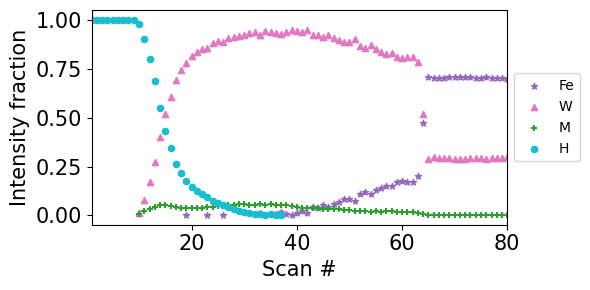

In [ ]:
#@title Plotting intensity fraction of phase peak vs time

fig, ax = plt.subplots(figsize=(6,3), tight_layout=True) #(7,4), (6,6), (6,3)
thisfs = 15
markersz1 = 20 #20, 50
markersh = 'o'

F_fe_110 = 35.3789
# F_h_024 = 165.3
F_h_104 = 217.4 #66.5125
F_m_q2pt5 = 472.1 #weighted avg #273.4 (avg Fhkl for planes at q=2.5) #754
F_w_220 = 78.674
F_c_111 = 192.45

array1 = fe_integ_area
array2 = w_integ_area
array3 = m_integ_area
array4 = h_integ_area


### replacing nans with zeros ###
array1[np.isnan(array1)] = 0
array2[np.isnan(array2)] = 0
array3[np.isnan(array3)] = 0
array4[np.isnan(array4)] = 0
###                           ###

y1 = array1 / F_fe_110
y2 = array2 / F_w_220
y3 = array3 / F_m_q2pt5
y4 = array4 / F_h_104 #F_h_024

ytot = y1 + y2 + y3 + y4
frac1 = y1/ytot
frac2 = y2/ytot
frac3 = y3/ytot
frac4 = y4/ytot

### replacing zeros with nans ###
value_to_replace = 0
frac1[frac1 == value_to_replace] = np.nan
frac2[frac2 == value_to_replace] = np.nan
frac3[frac3 <= value_to_replace] = np.nan
frac4[frac4 <= value_to_replace] = np.nan
###                           ###

ax.scatter(primary, frac1, color=lincol_fe, marker='*', s = markersz1, label='Fe') #lincol_fe, 'tab:gray', 'tab:brown'
ax.scatter(primary, frac2, color=lincol_w, marker='^', s = markersz1, label='W')
ax.scatter(primary, frac3, color=lincol_m, marker='+', s = markersz1, label='M')
ax.scatter(primary, frac4, color=lincol_h, marker='o', s = markersz1, label='H')



'''
print("find_peak_outputs = ", find_peak_outputs)
print('timestamps = ', timestamps)
print('ntimestamps = ', ntimestamps)
print()
'''

####plotting peak intensity in terms of time, not scan #:
# x_new = [i * frame_length for i in x]


# plt.legend(loc='upper right') #'upper right'
plt.legend(bbox_to_anchor=(1, 0.5), loc='center left', fontsize=10)
# plt.tight_layout() #to make sure the legend doesn't overlap with the data
plt.xlim([primary[0],primary[-1]])
# plt.ylim([0,1.5])
ax.set_xlabel('Scan #', fontsize=thisfs)
# axx.set_xlabel('Time (sec)', fontsize=thisfs)
ax.set_ylabel('Intensity fraction', fontsize=thisfs) #'Integrated intensity (a.u.)','mol%'
ax.tick_params(axis='x', labelsize=thisfs)
ax.tick_params(axis='y', labelsize=thisfs)
# ax.set_title(plottit, fontsize=thisfs)
plt.show()
#be sure to check that the range, prominence, etc still work with a larger dataset of 125 timestamps

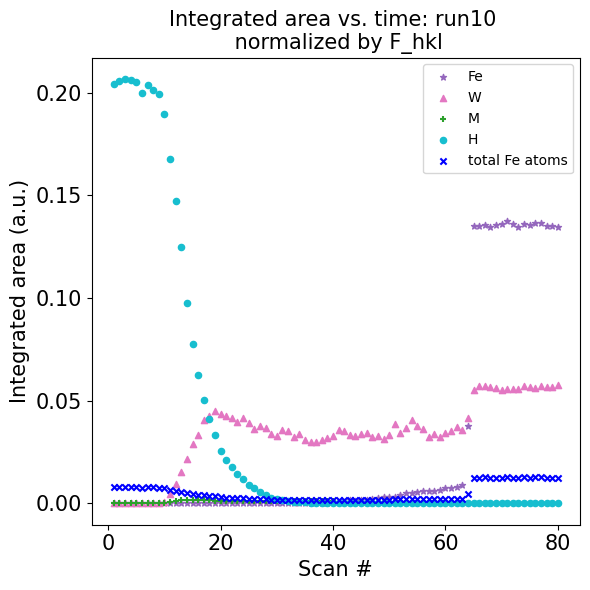

In [ ]:
#@title Plotting # of iron atoms vs time

fig, ax = plt.subplots(figsize=(6,6), tight_layout=True)
thisfs = 15
markersz1 = 20
markersh = 'o'

F_fe_110 = 35.3789
F_h_211 = 66.5125
F_m_q2pt5 = 754 #avg Fhkl for planes at q=2.5
F_w_220 = 78.674

array1 = fe_integ_area
array2 = w_integ_area
array3 = m_integ_area
array4 = h_integ_area
# array1 = molpct_fe
# array2 = molpct_w
# array3 = molpct_m
# array4 = molpct_h

y1 = array1 / F_fe_110
y2 = array2 / F_w_220
y3 = array3 / F_m_q2pt5
y4 = array4 / F_h_211

ax.scatter(primary, y1, color=lincol_fe, marker='*', s = markersz1, label='Fe') #lincol_fe, 'tab:gray', 'tab:brown'
ax.scatter(primary, y2, color=lincol_w, marker='^', s = markersz1, label='W')
ax.scatter(primary, y3, color=lincol_m, marker='+', s = markersz1, label='M')
ax.scatter(primary, y4, color=lincol_h, marker='o', s = markersz1, label='H')


# #change nans back to zero
# array1[np.isnan(array1)] = 0
# array2[np.isnan(array2)] = 0
# array3[np.isnan(array3)] = 0
# array4[np.isnan(array4)] = 0


# y_tot_fe_atoms = y4*4 + y3*6 + y2*1 + y1*1 #multiplicative factor: # Fe atoms / primitive unit cell (PUC)
y_tot_fe_atoms = y4*0.0388 + y3*0.0399 + y2*0.0471 + y1*0.0735 #multiplicative factor: # Fe atoms / volume of PUC
# y_tot_fe_atoms = array1*1 + array2*0.5 + array3*3/7 + array4*2/5 #Fe multiplication factor per mol of phase (from the Rietveld refinement results)
ax.scatter(primary, y_tot_fe_atoms, color='b', marker='x', s = markersz1, label='total Fe atoms')


'''
print("find_peak_outputs = ", find_peak_outputs)
print('timestamps = ', timestamps)
print('ntimestamps = ', ntimestamps)
print()
'''

####plotting peak intensity in terms of time, not scan #:
# x_new = [i * frame_length for i in x]

# ax.set_ylim([-0.025,0.025])
# ax.set_ylim([-0.025,0.75])
plt.legend(loc='upper right')
ax.set_xlabel('Scan #', fontsize=thisfs)
# axx.set_xlabel('Time (sec)', fontsize=thisfs)
ax.set_ylabel('Integrated area (a.u.)', fontsize=thisfs)
# ax.set_ylabel('Mole %', fontsize=thisfs)
ax.tick_params(axis='x', labelsize=thisfs)
ax.tick_params(axis='y', labelsize=thisfs)
# plottit = 'Peak intensity vs. time: ' + expname.split('_')[0]
plottit = 'Integrated area vs. time: run10 \n normalized by F_hkl'
# plottit = 'Mole % vs. time \n from Rietveld refinement'
ax.set_title(plottit, fontsize=thisfs)
plt.show()
#be sure to check that the range, prominence, etc still work with a larger dataset of 125 timestamps

In [ ]:
print(y_tot_fe_atoms)

[       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
 0.30442009        nan        nan        nan 0.25462876        nan
        nan 0.225547          nan        nan        nan        nan
        nan        nan 0.19820042        nan        nan 0.18096241
 0.18238884        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan]


# **archive section**

In [ ]:
#@title Read file and load into molpct_from_refinement
################### reading the find peaks data from the table #####################
folderPath = '/content/run10_molpct.csv' #@param []{allow-input: true}
print('saving data from ',folderPath,'...')
# molpct_from_refinement = []
molpct_fe = []
molpct_w = []
molpct_m = []
molpct_h = []

with open(folderPath, mode = 'r',encoding='utf-8-sig') as file:
    csvFile = csv.DictReader(file)
    for lines in csvFile:
        # print(lines)
        # print(lines['Fe3O4'])
        # item = float(lines)
        molpct_fe.append(float(lines['Fe']))
        molpct_w.append(float(lines['FeO']))
        molpct_m.append(float(lines['Fe3O4']))
        molpct_h.append(float(lines['Fe2O3']))
        # molpct_from_refinement.append(item) #extract data from the file for python treatment

# molpct_from_refinement = np.array(molpct_from_refinement)
# print('molpct_from_refinement:',molpct_from_refinement)
molpct_fe = np.array(molpct_fe)
molpct_w = np.array(molpct_w)
molpct_m = np.array(molpct_m)
molpct_h = np.array(molpct_h)
# print('molpct_from_refinement:',molpct_from_refinement)

saving data from  /content/run10_molpct.csv ...


/usr/local/lib/python3.11/dist-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


[[Model]]
    Model(pvoigt)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 46
    # data points      = 41
    # variables        = 4
    chi-square         = 1798.18106
    reduced chi-square = 48.5994882
    Akaike info crit   = 163.019313
    Bayesian info crit = 169.873601
    R-squared          = 0.98958806
[[Variables]]
    amplitude:  6.11401723 +/- 0.17345102 (2.84%) (init = 7.003325)
    center:     3.09388944 +/- 1.8730e-04 (0.01%) (init = 3.093833)
    sigma:      0.01086936 +/- 2.9520e-04 (2.72%) (init = 0.009178964)
    fraction:   0.48275862 +/- 0.08283383 (17.16%) (init = 0.5)
    fwhm:       0.02173873 +/- 5.9040e-04 (2.72%) == '2.0000000*sigma'
    height:     223.101447 +/- 4.16172709 (1.87%) == '(((1-fraction)*amplitude)/max(1e-15, (sigma*sqrt(pi/log(2))))+(fraction*amplitude)/max(1e-15, (pi*sigma)))'
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, fraction) = +0.7902
    C(sigma, fraction)     = -0.5892
Parameters

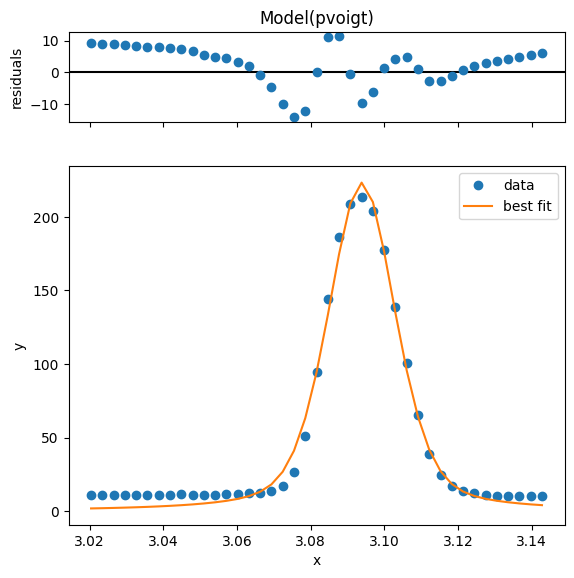

In [ ]:
#@title (ignore) testing the fitting and integration method
from lmfit.models import PseudoVoigtModel
# primary = []
# pk1 = []
# pk1_idxs = []
# pk1_prom = []
# pk1_outputs = []
pk1_integ_area = []
q_values = np.array([raw_data_save_all[i, :, 0] for i in range(len(timestamps))]) #raw_data_save_all[0, :, 0]  # Assuming q is in the first column and I is in the 2nd column
I_bkgdsubdata = np.array([bkgdsub_data_save_all[i, :] for i in range(len(timestamps))])  # Extract intensity data

#fitting peak to psuedo-Voigt for every time step
# for iv, timestamp in enumerate(raw_data_save_all[:, 0, 0]):
iv = 79
lower=int(pk1_idxs[iv,0])
upper=int(pk1_idxs[iv,1])
y = I_bkgdsubdata[iv,lower:upper+1] #upper limit is exclusive, so add 1 to the index as a buffer
# print(y)
mod = PseudoVoigtModel()

#may need to save more outputs from peakfinding like center and width and fwhm.
fit_params = mod.guess(y, x = q_values[iv,lower:upper+1], peak_center=pk1_outputs[iv,0])
# import lmfit
# fit_params = lmfit.create_params(amp=1.2,
#                                  cen={'value':40, 'vary':False},
#                                  wid={'value': 4, 'min':0},
#                                  fwhm={'expr': 'wid*2.355'})
# result = lmfit.minimize(myfunc, fit_params, args=(x, data), kws={'someflag':True}, ....)
out = mod.fit(y, fit_params, x=x) #look into whether these fitting results are acceptable
print(out.fit_report(min_correl=0.25))
# result = lmfit.minimize(y, fit_params, args=(x), kws={'someflag':True}, ....)
out.plot()
print(out.params) #these are the output results
pk1_integ_area.append(out.params['amplitude'].value)
pk1_integ_area = np.array(pk1_integ_area)
print(pk1_integ_area)

In [ ]:
#@title (for reference only) reading data from the table
folderPath = '/content/findpeaks_output.csv' #paste the folder path here

################### reading the data from the table #####################
table_data = []
with open(folderPath, mode = 'r') as file:
    csvFile = csv.DictReader(file)
    for lines in csvFile:
        #print(lines)
        table_data.append(lines) #extract data from the file for python treatment

primary = []
pk1 = []

count = 0
text = 'primary'
for lines in table_data:
    primary.append(int(float((table_data[count]['Scan #']))))
    pk1.append(str(table_data[count]['pk1: idxs, qs, prom, outputs']))
    count = count + 1
primary = np.array(primary)
pk1 = np.array(pk1)
# print('pk1:',pk1)
# print('pk1[1]:',pk1[1])

#accessing the data on a by-scan# basis
pk1_for_this_primary = pk1[1] ###
tempval = pk1_for_this_primary.replace('[','')
tempval = tempval.replace(']','')
pk1_list = tempval.split(",")
print('string list for this primary:',pk1_list)
float_list = [float(item) for item in pk1_list]
print('as a float_list:',float_list)
array = np.array(float_list)
print('list as array:',array)
print('array[-1]:',array[-1])

string list for this primary: ['996', ' 1026', ' 5.376026153564453', ' 5.83502197265625', ' 55', ' nan', ' 0.0']
as a float_list: [996.0, 1026.0, 5.376026153564453, 5.83502197265625, 55.0, nan, 0.0]
list as array: [ 996.         1026.            5.37602615    5.83502197   55.
           nan    0.        ]
array[-1]: 0.0


In [ ]:
#@title Installs for gaussian/voigt fitting
%pip install lmfit
print('installed')
from lmfit.models import GaussianModel
from lmfit.models import VoigtModel
from lmfit.models import PseudoVoigtModel
# GaussianModel, VoigtModel
# https://lmfit.github.io/lmfit-py/
# https://lmfit.github.io/lmfit-py/builtin_models.html#example-1-fit-peak-data-to-gaussian-lorentzian-and-voigt-profiles

# https://stackoverflow.com/questions/32894417/python-pseudo-voigt-fit-experimental-data
# https://zenodo.org/records/15014437
# https://lmfit.github.io/lmfit-py/model.html#lmfit.model.Model.guess

Saved all frames to  /content/drive/Shareddrives/Extraction_Subgroup_Data/NSLS-II_202503/user_analysis/xrd_movies/run10_H2_mov_2025-06-27_012845
[0, 0, 0, 0, 0, 0, 0, 0, 0]


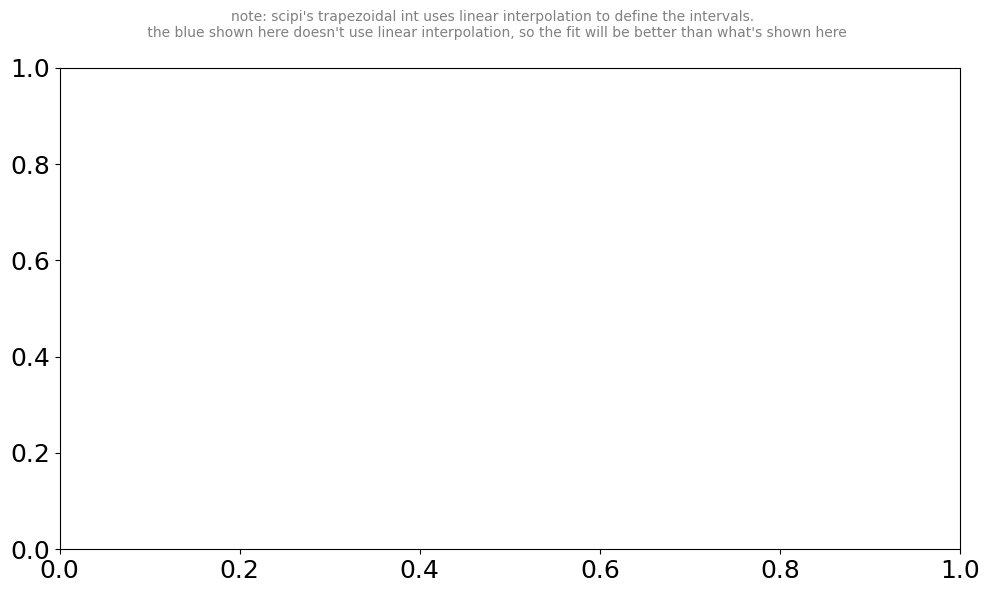

In [ ]:
#@title Plotting the quality of integration (trapezoidal) *OR* single-mode fitting (with Gaussian/Voigt/PseudoVoigt)

from time import localtime, strftime
now = strftime("%Y-%m-%d_%H%M%S", localtime()) #note: this is expressed in UTC time
frame_folder = os.path.basename(run_folder) + '_mov_' + now # desired folder name for the frames
save_loc = os.path.join(userdir, 'user_analysis', 'xrd_movies', frame_folder) #@param ["os.path.join(userdir, 'user_analysis', 'xrd_movies', frame_folder)"]{"type":"raw"}
#### plot inputs  ####
figsize = (10, 6)
fs = 18
fig, ax = plt.subplots(figsize=figsize, tight_layout=True)
ax.set_xlabel(r'$q  ({\AA}^{-1})$', fontsize=fs)
ax.set_yticks([])
ax.tick_params(labelsize=fs)
# ax.set_xlim([2,4])
ax.set_ylim([-.25,400])
ax.set_ylabel(r'$I$', fontsize=fs)

pk1_integ_area = []
q_values = np.array([raw_data_save_all[i, :, 0] for i in range(len(timestamps))]) #raw_data_save_all[0, :, 0]  # Assuming q is in the first column and I is in the 2nd column
I_bkgdsubdata = np.array([bkgdsub_data_save_all[i, :] for i in range(len(timestamps))])  # Extract intensity data


#fitting peak for every time step
for iv, timestamp in enumerate(raw_data_save_all[:, 0, 0]):
    frame = iv+1
    fname_typ = frame_folder + '_' + str(frame) +'.png'
    ax.set_title('Fit for ' + os.path.basename(run_folder) +'_frame#' + str(frame), fontsize=fs)

    ### defining values ###
    idx_lower=int(pk1_idxs[iv,0])
    idx_upper=int(pk1_idxs[iv,1])

    q = q_values[iv]
    I = I_bkgdsubdata[iv]

    val1 = pk1_outputs[iv,0]
    left_fwhm_q_coords = pk1_outputs[iv,2]
    right_fwhm_q_coords = pk1_outputs[iv,3]
    calc_fwhm = pk1_outputs[iv,4]
    fwhm_height = pk1_outputs[iv,5]

    left_fw_q_coords = pk1_outputs[iv,6]
    right_fw_q_coords = pk1_outputs[iv,7]
    fw_height = pk1_outputs[iv,8]
    ###      ###        ###

    if math.isnan(val1):
        # print("Value is NaN")
        pk1_integ_area.append(0)
    else:
        q_miniarray = q[idx_lower:idx_upper+1] #the upper limit on the array truncation is exclusive, so add 1 to make the indices for truncation inclusive
        I_miniarray = I[idx_lower:idx_upper+1]

        ######## numeric integration method #######
        a = left_fw_q_coords
        b = right_fw_q_coords

        idx_a = np.argmin(np.abs(q_miniarray - left_fw_q_coords))
        idx_b = np.argmin(np.abs(q_miniarray - right_fw_q_coords))
        q_tinyarray = q_miniarray[idx_a:idx_b+1]
        I_tinyarray = I_miniarray[idx_a:idx_b+1]

        n_intv = len(q_tinyarray) - 1 #number of intervals for the integration
        dq = (b - a)/n_intv
        integ_x_points = np.linspace(a, b, n_intv+1) # Generates n+1 points for n intervals

        for i in range(n_intv):
            x_i = integ_x_points[i]
            y_i = I_tinyarray[i]
            x_iplus1 = integ_x_points[i+1]
            y_iplus1 = I_tinyarray[i+1]
            trap_x = np.array([x_i, x_iplus1])
            trap_y = np.array([y_i, y_iplus1])
            ax.plot(trap_x, trap_y, '-', color = 'b')
        my_data = ax.plot(q_miniarray, I_miniarray, linewidth = lw,color='tab:gray')
        # integral_trapz = scipy.integrate.trapezoid(I_miniarray, q_miniarray, dx=dq)

        subtit = "note: scipi's trapezoidal int uses linear interpolation to define the intervals. \n the blue shown here doesn't use linear interpolation, so the fit will be better than what's shown here"
        fig.suptitle(subtit, fontsize=10, color='gray')

        '''
        ######## lmfit method #######
        y = I_bkgdsubdata[iv,idx_lower:idx_upper+1] #upper limit is exclusive, so add 1 to the index as a buffer
        xx = q_values[iv,idx_lower:idx_upper+1]
        # print(y)

        mod = PseudoVoigtModel()
        fit_params = mod.guess(y, xx)
        fit_params['center'].set(value=val1, vary=True, expr='')
        fit_params['fwhm'].set(value=calc_fwhm, vary=True, expr='')
        fit_params['height'].set(value=fwhm_height, vary=True, expr='')
        result = mod.fit(y, fit_params, x=xx) #look into whether these fitting results are acceptable
        # print('\n frame #',frame)

        #printing fit_report only if R-squared is above a threshold
        # if result.rsquared >= 0.9:
        #     print('R-squared=', result.rsquared)
        #     print('Reduced chi-squared=',result.redchi)
            # print(result.fit_report(min_correl=0.25))
        subtit = r'$R^2$='+ str(result.rsquared) + ', ' + 'Reduced $\chi^2$=' + str(result.redchi)
        fig.suptitle(subtit, fontsize=14, color='gray')

        # out.plot()
        # print(out.params) #these are the output results
        # pk1_integ_area.append(result.params['amplitude'].value)
        my_data = ax.plot(xx, y, linewidth = lw,color='tab:gray')
        ax.plot(xx, result.best_fit, '-', color = 'b')
        '''
        #plot the FWHM
        ax.scatter([left_fwhm_q_coords,right_fwhm_q_coords],[fwhm_height,fwhm_height],color='g')
        #plot the full width
        ax.scatter([a,b],[fw_height,fw_height],color='y')
        #left_fw_q_coords, right_fw_q_coords

        os.makedirs(save_loc, exist_ok=True)
        plt.savefig(os.path.join(save_loc, fname_typ))
        ax.clear() #my_data.remove() # del my_data
print('Saved all frames to ',save_loc)
# pk1_integ_area = np.array(pk1_integ_area) #################
print(pk1_integ_area)